# Analysis 5 : Price/Volumes ~ FOMC Announcement #

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_ind
from pathlib import Path
DATA_ROOT = Path('../data')
RAW_ROOT = DATA_ROOT / 'raw'
OUTPUT_ROOT = Path('../output')
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)


In [3]:
# import stata_setup, os, sys
# STATA_DIR = r"C:\Program Files\Stata18"      # Windows 
# # STATA_DIR = "/Applications/Stata"           # macOS 
# EDITION = "mp"     

# try:
#     stata_setup.config(STATA_DIR, EDITION)
# except RuntimeError as e:
#     if "already configured" not in str(e).lower():
#         raise
# from pystata import stata, config  # 
# stata.run('display "Stata is ready"')

## Load Data ##

In [4]:
# Step 1: Load the FOMC narrative data and high-frequency trading data
fomc_data = pd.read_csv(RAW_ROOT / 'FOMC_FFR.csv')


# Convert date/time columns to datetime format
# ?? CSV ? DATE ??? "1991/2/7"?TIME ??? "11:30:00"
fomc_data['DateTime'] = pd.to_datetime(fomc_data['DATE'] + ' ' + fomc_data['TIME'], format='%Y/%m/%d %H:%M:%S')

# ? DateTime ??????
cols = fomc_data.columns.tolist()
cols.insert(0, cols.pop(cols.index('DateTime')))
fomc_data = fomc_data[cols]





### hft already Converted from CT ——> ET ###

In [56]:
hft_data = pd.read_csv(RAW_ROOT / 'HFT_IRF.csv')
# ???? hft_data ? DateAndTime
# ???? hft_data ? DateAndTime
hft_data['DateAndTime'] = pd.to_datetime(hft_data['DateAndTime'])



# ??????????
futures_columns = [
    'FF1_Price','FF1_Volume','FF2_Price','FF2_Volume',
    'ED2_Price','ED2_Volume','ED3_Price','ED3_Volume',
    'ED4_Price','ED4_Volume','2yr_price','2yr_Volume',
    '5yr_price','5yr_Volume','10yr_price','10yr_Volume'
]


### Non-FOMC Date Selection ###

In [49]:
def generate_non_fomc_dates(fomc_dates):
    """
    non-FOMC meeting dates are defined as Wednesdays that fall in the middle of the intervals between FOMC meetings,
    """
    fomc_dates = pd.to_datetime(fomc_dates).sort_values()
    non_fomc_dates = []
    
    for i in range(len(fomc_dates) - 1):
        start_date = fomc_dates.iloc[i]
        end_date = fomc_dates.iloc[i + 1]
        
        # calculate the interval in days
        interval_days = (end_date - start_date).days
        
        # only consider intervals longer than 14 days
        if interval_days > 14:
            # find the midpoint of the interval
            mid_date = start_date + pd.Timedelta(days=interval_days // 2)
            
            # find the nearest Wednesday to the midpoint
            days_to_wednesday = (2 - mid_date.weekday()) % 7  # 2 = Wednesday
            wednesday = mid_date + pd.Timedelta(days=days_to_wednesday)
            
            # make sure the Wednesday is at least 7 days away from both FOMC meetings
            # so that it doesn't fall too close to either meeting
            if start_date + pd.Timedelta(days=7) <= wednesday <= end_date - pd.Timedelta(days=7):
                non_fomc_dates.append(wednesday)
    
    return pd.Series(non_fomc_dates, name='DateTime')

# 生成非FOMC日期
non_fomc_dates = generate_non_fomc_dates(fomc_data['DateTime'])

In [50]:
# 根据日期设定正确的公告时间：2013年3月前是2:15 PM，之后是2:00 PM
def get_announcement_time(date):
    """根据日期返回正确的FOMC公告时间"""
    cutoff_date = pd.Timestamp('2013-03-01')
    if date < cutoff_date:
        return '14:15:00'  # 2:15 PM
    else:
        return '14:00:00'  # 2:00 PM

non_fomc_data = pd.DataFrame({
    'DateTime': non_fomc_dates,
    'DATE': non_fomc_dates.dt.strftime('%Y/%m/%d'),
    'TIME': non_fomc_dates.apply(get_announcement_time)
})

# 重新计算完整的DateTime，确保包含正确的时间
non_fomc_data['DateTime'] = pd.to_datetime(
    non_fomc_data['DATE'] + ' ' + non_fomc_data['TIME'], 
    format='%Y/%m/%d %H:%M:%S'
)

## Clean Emini Data ##

In [10]:
# # Load and combine E-mini S&P 500 futures minute data

# data_root = DATA_ROOT
# es_paths = [
#     RAW_ROOT / 'ES_1min_97to22.csv',
#     RAW_ROOT / 'ES_1min_22to25.csv',
# ]

# emini_parts = []
# for path in es_paths:
#     df = pd.read_csv(path)
#     df['DateAndTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
#     df = df[['DateAndTime', 'Close', 'Volume', 'Tick Count']].rename(
#         columns={
#             'Close': 'Emini_Price',
#             'Volume': 'Emini_Volume',
#             'Tick Count': 'Emini_Count',
#         }
#     )
#     emini_parts.append(df)

# emini_hft = (
#     pd.concat(emini_parts, axis=0)
#     .sort_values('DateAndTime')
#     .drop_duplicates('DateAndTime', keep='last')
#     .reset_index(drop=True)
# )

# for col in ['Emini_Price', 'Emini_Volume', 'Emini_Count']:
#     emini_hft[col] = pd.to_numeric(emini_hft[col], errors='coerce')

# emini_hft = emini_hft.dropna(subset=['DateAndTime']).sort_values('DateAndTime').reset_index(drop=True)

# filled = []
# for day, grp in emini_hft.groupby(emini_hft['DateAndTime'].dt.normalize(), sort=True):
#     grp = grp.sort_values('DateAndTime').set_index('DateAndTime')
#     full_index = pd.date_range(day, day + pd.Timedelta(days=1) - pd.Timedelta(minutes=1), freq='T')
#     grp = grp.reindex(full_index)
#     inserted = grp['Emini_Price'].isna()
#     grp['Emini_Price'] = grp['Emini_Price'].ffill()
#     grp.loc[inserted & grp['Emini_Price'].notna(), ['Emini_Volume', 'Emini_Count']] = 0.0
#     grp[['Emini_Volume', 'Emini_Count']] = grp[['Emini_Volume', 'Emini_Count']].fillna(0.0)
#     grp = grp.dropna(subset=['Emini_Price'])
#     grp = grp.reset_index().rename(columns={'index': 'DateAndTime'})
#     filled.append(grp)

# emini_hft = pd.concat(filled, ignore_index=True).sort_values('DateAndTime').reset_index(drop=True)

# emini_hft.to_csv(data_root / 'Emini_HFT.csv', index=False)
# print('E-mini dataset prepared:', emini_hft['DateAndTime'].min(), '->', emini_hft['DateAndTime'].max(), 'rows:', len(emini_hft))


In [51]:
data_root = DATA_ROOT
es_paths = [
    RAW_ROOT / 'ES_1min_97to22.csv',
    RAW_ROOT / 'ES_1min_22to25.csv',
]

# 1) 读取并合并；标准化列名
parts = []
for p in es_paths:
    df = pd.read_csv(p)
    # 兼容不同列名大小写或空格
    # 期望至少有 Date, Time, Close, Volume；如无 Tick Count 则后面会自动处理
    df['DateAndTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')
    rename_map = {}
    for c in df.columns:
        c_lower = c.strip().lower()
        if c_lower == 'close':
            rename_map[c] = 'Emini_Price'
        elif c_lower == 'volume':
            rename_map[c] = 'Emini_Volume'
        elif c_lower.replace(' ', '') in ('tickcount', 'ticks', 'count'):
            rename_map[c] = 'Emini_Count'
    df = df.rename(columns=rename_map)
    keep_cols = ['DateAndTime', 'Emini_Price', 'Emini_Volume']
    if 'Emini_Count' in df.columns:
        keep_cols.append('Emini_Count')
    df = df[keep_cols]
    parts.append(df)

emini = (
    pd.concat(parts, axis=0, ignore_index=True)
      .dropna(subset=['DateAndTime'])
      .drop_duplicates(subset=['DateAndTime'], keep='last')
      .sort_values('DateAndTime')
      .reset_index(drop=True)
)

# 2) 数值化；价格为0视为缺失
for c in ['Emini_Price', 'Emini_Volume', 'Emini_Count']:
    if c in emini.columns:
        emini[c] = pd.to_numeric(emini[c], errors='coerce')

if 'Emini_Price' not in emini.columns or 'Emini_Volume' not in emini.columns:
    raise ValueError("Input files must contain Close (price) and Volume columns.")

emini.loc[emini['Emini_Price'].eq(0), 'Emini_Price'] = np.nan

# 3) 连续分钟索引：从首个有效到最后一个有效（整分钟对齐）
first_ts = emini['DateAndTime'].min().floor('T')
last_ts  = emini['DateAndTime'].max().floor('T')
full_index = pd.date_range(first_ts, last_ts, freq='T')  # 连续 1 分钟

# 4) 标记哪些是原始存在的时间点（用于给补出来的时间点量记0）
emini = emini.set_index('DateAndTime').sort_index()
marker = pd.Series(1, index=emini.index, name='_orig_flag')
emini = emini.join(marker, how='left')

# 5) 对齐到全索引；价格前向填充；补出的点量为0
emini_full = emini.reindex(full_index)

# 价格：前向填充（不会跨越序列开始之前）
emini_full['Emini_Price'] = emini_full['Emini_Price'].ffill()

# inserted: 新增（原始没有）的时间点
inserted = emini_full['_orig_flag'].isna()

# 成交量/笔数：对插入的时间点记 0；原本缺失也补 0
emini_full['Emini_Volume'] = emini_full['Emini_Volume'].where(~inserted, 0.0)
emini_full['Emini_Volume'] = emini_full['Emini_Volume'].fillna(0.0)

if 'Emini_Count' in emini_full.columns:
    emini_full['Emini_Count'] = emini_full['Emini_Count'].where(~inserted, 0.0)
    emini_full['Emini_Count'] = emini_full['Emini_Count'].fillna(0.0)
else:
    # 若原始没有 Tick Count，就创建列以保持一致
    emini_full['Emini_Count'] = 0.0

# 6) 去掉辅助标记，输出
emini_full = emini_full.drop(columns=['_orig_flag'])
emini_full = emini_full.reset_index().rename(columns={'index': 'DateAndTime'})

out_path = data_root / 'Emini_All.csv'
emini_full.to_csv(out_path, index=False)

print(
    f"E-mini continuous dataset prepared:\n"
    f"  {first_ts} -> {last_ts}\n"
    f"  rows (minutes): {len(emini_full):,}\n"
    f"  saved to: {out_path}"
)

C:\Users\galax\AppData\Local\Temp\ipykernel_55864\603773043.py:49: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  first_ts = emini['DateAndTime'].min().floor('T')
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\603773043.py:50: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  last_ts  = emini['DateAndTime'].max().floor('T')
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\603773043.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(first_ts, last_ts, freq='T')  # 连续 1 分钟


E-mini continuous dataset prepared:
  1997-09-10 01:01:00 -> 2025-06-25 17:00:00
  rows (minutes): 14,616,960
  saved to: ..\data\Emini_All.csv


In [12]:
# Align non-FOMC events with periods where market data exist
data_min = min(hft_data['DateAndTime'].min(), emini_full['DateAndTime'].min())
data_max = max(hft_data['DateAndTime'].max(), emini_full['DateAndTime'].max())
buffer = pd.Timedelta(days=2)  # largest window size (k=2)
non_fomc_data = (
    non_fomc_data[
        (non_fomc_data['DateTime'] >= data_min + buffer)
        & (non_fomc_data['DateTime'] <= data_max - buffer)
    ]
    .reset_index(drop=True)
)
print(f'Non-FOMC events after data alignment: {len(non_fomc_data)}')


Non-FOMC events after data alignment: 272


## Split Periods ##

In [54]:
from pathlib import Path
import pandas as pd
PDATA_ROOT = DATA_ROOT / 'periods'
# ===== Period boundaries =====
pre_end    = pd.Timestamp('2008-12-31')
zlb_start  = pd.Timestamp('2009-01-01')
zlb_end    = pd.Timestamp('2015-11-30')
post_start = pd.Timestamp('2015-12-01')

def split_and_cache(hft_data, emini_hft, fomc_data, output_dir, *,
                    force: bool = False,
                    src_files: dict | None = None):
    """Split datasets by ZLB periods, caching results on disk."""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    outs = {
        "pre_zlb_hft":    output_dir / "pre_zlb_hft.csv",
        "zlb_hft":        output_dir / "zlb_hft.csv",
        "post_zlb_hft":   output_dir / "post_zlb_hft.csv",
        "pre_zlb_emini":  output_dir / "pre_zlb_emini.csv",
        "zlb_emini":      output_dir / "zlb_emini.csv",
        "post_zlb_emini": output_dir / "post_zlb_emini.csv",
        "pre_zlb_fomc":   output_dir / "pre_zlb_fomc.csv",
        "zlb_fomc":       output_dir / "zlb_fomc.csv",
        "post_zlb_fomc":  output_dir / "post_zlb_fomc.csv",
    }
    parse_dates = {
        key: ['DateAndTime'] for key in outs if 'fomc' not in key
    }
    parse_dates.update({
        'pre_zlb_fomc': ['DateTime'],
        'zlb_fomc': ['DateTime'],
        'post_zlb_fomc': ['DateTime'],
    })

    def all_exist() -> bool:
        return all(path.exists() for path in outs.values())

    def outputs_newer_than_sources() -> bool:
        if not src_files:
            return True
        try:
            newest_src = max(Path(p).stat().st_mtime for p in src_files.values())
            oldest_out = min(Path(p).stat().st_mtime for p in outs.values())
            return oldest_out >= newest_src
        except FileNotFoundError:
            return False

    if all_exist() and not force and outputs_newer_than_sources():
        return {
            key: pd.read_csv(path, parse_dates=parse_dates.get(key))
            for key, path in outs.items()
        }

    pre_zlb_hft    = hft_data[hft_data['DateAndTime'] <= pre_end]
    zlb_hft        = hft_data[(hft_data['DateAndTime'] >= zlb_start) & (hft_data['DateAndTime'] <= zlb_end)]
    post_zlb_hft   = hft_data[hft_data['DateAndTime'] >= post_start]

    pre_zlb_emini  = emini_hft[emini_hft['DateAndTime'] <= pre_end]
    zlb_emini      = emini_hft[(emini_hft['DateAndTime'] >= zlb_start) & (emini_hft['DateAndTime'] <= zlb_end)]
    post_zlb_emini = emini_hft[emini_hft['DateAndTime'] >= post_start]

    def _split_fomc(df: pd.DataFrame):
        return (
            df[df['DateTime'] <= pre_end],
            df[(df['DateTime'] >= zlb_start) & (df['DateTime'] <= zlb_end)],
            df[df['DateTime'] >= post_start],
        )

    pre_zlb_fomc, zlb_fomc, post_zlb_fomc = _split_fomc(fomc_data)

    for key, df in {
        "pre_zlb_hft": pre_zlb_hft,
        "zlb_hft": zlb_hft,
        "post_zlb_hft": post_zlb_hft,
        "pre_zlb_emini": pre_zlb_emini,
        "zlb_emini": zlb_emini,
        "post_zlb_emini": post_zlb_emini,
        "pre_zlb_fomc": pre_zlb_fomc,
        "zlb_fomc": zlb_fomc,
        "post_zlb_fomc": post_zlb_fomc,
    }.items():
        df.to_csv(outs[key], index=False)

    return {
        "pre_zlb_hft":     pre_zlb_hft,
        "zlb_hft":         zlb_hft,
        "post_zlb_hft":    post_zlb_hft,
        "pre_zlb_emini":   pre_zlb_emini,
        "zlb_emini":       zlb_emini,
        "post_zlb_emini":  post_zlb_emini,
        "pre_zlb_fomc":    pre_zlb_fomc,
        "zlb_fomc":        zlb_fomc,
        "post_zlb_fomc":   post_zlb_fomc,
    }


In [57]:
# Split and cache datasets
splits = split_and_cache(
    hft_data,
    emini_full,
    fomc_data,
    DATA_ROOT / 'periods',
    src_files={
        'hft': RAW_ROOT / 'HFT_IRF.csv',
        'emini_part1': RAW_ROOT / 'ES_1min_97to22.csv',
        'emini_part2': RAW_ROOT / 'ES_1min_22to25.csv',
        'fomc': RAW_ROOT / 'FOMC_FFR.csv',
    },
    force=False,
)
pre_zlb_hft = splits['pre_zlb_hft']
zlb_hft = splits['zlb_hft']
post_zlb_hft = splits['post_zlb_hft']
pre_zlb_emini = splits['pre_zlb_emini']
zlb_emini = splits['zlb_emini']
post_zlb_emini = splits['post_zlb_emini']
pre_zlb_fomc = splits['pre_zlb_fomc']
zlb_fomc = splits['zlb_fomc']
post_zlb_fomc = splits['post_zlb_fomc']


In [58]:
# 为每个时期分割非FOMC数据
def split_non_fomc_data(non_fomc_data):
    """按照相同的时期划分非FOMC数据"""
    pre_end = pd.Timestamp('2008-12-31')
    zlb_start = pd.Timestamp('2009-01-01')
    zlb_end = pd.Timestamp('2015-11-30')
    post_start = pd.Timestamp('2015-12-01')
    
    pre_zlb_non_fomc = non_fomc_data[non_fomc_data['DateTime'] <= pre_end]
    zlb_non_fomc = non_fomc_data[(non_fomc_data['DateTime'] >= zlb_start) & 
                                 (non_fomc_data['DateTime'] <= zlb_end)]
    post_zlb_non_fomc = non_fomc_data[non_fomc_data['DateTime'] >= post_start]
    
    return pre_zlb_non_fomc, zlb_non_fomc, post_zlb_non_fomc

pre_zlb_non_fomc, zlb_non_fomc, post_zlb_non_fomc = split_non_fomc_data(non_fomc_data)

print(f"生成的非FOMC日期总数: {len(non_fomc_data)}")
print(f"Pre-ZLB非FOMC日期: {len(pre_zlb_non_fomc)}")
print(f"ZLB非FOMC日期: {len(zlb_non_fomc)}")
print(f"Post-ZLB非FOMC日期: {len(post_zlb_non_fomc)}")

生成的非FOMC日期总数: 272
Pre-ZLB非FOMC日期: 150
ZLB非FOMC日期: 57
Post-ZLB非FOMC日期: 65


## Basic Setups ##

In [16]:
def calculate_cumulative_return(df, asset_col, baseline_price):
    """
    standardize the asset price series by calculating cumulative returns
    """
    df = df.copy()
    df['Return'] = df[asset_col].pct_change(fill_method=None)
    df['Return'] = df['Return'].replace([np.inf, -np.inf], np.nan).fillna(0.0) 
    df['CumReturn'] = (df[asset_col] / baseline_price) - 1
    return df



In [17]:
# Define a custom tick formatter for the x-axis
def format_tick(t):
    #   Set a reference start time to format the ticks
    ref = pd.Timestamp("2000-01-01 09:30")
    tick_time = ref + pd.Timedelta(minutes=t)
    # Determine which day the tick belongs to based on its value
    if t < 1440:
        return f"Day-1 {tick_time.strftime('%H:%M')}"
    elif t < 2880:
        return f"Day0 {tick_time.strftime('%H:%M')}"
    else:
        return f"Day+1 {tick_time.strftime('%H:%M')}"


##  Descriptive Statistics Framework  ##

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

### BOX-plot ###

In [75]:
# ====== NEW: global cache for pairing FOMC vs Non-FOMC boxplots ======
_BOXPLOT_CACHE = {}  # key: (asset_str, safe_period, int(k)), val: {'fomc': {...}, 'nonfomc': {...}}

def _boxpair_plot_save(daily_fomc, daily_non, intraday_fomc, intraday_non,
                       asset_str, safe_period, k, out_root):
    """
    Make paired boxplots:
      - Daily: rows=buckets (D-2..D+2), cols=events (values = per-event daily total/avg)
      - Intraday: windows in [15,30,60,120,720], values = per-event AverageVolume (Ann) vs AverageVolume_non
    Save figures under out_root / 'boxplots'.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from pathlib import Path

    out_dir = Path(out_root) / "boxplots"
    out_dir.mkdir(parents=True, exist_ok=True)

    # ---------- Daily ----------
    # daily_* are DataFrames: index=Event, columns=[-2,-1,0,+1,+2] (already from summarize_fomc_daily_volume)
    # We want rows=buckets, cols=events -> transpose:
    def _daily_to_row_buckets(df):
        # Ensure columns are exactly five focus days in order
        cols = [-2, -1, 0, 1, 2]
        use = df.reindex(columns=cols)
        # buckets as rows
        return use.T  # rows=5, cols=events

    df_f = _daily_to_row_buckets(daily_fomc).astype(float)
    df_n = _daily_to_row_buckets(daily_non).astype(float)

    # Build samples (per bucket -> array over events)
    bucket_labels = ['D-2','D-1','D0','D+1','D+2']
    fomc_samples = [df_f.iloc[i, :].values[np.isfinite(df_f.iloc[i, :].values)] for i in range(5)]
    non_samples  = [df_n.iloc[i, :].values[np.isfinite(df_n.iloc[i, :].values)] for i in range(5)]

    # positions
    base = np.arange(5)
    width = 0.32
    pos_f = base - width/2
    pos_n = base + width/2

    fig, ax = plt.subplots(figsize=(12, 6))
    bp_f = ax.boxplot(fomc_samples, positions=pos_f, widths=0.28, patch_artist=True, manage_ticks=False, showfliers=False)
    for p in bp_f['boxes']: p.set(facecolor='C0', edgecolor='C0', alpha=0.55)     # FOMC blue
    for artist in bp_f['medians']+bp_f['whiskers']+bp_f['caps']: artist.set(color='C0')

    bp_n = ax.boxplot(non_samples, positions=pos_n, widths=0.28, patch_artist=True, manage_ticks=False, showfliers=False)
    for p in bp_n['boxes']: p.set(facecolor='0.7', edgecolor='0.5', alpha=0.8)    # Non gray
    for artist in bp_n['medians']+bp_n['whiskers']+bp_n['caps']: artist.set(color='0.35')

    # === NEW: overlay mean markers (Daily) ===
    f_means = [np.nanmean(s) if len(s) else np.nan for s in fomc_samples]
    n_means = [np.nanmean(s) if len(s) else np.nan for s in non_samples]
    ax.scatter(pos_f, f_means, s=28, marker='o', zorder=3, color='C0', edgecolor='white', linewidth=0.7)
    ax.scatter(pos_n, n_means, s=28, marker='o', zorder=3, color='0.35', edgecolor='white', linewidth=0.7)


    ax.set_xticks(base); ax.set_xticklabels(bucket_labels)
    ax.set_xlim(-0.7, 4.7)
    ax.set_title(f"5-day Daily volume – FOMC vs Non-FOMC ({asset_str}, {safe_period}, k={k})")
    ax.set_ylabel("Daily volume")
    h_f = plt.Line2D([0],[0], color='C0', lw=8, alpha=0.6)
    h_n = plt.Line2D([0],[0], color='0.55', lw=8, alpha=0.8)
    ax.legend([h_f, h_n], ['FOMC', 'Non-FOMC'], loc='best')
    ax.grid(True, axis='y', alpha=0.25)
    out_daily = out_dir / f"{asset_str}_k{k}_{safe_period}_boxpair_daily.png"
    plt.tight_layout(); plt.savefig(out_daily, dpi=200, bbox_inches='tight'); plt.close()

    # ---------- Intraday ----------
    # intraday_* are per_event_window_stats with columns:
    # ['Event','Window','AnnCount','NonDays','AverageVolume','AverageVolume_non', 'Variance','Variance_non']
    win_list = [15, 30, 60, 120, 720]
    # Build matrices rows=windows, cols=events
    def _win_matrix(df, col):
        sub = df[df['Window'].isin(win_list)].copy()
        piv = sub.pivot(index='Window', columns='Event', values=col).reindex(index=win_list)
        return piv  # rows=len(win_list), cols=events

    F_ann = _win_matrix(intraday_fomc, 'AverageVolume').astype(float)
    N_non = _win_matrix(intraday_non, 'AverageVolume_non').astype(float)

    # samples per window
    wlabels = ['±15m','±30m','±1h','±2h','±12h']
    fomc_samples = [F_ann.iloc[i, :].values[np.isfinite(F_ann.iloc[i, :].values)] for i in range(len(win_list))]
    non_samples  = [N_non.iloc[i, :].values[np.isfinite(N_non.iloc[i, :].values)] for i in range(len(win_list))]

    base = np.arange(len(win_list))
    pos_f = base - width/2
    pos_n = base + width/2

    fig, ax = plt.subplots(figsize=(12, 6))
    bp_f = ax.boxplot(fomc_samples, positions=pos_f, widths=0.28, patch_artist=True, manage_ticks=False, showfliers=False)
    for p in bp_f['boxes']: p.set(facecolor='C0', edgecolor='C0', alpha=0.55)
    for artist in bp_f['medians']+bp_f['whiskers']+bp_f['caps']: artist.set(color='C0')

    bp_n = ax.boxplot(non_samples, positions=pos_n, widths=0.28, patch_artist=True, manage_ticks=False, showfliers=False)
    for p in bp_n['boxes']: p.set(facecolor='0.7', edgecolor='0.5', alpha=0.8)
    for artist in bp_n['medians']+bp_n['whiskers']+bp_n['caps']: artist.set(color='0.35')

    # === NEW: overlay mean markers (Intraday) ===
    f_means = [np.nanmean(s) if len(s) else np.nan for s in fomc_samples]
    n_means = [np.nanmean(s) if len(s) else np.nan for s in non_samples]
    ax.scatter(pos_f, f_means, s=28, marker='o', zorder=3, color='C0', edgecolor='white', linewidth=0.7)
    ax.scatter(pos_n, n_means, s=28, marker='o', zorder=3, color='0.35', edgecolor='white', linewidth=0.7)


    ax.set_xticks(base); ax.set_xticklabels(wlabels)
    ax.set_xlim(-0.7, len(win_list)-0.3)
    ax.set_title(f"Intraday Announcement Windows avg volume – FOMC vs Non-FOMC ({asset_str}, {safe_period}, k={k})")
    ax.set_ylabel("Volume per window")
    ax.legend([h_f, h_n], ['FOMC', 'Non-FOMC'], loc='best')
    ax.grid(True, axis='y', alpha=0.25)
    out_intra = out_dir / f"{asset_str}_k{k}_{safe_period}_boxpair_intraday.png"
    plt.tight_layout(); plt.savefig(out_intra, dpi=200, bbox_inches='tight'); plt.close()

    print(f"Saved boxpairs:\n  {out_daily}\n  {out_intra}")


def _maybe_emit_boxpairs(asset_str, safe_period, k, fomc_type, daily_totals, per_event_window_stats, output_dir):
    """
    Store current side (FOMC or Non-FOMC) into cache; if counterpart exists, emit paired boxplots.
    """
    key = (asset_str, safe_period, int(k))
    side = 'fomc' if (fomc_type != 'nonfomc') else 'nonfomc'
    slot = _BOXPLOT_CACHE.get(key, {})
    slot[side] = {
        'daily_totals': daily_totals,
        'per_event_window_stats': per_event_window_stats,
        'output_dir': output_dir,
    }
    _BOXPLOT_CACHE[key] = slot

    if 'fomc' in slot and 'nonfomc' in slot:
        _boxpair_plot_save(
            daily_fomc = slot['fomc']['daily_totals'],
            daily_non  = slot['nonfomc']['daily_totals'],
            intraday_fomc = slot['fomc']['per_event_window_stats'],
            intraday_non  = slot['nonfomc']['per_event_window_stats'],
            asset_str = asset_str,
            safe_period = safe_period,
            k = k,
            out_root = slot['fomc']['output_dir']  # save under FOMC folder root
        )


In [71]:
import math
from pathlib import Path

import numpy as np
import pandas as pd
DATA_ROOT = Path('../data')
DATA_ROOT.mkdir(parents=True, exist_ok=True)




def _t_sf(t_value, df):
    try:
        from scipy import stats
        return float(stats.t.sf(t_value, df))
    except Exception:
        if math.isinf(t_value):
            return 0.0
        return 0.5 * math.erfc(t_value / math.sqrt(2.0))


def _t_cdf(t_value, df):
    try:
        from scipy import stats
        return float(stats.t.cdf(t_value, df))
    except Exception:
        if math.isinf(t_value):
            return 0.0 if t_value < 0 else 1.0
        return 0.5 * (1.0 + math.erf(t_value / math.sqrt(2.0)))


def _compute_t_summary(samples):
    arr = np.asarray(samples, dtype=float)
    arr = arr[~np.isnan(arr)]
    n = arr.size
    if n == 0:
        return {'mean': np.nan, 't': np.nan, 'p_two': np.nan, 'n': 0}
    mean = float(arr.mean())
    if n < 2:
        return {'mean': mean, 't': np.nan, 'p_two': np.nan, 'n': int(n)}
    std = arr.std(ddof=1)
    if std == 0:
        t_stat = math.inf if mean > 0 else (-math.inf if mean < 0 else 0.0)
        two_sided = 0.0 if mean != 0 else 1.0
        return {'mean': mean, 't': t_stat, 'p_two': two_sided, 'n': int(n)}
    t_stat = mean / (std / math.sqrt(n))
    two_sided = 2.0 * _t_sf(abs(t_stat), n - 1)
    return {'mean': mean, 't': t_stat, 'p_two': two_sided, 'n': int(n)}


def _format_cell(value, pvalue, direction=None, value_fmt=",.0f", p_fmt=".3f"):
    if pd.isna(value):
        value_str = 'NA'
    else:
        value_str = format(value, value_fmt)
    if pd.isna(pvalue):
        p_str = 'p=NA'
    else:
        if pvalue < 0.001:
            p_str = 'p<0.001'
        else:
            p_str = f"p={pvalue:{p_fmt}}"
    if direction:
        if direction == '>':
            p_str = f"{p_str} (>0)"
        elif direction == '<':
            p_str = f"{p_str} (<0)"
        elif direction == '=':
            p_str = f"{p_str} (=0)"
    return f"{value_str}\n{p_str}"


def _latex_escape(text):
    replacements = {
        '_': r'\\_',
        '%': r'\\%',
        '&': r'\\&',
    }
    out = str(text)
    for key, val in replacements.items():
        out = out.replace(key, val)
    return out


def _format_cell_for_latex(cell):
    if isinstance(cell, str) and '\\n' in cell:
        top, bottom = cell.split('\\n', 1)
        return (
            r'\\begin{tabular}[c]{@{}c@{}}'
            + _latex_escape(top)
            + r'\\\\scriptsize{'
            + _latex_escape(bottom)
            + r'}\\end{tabular}'
        )
    return _latex_escape(cell)


def _time_window_mask(tod_array, window_radius, announcement_tod):
    arr = np.asarray(tod_array, dtype=int)
    radius = abs(int(window_radius))
    if radius >= 720:
        return np.ones_like(arr, dtype=bool)
    lower = (announcement_tod - radius) % 1440
    upper = (announcement_tod + radius) % 1440
    if lower <= upper:
        return (arr >= lower) & (arr <= upper)
    return (arr >= lower) | (arr <= upper)


def _prepare_volume_long(vol_input):
    if isinstance(vol_input, pd.DataFrame):
        df_wide = vol_input.copy()
        df_wide.index.name = 'MinuteFromStart'
        columns = list(df_wide.columns)
        if isinstance(df_wide.columns, pd.MultiIndex):
            columns = ['_'.join(str(part) for part in tup if str(part)) for tup in columns]
        columns = [str(col) for col in columns]
        if pd.Index(columns).duplicated().any():
            counts = {}
            adjusted = []
            for col in columns:
                counts[col] = counts.get(col, 0) + 1
                if counts[col] == 1:
                    adjusted.append(col)
                else:
                    adjusted.append(f"{col}__{counts[col]}")
            columns = adjusted
        df_wide.columns = columns
        long = df_wide.stack(dropna=False).reset_index()
        long.columns = ['MinuteFromStart', 'Event', 'Volume']
    else:
        s = pd.Series(vol_input, copy=True)
        s.index.name = 'MinuteFromStart'
        long = s.rename('Volume').reset_index()
        long['Event'] = 0
    long['MinuteFromStart'] = pd.to_numeric(long['MinuteFromStart'], errors='coerce')
    long['Volume'] = pd.to_numeric(long['Volume'], errors='coerce')
    long = long.dropna(subset=['MinuteFromStart'])
    long['MinuteInt'] = np.rint(long['MinuteFromStart']).astype(int)
    long['tod'] = (long['MinuteInt'] % 1440).astype(int)
    return long


def _describe_vector(values):
    arr = np.asarray(values, dtype=float)
    arr = arr[~np.isnan(arr)]
    n = arr.size
    if n == 0:
        return {
            'Mean': np.nan,
            'St. Dev': np.nan,
            'P25': np.nan,
            'P50': np.nan,
            'P75': np.nan,
            'No. Obs': 0,
        }
    return {
        'Mean': float(arr.mean()),
        'St. Dev': float(arr.std(ddof=1)) if n > 1 else 0.0,
        'P25': float(np.percentile(arr, 25)),
        'P50': float(np.percentile(arr, 50)),
        'P75': float(np.percentile(arr, 75)),
        'No. Obs': int(n),
    }


def _format_number(value, decimals):
    if pd.isna(value):
        return ''
    return f"{value:,.{decimals}f}"



def _write_latex_table_multi(df, caption, label, filepath=None, decimals=None, default_decimals=0):
    decimals = decimals or {}
    if not isinstance(df.columns, pd.MultiIndex):
        df = df.copy()
        df.columns = pd.MultiIndex.from_product([df.columns, ['Value']])
    top_labels = []
    for lbl in df.columns.get_level_values(0):
        if lbl not in top_labels:
            top_labels.append(lbl)
    metrics_per_label = {lbl: [col[1] for col in df.columns if col[0] == lbl] for lbl in top_labels}
    lines = [
        r'\begin{table}[!htbp]\centering',
        f'\\caption{{{caption}}}',
        f'\\label{{{label}}}',
        r'\begin{tabular}{l' + 'c' * df.shape[1] + '}',
        r'\hline',
    ]
    header_top = ['']
    for lbl in top_labels:
        span = len(metrics_per_label[lbl])
        header_top.append(f'\\multicolumn{{{span}}}{{c}}{{{_latex_escape(lbl)}}}')
    lines.append(' & '.join(header_top) + ' \\')
    header_bottom = ['']
    for lbl in top_labels:
        for metric in metrics_per_label[lbl]:
            header_bottom.append(_latex_escape(metric))
    lines.append(' & '.join(header_bottom) + ' \\')
    lines.append(r'\hline')
    for idx in df.index:
        row = [_latex_escape(str(idx))]
        for lbl in top_labels:
            for metric in metrics_per_label[lbl]:
                value = df.loc[idx, (lbl, metric)]
                decimals_here = decimals.get(metric, default_decimals)
                row.append(_format_number(value, decimals_here))
        lines.append(' & '.join(row) + ' \\')
    lines.extend([
        r'\hline',
        r'\end{tabular}',
        r'\end{table}',
    ])
    content = '\n'.join(lines)
    if filepath is not None:
        Path(filepath).write_text(content, encoding='utf-8')
    return content


def summarize_fomc_daily_volume(
    vol_input,
    k,
    window_days=2,
    make_tables=False,
    out_prefix=None
):
    """Compute daily FOMC week volume statistics and return a formatted table."""
    long = _prepare_volume_long(vol_input)
    k_int = int(k)
    window_days = int(window_days)
    focus_days = list(range(-window_days, window_days + 1))
    long['DayIndex'] = (long['MinuteInt'] // 1440) - k_int
    filtered = long[long['DayIndex'].isin(focus_days)].copy()
    if filtered.empty:
        empty_columns = pd.MultiIndex.from_product([
            [f'FOMC_week_Day ({d:+d})' for d in focus_days],
            ['Mean', 'St. Dev', 'P25', 'P50', 'P75', 'No. Obs'],
        ])
        empty_table = pd.DataFrame(index=['Avg Daily Volume', 'Diff_Vol (Ann - Day)', '# Obs'], columns=empty_columns)
        return {
            'table': empty_table,
            'daily_totals': pd.DataFrame(),
            'per_day_stats': {},
            'diff_means': {},
        }
    daily_totals = (
        filtered.groupby(['Event', 'DayIndex'])['Volume']
        .sum(min_count=1)
        .unstack('DayIndex')
        .reindex(columns=focus_days)
    )
    column_labels = {
        -2: 'FOMC_week_Day (-2)',
        -1: 'FOMC_week_Day (-1)',
        0: 'FOMC_week_Day (0)',
        1: 'FOMC_week_Day (+1)',
        2: 'FOMC_week_Day (+2)',
    }
    metrics = ['Mean', 'St. Dev', 'P25', 'P50', 'P75', 'No. Obs']
    columns = []
    labels_in_use = []
    for day in focus_days:
        label = column_labels.get(day, f'FOMC_week_Day ({day:+d})')
        labels_in_use.append(label)
        for metric in metrics:
            columns.append((label, metric))
    stats_table = pd.DataFrame(np.nan, index=['Avg Daily Volume', 'Diff_Vol (Ann - Day)', '# Obs'], columns=pd.MultiIndex.from_tuples(columns))
    per_day_stats = {}
    diff_means = {}
    base_series = daily_totals[0] if 0 in daily_totals.columns else pd.Series(dtype=float)
    for day, label in zip(focus_days, labels_in_use):
        series = daily_totals[day] if day in daily_totals.columns else pd.Series(dtype=float)
        stats = _describe_vector(series)
        per_day_stats[day] = stats
        for metric in metrics:
            stats_table.loc['Avg Daily Volume', (label, metric)] = stats.get(metric, np.nan)
        diff_value = np.nan
        if day == 0:
            diff_value = 0.0 if stats['No. Obs'] > 0 else np.nan
        elif not base_series.empty:
            diffs = (base_series - series).dropna()
            diff_value = float(diffs.mean()) if not diffs.empty else np.nan
        diff_means[day] = diff_value
        stats_table.loc['Diff_Vol (Ann - Day)', (label, 'Mean')] = diff_value
        stats_table.loc['# Obs', (label, 'Mean')] = stats.get('No. Obs', np.nan)
    return {
        'table': stats_table,
        'daily_totals': daily_totals,
        'per_day_stats': per_day_stats,
        'diff_means': diff_means,
    }


def analyze_volume_periodicity(
    vol_input,
    k,
    window_list=(15, 30, 60, 120, 720),
    market_open_min=570,
    market_close_min=960,
    exclude_minutes=30,
    make_tables=False,
    out_prefix=None
):
    """Compute per-minute intraday window statistics for announcement and non-announcement days."""
    long = _prepare_volume_long(vol_input)
    k_int = int(k)
    window_list = [abs(int(w)) for w in window_list]
    long['DayIndex'] = (long['MinuteInt'] // 1440) - k_int
    open_start = max(0, market_open_min - exclude_minutes)
    open_end = min(1440, market_open_min + exclude_minutes)
    close_start = max(0, market_close_min - exclude_minutes)
    close_end = min(1440, market_close_min + exclude_minutes)
    excl_mask = (
        ((long['tod'] >= open_start) & (long['tod'] < open_end))
        | ((long['tod'] >= close_start) & (long['tod'] < close_end))
    )
    use = long.loc[~excl_mask].copy()
    use = use.dropna(subset=['Volume'])
    if use.empty:
        empty_columns = pd.MultiIndex.from_product([
            [f'±{w}m' for w in window_list],
            ['Mean', 'St. Dev', 'P25', 'P50', 'P75', 'No. Obs'],
        ])
        empty = pd.DataFrame(index=['Ann Window Volume', 'Diff (Ann - Non)', '# Obs'], columns=empty_columns)
        return {
            'volume_table': empty,
            'variance_table': empty,
            'volume_summary': pd.DataFrame(),
            'variance_summary': pd.DataFrame(),
            'per_event_window_stats': pd.DataFrame(),
        }
    announcement_tod = 14 * 60
    window_records = []
    for (event, day), grp in use.groupby(['Event', 'DayIndex']):
        vols = grp['Volume'].astype(float).to_numpy()
        tods = grp['tod'].to_numpy()
        for w in window_list:
            mask = _time_window_mask(tods, w, announcement_tod)
            if mask.any():
                selected = vols[mask]
                valid = selected[~np.isnan(selected)]
                if valid.size:
                    avg = float(valid.mean())
                    var = float(valid.var(ddof=1)) if valid.size > 1 else np.nan
                    count = int(valid.size)
                else:
                    avg = np.nan
                    var = np.nan
                    count = 0
            else:
                avg = np.nan
                var = np.nan
                count = 0
            window_records.append({
                'Event': event,
                'DayIndex': int(day),
                'Window': int(w),
                'AverageVolume': avg,
                'Variance': var,
                'Count': count,
            })
    window_stats = pd.DataFrame(window_records)
    if window_stats.empty:
        empty_columns = pd.MultiIndex.from_product([
            [f'±{w}m' for w in window_list],
            ['Mean', 'St. Dev', 'P25', 'P50', 'P75', 'No. Obs'],
        ])
        empty = pd.DataFrame(index=['Ann Window Volume', 'Diff (Ann - Non)', '# Obs'], columns=empty_columns)
        return {
            'volume_table': empty,
            'variance_table': empty,
            'volume_summary': pd.DataFrame(),
            'variance_summary': pd.DataFrame(),
            'per_event_window_stats': pd.DataFrame(),
        }
    ann_stats = window_stats[window_stats['DayIndex'] == 0].rename(columns={'Count': 'AnnCount'})
    non_stats = window_stats[window_stats['DayIndex'] != 0]
    non_avg = (
        non_stats.groupby(['Event', 'Window'])['AverageVolume']
        .mean()
        .reset_index(name='AverageVolume_non')
    )
    non_var = (
        non_stats.groupby(['Event', 'Window'])['Variance']
        .mean()
        .reset_index(name='Variance_non')
    )
    non_days = (
        non_stats.groupby(['Event', 'Window'])['AverageVolume']
        .count()
        .reset_index(name='NonDays')
    )
    merged = ann_stats.merge(non_avg, on=['Event', 'Window'], how='left')
    merged = merged.merge(non_var, on=['Event', 'Window'], how='left')
    merged = merged.merge(non_days, on=['Event', 'Window'], how='left')
    window_label_map = {
        15: '±15m',
        30: '±30m',
        60: '±1h',
        120: '±2h',
        720: '±12h',
    }
    metrics = ['Mean', 'St. Dev', 'P25', 'P50', 'P75', 'No. Obs']
    tuples = []
    labels_in_use = []
    for w in window_list:
        label = window_label_map.get(w, f'±{w}m')
        labels_in_use.append(label)
        for metric in metrics:
            tuples.append((label, metric))
    volume_table = pd.DataFrame(np.nan, index=['Ann Window Volume', 'Diff (Ann - Non)', '# Obs'], columns=pd.MultiIndex.from_tuples(tuples))
    variance_table = volume_table.copy()
    volume_summary_records = []
    variance_summary_records = []
    for w, label in zip(window_list, labels_in_use):
        subset = merged[merged['Window'] == w]
        ann_vals = subset['AverageVolume'].dropna()
        diff_vals = (subset['AverageVolume'] - subset['AverageVolume_non']).dropna()
        stats = _describe_vector(ann_vals)
        for metric in metrics:
            volume_table.loc['Ann Window Volume', (label, metric)] = stats.get(metric, np.nan)
        volume_table.loc['Diff (Ann - Non)', (label, 'Mean')] = float(diff_vals.mean()) if not diff_vals.empty else np.nan
        volume_table.loc['# Obs', (label, 'Mean')] = stats.get('No. Obs', np.nan)
        volume_summary_records.append({
            'window_min': w,
            'label': label,
            **stats,
            'DiffMean': float(diff_vals.mean()) if not diff_vals.empty else np.nan,
        })
        ann_var_vals = subset['Variance'].dropna()
        diff_var_vals = (subset['Variance'] - subset['Variance_non']).dropna()
        var_stats = _describe_vector(ann_var_vals)
        for metric in metrics:
            variance_table.loc['Ann Window Volume', (label, metric)] = var_stats.get(metric, np.nan)
        variance_table.loc['Diff (Ann - Non)', (label, 'Mean')] = float(diff_var_vals.mean()) if not diff_var_vals.empty else np.nan
        variance_table.loc['# Obs', (label, 'Mean')] = var_stats.get('No. Obs', np.nan)
        variance_summary_records.append({
            'window_min': w,
            'label': label,
            **var_stats,
            'DiffMean': float(diff_var_vals.mean()) if not diff_var_vals.empty else np.nan,
        })
    volume_summary = pd.DataFrame(volume_summary_records).set_index('window_min') if volume_summary_records else pd.DataFrame()
    variance_summary = pd.DataFrame(variance_summary_records).set_index('window_min') if variance_summary_records else pd.DataFrame()
    per_event_window_stats = merged[
        ['Event', 'Window', 'AnnCount', 'NonDays', 'AverageVolume', 'AverageVolume_non', 'Variance', 'Variance_non']
    ].copy()
    return {
        'volume_table': volume_table,
        'variance_table': variance_table,
        'volume_summary': volume_summary,
        'variance_summary': variance_summary,
        'per_event_window_stats': per_event_window_stats,
    }


def _persist_volume_outputs_enhanced(asset, period, k, daily_table, intraday_volume_table, 
                                   intraday_variance_table, fomc_type='fomc',                                   
                                   daily_totals=None,                      # CHANGED: NEW
                                   per_event_window_stats=None):           # CHANGED: NEW
    """
    增强版输出函数，支持fomc和nonfomc两种类型
    fomc_type: 'fomc' 或 'nonfomc'
    """
    asset_str = str(asset)
    asset_dir = DATA_ROOT / asset_str
    asset_dir.mkdir(parents=True, exist_ok=True)
    
    # 如果是nonfomc类型，创建子文件夹
    if fomc_type == 'nonfomc':
        output_dir = asset_dir / 'nonfomc'
        output_dir.mkdir(parents=True, exist_ok=True)
    else:
        output_dir = asset_dir
    
    period_str = str(period) if period else 'period'
    safe_period = period_str.replace(' ', '_')
    
    # 文件命名加上类型前缀
    prefix = f"{fomc_type}_" if fomc_type == 'nonfomc' else ""
    excel_path = output_dir / f'{prefix}{asset_str}_k{k}_{safe_period}.xlsx'
    
    with pd.ExcelWriter(excel_path) as writer:
        daily_table.to_excel(writer, sheet_name='daily volume')
        intraday_volume_table.to_excel(writer, sheet_name='intraday volume')
        intraday_variance_table.to_excel(writer, sheet_name='intraday volume variance')
    
    latex_dir = output_dir / 'latex'
    latex_dir.mkdir(parents=True, exist_ok=True)
    
    # LaTeX标题调整
    event_type = "Non-FOMC" if fomc_type == 'nonfomc' else "FOMC"
    
    daily_tex = _write_latex_table_multi(
        daily_table,
        f'Average daily volumes around {event_type} announcement',
        f'tab:{asset_str}_{safe_period}_{fomc_type}_daily_volume',
        filepath=None,
        decimals={'Mean': 0, 'St. Dev': 0, 'P25': 0, 'P50': 0, 'P75': 0, 'No. Obs': 0},
        default_decimals=0,
    )
    
    intraday_vol_tex = _write_latex_table_multi(
        intraday_volume_table,
        f'Intraday {event_type} announcement window volume (per-minute averages)',
        f'tab:{asset_str}_{safe_period}_{fomc_type}_intraday_volume',
        filepath=None,
        decimals={'Mean': 3, 'St. Dev': 3, 'P25': 3, 'P50': 3, 'P75': 3, 'No. Obs': 0},
        default_decimals=3,
    )
    
    intraday_var_tex = _write_latex_table_multi(
        intraday_variance_table,
        f'Intraday {event_type} announcement window variance',
        f'tab:{asset_str}_{safe_period}_{fomc_type}_intraday_variance',
        filepath=None,
        decimals={'Mean': 6, 'St. Dev': 6, 'P25': 6, 'P50': 6, 'P75': 6, 'No. Obs': 0},
        default_decimals=6,
    )
    
    latex_path = latex_dir / f'{prefix}{safe_period}.tex'
    latex_content = '\n\n'.join([daily_tex, intraday_vol_tex, intraday_var_tex])
    latex_path.write_text(latex_content, encoding='utf-8')

    # === 在函数末尾，新增：把原生 per-event 表放入缓存，若对手方齐全则画盒须图 ===
    try:
        if isinstance(daily_totals, pd.DataFrame) and isinstance(per_event_window_stats, pd.DataFrame):
            _maybe_emit_boxpairs(
                asset_str = asset_str,
                safe_period = safe_period,
                k = k,
                fomc_type = fomc_type,
                daily_totals = daily_totals.copy(),
                per_event_window_stats = per_event_window_stats.copy(),
                output_dir = output_dir
            )
    except Exception as e:
        print(f"[boxpair] skip (reason: {e})")


    return {
        'excel_path': excel_path,
        'latex_path': latex_path,
        'output_dir': output_dir,
        'latex_dir': latex_dir,
    }

### Outliers in FF1 ###

In [20]:
# NEW: 针对 CR(bps) 序列的“闪崩-回归”段落平滑（线性插值）
def _clean_cr_glitches_series(cr_bps: pd.Series,
                              jump_threshold_bps: float = 1.2,
                              recovery_window: int = 10,
                              max_segment_len: int = 6,
                              revert_fraction: float = 0.6,
                              restrict_band: tuple[int, int] | None = None) -> tuple[pd.Series, list[tuple[int,int]]]:
    """
    cr_bps: index=MinuteFromStart, value=CR(bps)
    若 dif(t)=cr(t)-cr(t-1) <= -jump_threshold_bps，且在 recovery_window 内回到 ≥revert_fraction*跌幅，则把 [t..recover-1] 线性插值。
    仅修复短段（≤max_segment_len）。若给 restrict_band=(L,R)，只修 L..R 范围内的段。
    """
    import numpy as np
    cr = cr_bps.astype(float).copy()
    dif = cr.diff()
    n = len(cr)
    to_fix = []

    t = 1
    while t < n:
        if dif.iloc[t] <= -jump_threshold_bps:
            drop = -dif.iloc[t]
            # 找到“回归”点：在接下来窗口内涨回 ≥revert_fraction*drop
            recovered_at = None
            for h in range(1, recovery_window + 1):
                if t + h >= n: break
                if (cr.iloc[t+h] - cr.iloc[t]) >= revert_fraction * drop:
                    recovered_at = t + h
                    break
            if (recovered_at is not None) and (recovered_at - t) <= max_segment_len:
                a, b = t, recovered_at - 1
                # 若限制带存在，且整个段落不在带内，则跳过
                if restrict_band is not None:
                    L, R = restrict_band
                    if not (a >= L and b <= R):
                        t = recovered_at
                        continue
                to_fix.append((a, b))
                t = recovered_at
            else:
                t += 1
        else:
            t += 1

    cr_fixed = cr.copy()
    for a, b in to_fix:
        left_val  = cr_fixed.iloc[a-1] if a-1 >= 0   else cr_fixed.iloc[a]
        right_val = cr_fixed.iloc[b+1] if b+1 < n    else cr_fixed.iloc[b]
        if np.isfinite(left_val) and np.isfinite(right_val):
            span = b - a + 1
            for k in range(span):
                cr_fixed.iloc[a+k] = left_val + (right_val - left_val) * (k+1) / (span+1)

    return cr_fixed, to_fix


##  Return/Volume Plots Framework ##

In [72]:
def plot_fomc_k_window_enhanced(hft_input, fomc_input, k=1, asset='', period='', 
                               extra_metrics=None, fomc_type='fomc'):
    """
    增强版绘图函数，支持FOMC和非FOMC事件
    fomc_type: 'fomc' 或 'nonfomc'
    """
    from pathlib import Path

    extra_metrics = extra_metrics or {}
    metric_series = {name: [] for name in extra_metrics}

    fomc_list = fomc_input['DateTime']
    all_cr_list = []
    all_vol_list = []
    price_col = asset + '_Price'
    price_return_col = asset + '_CumReturn'
    volume_col = asset + '_Volume'

    window_start_reference = lambda dt: dt.normalize() - pd.Timedelta(days=k)
    window_end_reference = lambda dt: dt.normalize() + pd.Timedelta(days=k + 1)

    time_length_hours = 24 * (2 * k + 1)
    total_minutes = int(time_length_hours * 60)

    for fomc_dt in fomc_list:
        window_start = window_start_reference(fomc_dt)
        window_end = window_end_reference(fomc_dt)

        expected_index = pd.date_range(
            window_start,
            window_end - pd.Timedelta(minutes=1),
            freq='min',
        )

        event_df = (
            hft_input[
                (hft_input['DateAndTime'] >= window_start)
                & (hft_input['DateAndTime'] < window_end)
            ]
            .copy()
        )
        if event_df.empty:
            print(f"Skipping {fomc_type} event at {fomc_dt}: no market data in +/-{k} day window.")
            continue

        event_df = event_df.set_index('DateAndTime').reindex(expected_index)
        event_df.index.name = 'DateAndTime'

        if price_col not in event_df.columns:
            print(f"Skipping {fomc_type} event at {fomc_dt}: {price_col} column missing.")
            continue

        # --- 价格列数值化与“0 视为缺失” ---
        event_df[price_col] = pd.to_numeric(event_df[price_col], errors='coerce')
        event_df.loc[event_df[price_col].eq(0), price_col] = np.nan  # CHANGED: 0 当作缺失

        price_series = event_df[price_col]

        # --- 整天缺失/为0的判定：若窗口内存在“整天全缺失”，则跳过该事件 ---
        # 以自然日分组，统计每一天的非缺失分钟数
        day_non_missing = price_series.groupby(price_series.index.normalize()).apply(lambda s: s.notna().sum())
        if (day_non_missing == 0).any():  # CHANGED: 只有整天都缺才跳过
            missing_days = [d.strftime('%Y-%m-%d') for d, cnt in day_non_missing.items() if cnt == 0]
            print(
                f"Skipping {fomc_type} event at {fomc_dt}: whole-day missing (or zero) on {missing_days} within +/-{k} days."
            )
            continue


        # --- 仅对“单日内的少量 0/NaN”进行填补；不跨日 ---
        # 参数：单日允许填补的最多分钟数（阈值）；起始端最多后向补几分钟
        DAILY_MAX_FILL_COUNT = 20      # 例：单日最多允许填补 20 分钟（≈1.4% 的日内分钟数）
        START_BFILL_LIMIT    = 1       # 起始端最多后向补 1 分钟，避免用太多“未来信息”

        # 0 视为缺失：这一步应在本段之前已经做过；若没有，请补上
        # event_df.loc[event_df[price_col].eq(0), price_col] = np.nan

        # 分日统计“缺失（NaN）分钟数”
        by_day = price_series.groupby(price_series.index.normalize())
        day_missing_count = by_day.apply(lambda s: s.isna().sum())
        day_total_count   = by_day.size()

        # 规则1：若某天“整天缺失/为0”，在上一步整天检查已跳过；此处不再重复
        # 规则2：若某天缺失过多（> DAILY_MAX_FILL_COUNT），判定该事件“不可靠”，跳过
        too_many_missing_days = [d.strftime('%Y-%m-%d') for d, m in day_missing_count.items() if m > DAILY_MAX_FILL_COUNT]
        if too_many_missing_days:
            print(
                f"Skipping {fomc_type} event at {fomc_dt}: excessive intraday gaps on {too_many_missing_days} "
                f"(>{DAILY_MAX_FILL_COUNT} minutes missing in a day) within +/-{k} days."
            )
            continue

        # 规则3：仅在“单日缺失不多”的情况下，对该日内做 ffill + 起始端有限 bfill；不跨日
        def _fill_within_day(s: pd.Series) -> pd.Series:
            # 对该日序列做前向填补
            s_filled = s.ffill()
            # 若该日一开头仍缺，允许少量后向补（只补这天起始的连续缺口，不跨日）
            if pd.isna(s_filled.iloc[0]):
                s_filled = s_filled.bfill(limit=START_BFILL_LIMIT)
            return s_filled

        by_day = price_series.groupby(price_series.index.normalize())
        filled_series = by_day.transform(_fill_within_day)   # CHANGED

        
        #（可选）统计本次实际填补的分钟数
        # 注意：这里的“填补计数”只是用于日志展示，不参与逻辑
        pre_na = price_series.isna().sum()
        post_na = filled_series.isna().sum()
        filled_count = int(pre_na - post_na)
        # print(f"Filled {filled_count} minute-gaps within-day (<= {DAILY_MAX_FILL_COUNT}/day).")

        price_series = filled_series
        event_df[price_col] = price_series 
        
        # 基准价使用填补后的首值
        baseline_price = price_series.iloc[0]
        if pd.isna(baseline_price) or baseline_price <= 0:
            print(
                f"Skipping {fomc_type} event at {fomc_dt} due to invalid baseline price after within-day fill: {baseline_price}."
            )
            continue

        if volume_col not in event_df.columns:
            print(f"Skipping {fomc_type} event at {fomc_dt}: {volume_col} column missing.")
            continue

        event_df[volume_col] = pd.to_numeric(event_df[volume_col], errors='coerce')

        if event_df[volume_col].notna().sum() == 0:
            print(
                f"Skipping {fomc_type} event at {fomc_dt}: {volume_col} missing data within +/-{k} day window."
            )
            continue

        event_df[volume_col] = event_df[volume_col].fillna(0.0)

        event_df = event_df.reset_index().rename(columns={'index': 'DateAndTime'})

        event_df = calculate_cumulative_return(event_df, price_col, baseline_price)
        event_df['MinuteFromStart'] = (event_df['DateAndTime'] - window_start).dt.total_seconds() / 60
        event_df.set_index('MinuteFromStart', inplace=True)

        # NEW: 仅对 FF1 + ZLB 启用“CR 闪崩平滑”，且仅在 14:00±20 分钟内处理
        is_ff1 = (asset.upper() == 'FF1')
        is_zlb = ('ZLB' in str(period).upper())  # 你也可以改成明确的 regime 标记
        if is_ff1 and is_zlb:
            m_15_00 = int(k * 1440 + 15 * 60)
            band = (m_15_00 - 20, m_15_00 + 20)  # 14:00 附近 ±20 分钟
            # 在 bps 空间里做检测与平滑，再还原
            cr_bps = event_df['CumReturn'] * 10000.0
            cr_bps_clean, segs = _clean_cr_glitches_series(
                cr_bps,
                jump_threshold_bps=1.2,     # 你可微调：1.0~1.5
                recovery_window=10,
                max_segment_len=6,
                revert_fraction=0.6,
                restrict_band=band
            )
            if segs:
                # 覆盖为清洗后的 CR（回到“小数”单位）
                event_df['CumReturn'] = cr_bps_clean / 10000.0
                # 可选：日志
                # print(f"FF1 ZLB glitch smoothed at segments {segs} for event {fomc_dt}.")



        all_cr_list.append(event_df['CumReturn'])
        all_vol_list.append(event_df[volume_col])
        for metric_name, column in extra_metrics.items():
            if column in event_df.columns:
                metric_series[metric_name].append(event_df[column])

    if not all_cr_list:
        print(f'No valid {fomc_type} events found!')
        return None

    merged_cr = pd.concat(all_cr_list, axis=1)
    avg_cr = merged_cr.mean(axis=1)
    std_cr = merged_cr.std(axis=1)
    n = merged_cr.shape[1]

    ci_upper = avg_cr + 1.96 * std_cr / np.sqrt(n)
    ci_lower = avg_cr - 1.96 * std_cr / np.sqrt(n)

    avg_cr = avg_cr.sort_index()
    ci_upper = ci_upper.sort_index()
    ci_lower = ci_lower.sort_index()
    full_minutes = np.arange(0, total_minutes + 1)
    avg_cr = avg_cr.reindex(full_minutes, method='nearest')
    ci_upper = ci_upper.reindex(full_minutes, method='nearest')
    ci_lower = ci_lower.reindex(full_minutes, method='nearest')

    avg_cr_bps = avg_cr * 10000
    ci_upper_bps = ci_upper * 10000
    ci_lower_bps = ci_lower * 10000

    merged_vol = pd.concat(all_vol_list, axis=1)
    avg_vol = merged_vol.mean(axis=1)
    avg_vol = avg_vol.sort_index().reindex(full_minutes, method='nearest')

    fig, ax1 = plt.subplots(figsize=(18, 8))

    ax1.plot(full_minutes, avg_cr_bps, color='blue', linewidth=1, label='Avg CumReturn (bps)')
    ax1.fill_between(full_minutes, ci_lower_bps, ci_upper_bps, color='blue', alpha=0.2, label='95% CI')
    ax1.set_ylabel('Cumulative Return (bps)', fontsize=12)
    ax1.set_xlabel('Time', fontsize=12)

    ax2 = ax1.twinx()
    ax2.bar(full_minutes, avg_vol, width=1.0, color='gray', alpha=0.3, label='Avg Volume')
    ax2.set_ylabel('Volume', fontsize=12)

    # === 标注关键时间 ===
    m_14_00 = int(k * 1440 + 14 * 60)       # 14:00
    m_14_15 = int(k * 1440 + 14 * 60 + 15)  # 14:15
    m_14_30 = int(k * 1440 + 14 * 60 + 30)  # 14:30

    # 14:00 红色实线（如果之前已有，可删除旧的，统一用以下风格）
    ax1.axvline(x=m_14_00, color='red', linestyle='-',  linewidth=0.8, label='00')

    # 14:15 红色虚线
    ax1.axvline(x=m_14_15, color='red', linestyle='--', linewidth=0.8, label='15')

    # 14:30 绿色实线
    ax1.axvline(x=m_14_30, color='green', linestyle='-', linewidth=0.8, label='30')

    

    # 文字（仅在 k == 0 时显示）
    if k == 0:  # <-- 只在目标日单日图上显示文字
        y0, y1 = ax1.get_ylim()
        y_text = y0 + 0.02 * (y1 - y0)
        for x_val, txt, c in [
                            (m_14_00, '15', 'red'),
                            (m_14_30, '30', 'green')]:
            ax1.text(x_val + 5, y_text, txt, color=c, fontsize=10, va='bottom', clip_on=False)

    num_days = 2 * k + 1
    for i in range(1, num_days):
        day_boundary = i * 1440
        ax1.axvline(x=day_boundary, color='black', linewidth=1)


    ax1.xaxis.set_major_locator(MultipleLocator(120))
    ax1.xaxis.set_minor_locator(MultipleLocator(60))
    ax1.tick_params(axis='x', which='major', length=10, rotation=45)
    ax1.tick_params(axis='x', which='minor', length=5)

    def time_formatter(x, pos):
        t = x % 1440
        hours = int(t // 60)
        minutes = int(t % 60)
        return f'{hours:02d}:{minutes:02d}'

    ax1.xaxis.set_major_formatter(FuncFormatter(time_formatter))

    ax_top = ax1.twiny()
    ax_top.set_xlim(ax1.get_xlim())
    day_centers = [i * 1440 + 720 for i in range(num_days)]
    day_labels = [f'Day {i - k}' for i in range(num_days)]
    ax_top.set_xticks(day_centers)
    ax_top.set_xticklabels(day_labels)
    ax_top.set_xlabel('Day', fontsize=12)

    ax1.set_xlim(0, total_minutes)

    event_type = 'Non-FOMC' if fomc_type == 'nonfomc' else 'FOMC'
    fig.suptitle(f'{event_type} +/-{k} Days: {price_return_col} & {volume_col} in {period}', fontsize=16)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True)
    plt.tight_layout()

    asset_str = str(asset) if asset else 'asset'
    period_str = str(period) if period else 'period'
    safe_period = period_str.replace(' ', '_')
    asset_dir = DATA_ROOT / asset_str

    # 如果是nonfomc类型，另存到专门的文件夹
    if fomc_type == 'nonfomc':
        save_dir = asset_dir / 'nonfomc'
        save_dir.mkdir(parents=True, exist_ok=True)
        prefix = 'nonfomc_'
    else:
        save_dir = asset_dir
        save_dir.mkdir(parents=True, exist_ok=True)
        prefix = ''

    fig_path = save_dir / f'{prefix}fomc_window_k{k}_{safe_period}.png'
    fig.savefig(fig_path, dpi=200, bbox_inches='tight')
    print(f'Saved figure: {fig_path}')
    plt.show()

    cr_table = pd.DataFrame({
        'MinuteFromStart': full_minutes,
        'Average_CR_bps': avg_cr_bps.values,
        'CI_Lower_bps': ci_lower_bps.values,
        'CI_Upper_bps': ci_upper_bps.values,
        'volume': avg_vol.values,
    })
    cr_out = save_dir / f'{prefix}{asset_str}_in_{k}_cr_{safe_period}.csv'
    cr_table.to_csv(cr_out, index=False)
    print(f'Saved CR table: {cr_out}')

    daily_summary = summarize_fomc_daily_volume(
        merged_vol,
        k=k,
        window_days=2,
        make_tables=False,
    )
    intraday_summary = analyze_volume_periodicity(
        merged_vol,
        k=k,
        window_list=(15, 30, 60, 120, 720),
        make_tables=False,
    )

    persist_info = _persist_volume_outputs_enhanced(
        asset_str,
        period_str,
        k,
        daily_summary['table'],
        intraday_summary['volume_table'],
        intraday_summary['variance_table'],
        fomc_type=fomc_type,
        daily_totals = daily_summary.get('daily_totals'),                         # CHANGED: pass per-event daily matrix
        per_event_window_stats = intraday_summary.get('per_event_window_stats'),
    )
    print(f"Saved summary workbook: {persist_info['excel_path']}")
    print(f"Saved LaTeX bundle: {persist_info['latex_path']}")

    # 扩展指标输出
    extra_exports = {}
    if extra_metrics:
        for metric_name, series_list in metric_series.items():
            if not series_list:
                continue
            merged_metric = pd.concat(series_list, axis=1)
            metric_period = f"{period_str}_{metric_name}".strip('_')
            metric_daily = summarize_fomc_daily_volume(
                merged_metric,
                k=k,
                window_days=2,
                make_tables=False,
            )
            metric_intraday = analyze_volume_periodicity(
                merged_metric,
                k=k,
                window_list=(15, 30, 60, 120, 720),
                make_tables=False,
            )
            metric_export = _persist_volume_outputs_enhanced(
                asset_str,
                metric_period,
                k,
                metric_daily['table'],
                metric_intraday['volume_table'],
                metric_intraday['variance_table'],
                fomc_type=fomc_type,
            )
            print(f"Saved extras ({metric_name}) workbook: {metric_export['excel_path']}")
            print(f"Saved extras ({metric_name}) LaTeX: {metric_export['latex_path']}")
            extra_exports[metric_name] = {
                'daily_summary': metric_daily,
                'intraday_summary': metric_intraday,
                'export_paths': metric_export,
            }

    return {
        'figure_path': fig_path,
        'cr_table_path': cr_out,
        'daily_summary': daily_summary,
        'intraday_summary': intraday_summary,
        'export_paths': persist_info,
        'extra_metrics': extra_exports,
    }


###  Example Plot ###

### ========== Load Data ==========

### ========== Example ==========

```python
plot_fomc_k_window(hft_input=hft_data, fomc_input=fomc_data,k=1, asset='FF1',period='Total')
plot_fomc_k_window(hft_input=hft_data, fomc_input=fomc_data,k=1, asset='ED3',period='Total')
plot_fomc_k_window(hft_input=hft_data, fomc_input=fomc_data,k=1, asset='2yr',period='Total')
```


Skipping fomc event at 2024-01-31 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-12-13 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-11-01 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-09-20 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-07-26 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-06-14 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-05-03 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-03-22 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-02-01 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-12-14 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-11-02 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-09-21 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-07-27 14:00:00: no marke

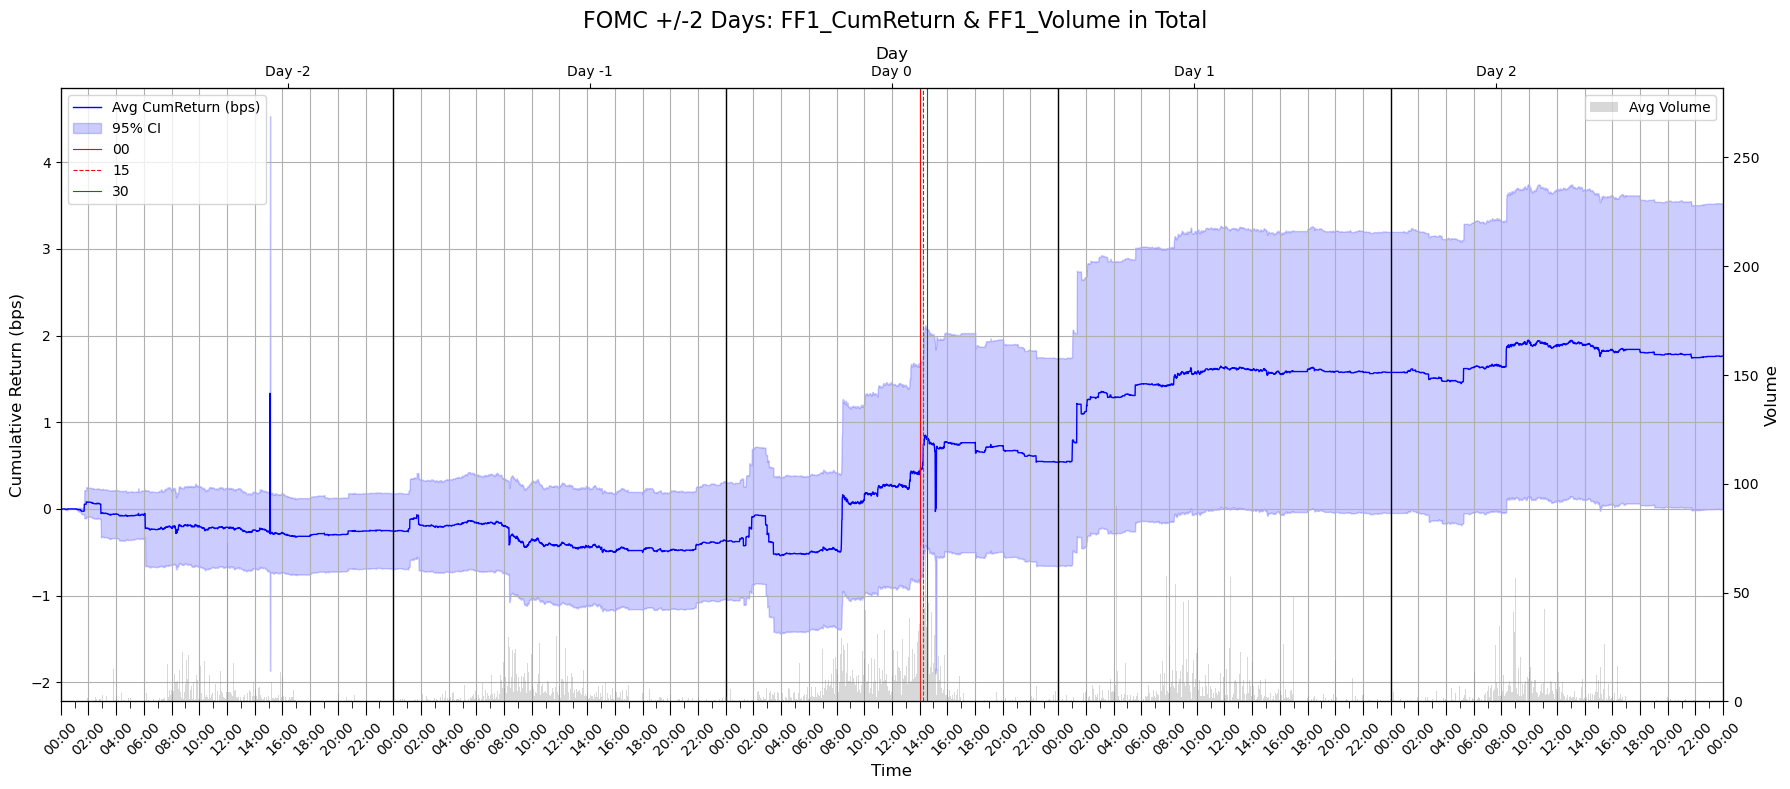

Saved CR table: ..\data\FF1\FF1_in_2_cr_Total.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\1330121967.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\1330121967.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved boxpairs:
  ..\data\FF1\boxplots\FF1_k2_Total_boxpair_daily.png
  ..\data\FF1\boxplots\FF1_k2_Total_boxpair_intraday.png
Saved summary workbook: ..\data\FF1\FF1_k2_Total.xlsx
Saved LaTeX bundle: ..\data\FF1\latex\Total.tex


{'figure_path': WindowsPath('../data/FF1/fomc_window_k2_Total.png'),
 'cr_table_path': WindowsPath('../data/FF1/FF1_in_2_cr_Total.csv'),
 'daily_summary': {'table':                      FOMC_week_Day (-2)                                  \
                                     Mean      St. Dev  P25   P50     P75   
  Avg Daily Volume            2649.026432  6938.179297  0.0  39.0  1788.5   
  Diff_Vol (Ann - Day)        8617.881057          NaN  NaN   NaN     NaN   
  # Obs                        227.000000          NaN  NaN   NaN     NaN   
  
                               FOMC_week_Day (-1)                            \
                       No. Obs               Mean       St. Dev  P25    P50   
  Avg Daily Volume       227.0        4438.114537  12094.841373  0.0  679.0   
  Diff_Vol (Ann - Day)     NaN        6828.792952           NaN  NaN    NaN   
  # Obs                    NaN         227.000000           NaN  NaN    NaN   
  
                        ... FOMC_week_Day (+1)     

In [78]:
## FOMC Day's Plot Examples
plot_fomc_k_window_enhanced(hft_input=hft_data, fomc_input=fomc_data,k=2, asset='FF1',period='Total',extra_metrics=None, fomc_type='fomc')

Skipping nonfomc event at 1991-02-27 14:15:00: whole-day missing (or zero) on ['1991-02-25', '1991-02-26', '1991-02-27', '1991-02-28', '1991-03-01'] within +/-2 days.
Skipping nonfomc event at 1991-03-20 14:15:00: whole-day missing (or zero) on ['1991-03-18', '1991-03-19', '1991-03-20', '1991-03-21', '1991-03-22'] within +/-2 days.
Skipping nonfomc event at 1991-04-17 14:15:00: whole-day missing (or zero) on ['1991-04-15', '1991-04-16', '1991-04-17', '1991-04-18', '1991-04-19'] within +/-2 days.
Skipping nonfomc event at 1991-05-08 14:15:00: whole-day missing (or zero) on ['1991-05-06', '1991-05-07', '1991-05-08', '1991-05-09', '1991-05-10'] within +/-2 days.
Skipping nonfomc event at 1991-06-12 14:15:00: whole-day missing (or zero) on ['1991-06-10', '1991-06-11', '1991-06-12', '1991-06-13', '1991-06-14'] within +/-2 days.
Skipping nonfomc event at 1991-07-24 14:15:00: whole-day missing (or zero) on ['1991-07-22', '1991-07-23', '1991-07-24', '1991-07-25', '1991-07-26'] within +/-2 days

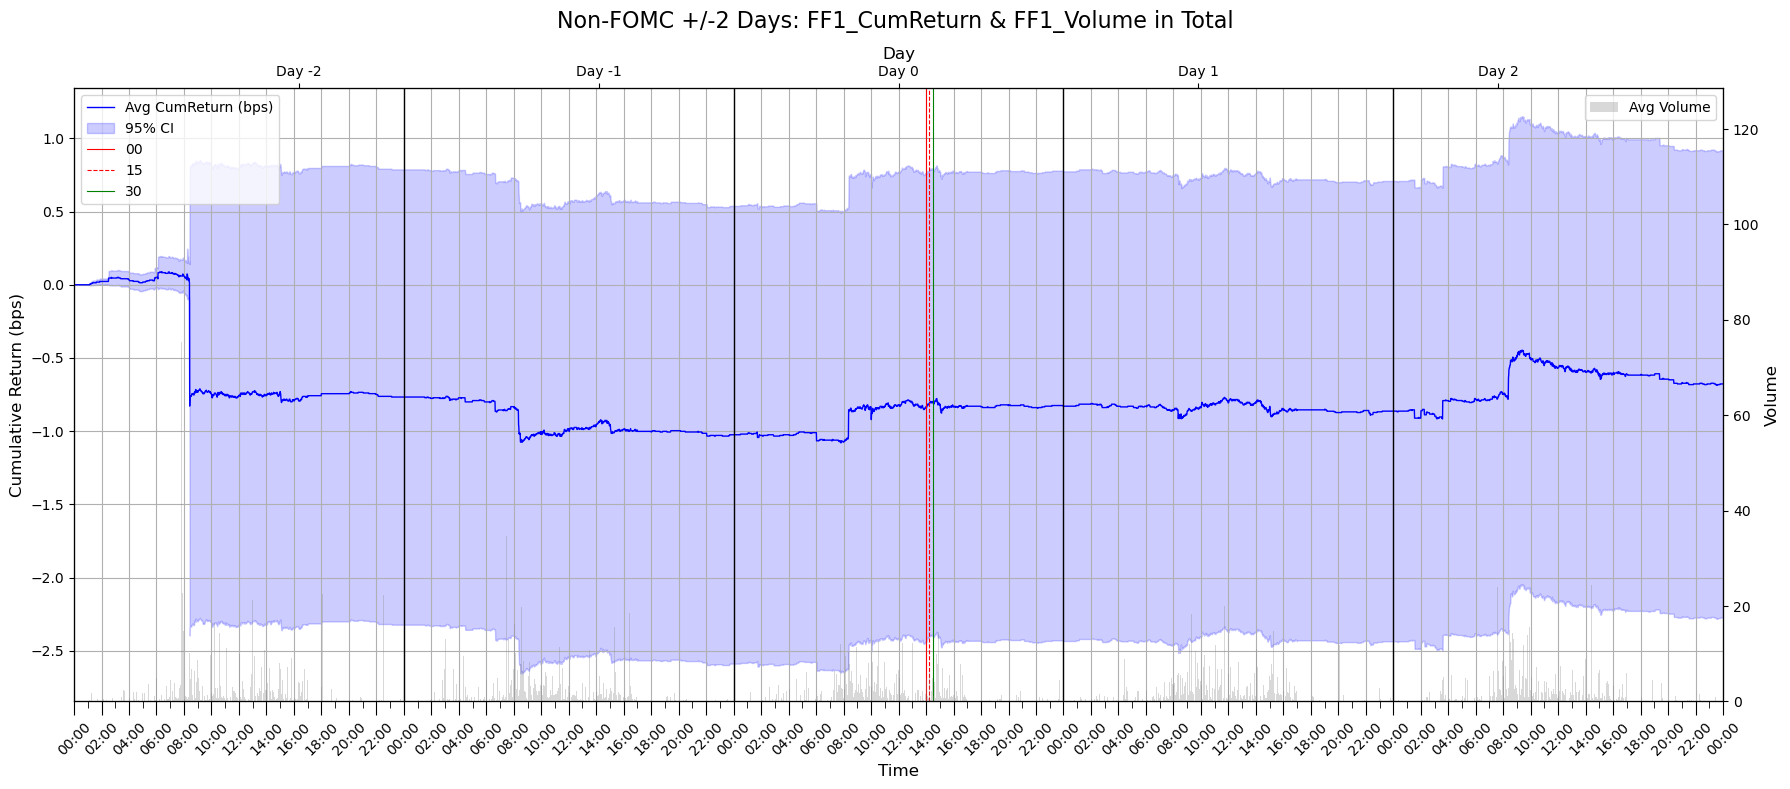

Saved CR table: ..\data\FF1\nonfomc\nonfomc_FF1_in_2_cr_Total.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\1330121967.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\1330121967.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\FF1\nonfomc\nonfomc_FF1_k2_Total.xlsx
Saved LaTeX bundle: ..\data\FF1\nonfomc\latex\nonfomc_Total.tex


{'figure_path': WindowsPath('../data/FF1/nonfomc/nonfomc_fomc_window_k2_Total.png'),
 'cr_table_path': WindowsPath('../data/FF1/nonfomc/nonfomc_FF1_in_2_cr_Total.csv'),
 'daily_summary': {'table':                      FOMC_week_Day (-2)                                  \
                                     Mean     St. Dev  P25    P50     P75   
  Avg Daily Volume            2010.081081  4050.29235  0.0  131.5  2040.5   
  Diff_Vol (Ann - Day)         363.288288         NaN  NaN    NaN     NaN   
  # Obs                        222.000000         NaN  NaN    NaN     NaN   
  
                               FOMC_week_Day (-1)                           ...  \
                       No. Obs               Mean      St. Dev  P25    P50  ...   
  Avg Daily Volume       222.0        2262.117117  4149.636419  0.0  527.0  ...   
  Diff_Vol (Ann - Day)     NaN         111.252252          NaN  NaN    NaN  ...   
  # Obs                    NaN         222.000000          NaN  NaN    NaN  ...   
  

In [76]:
plot_fomc_k_window_enhanced(hft_input=hft_data, fomc_input=non_fomc_data,k=2, asset='FF1',period='Total',extra_metrics=None, fomc_type='nonfomc')


Skipping nonfomc event at 1991-02-27 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-03-20 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-04-17 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-05-08 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-06-12 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-07-24 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-08-14 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-09-04 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-09-25 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-10-16 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-11-27 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1992-01-15 14:15:00: no market data in +/-2 day window.
Skipping nonfomc

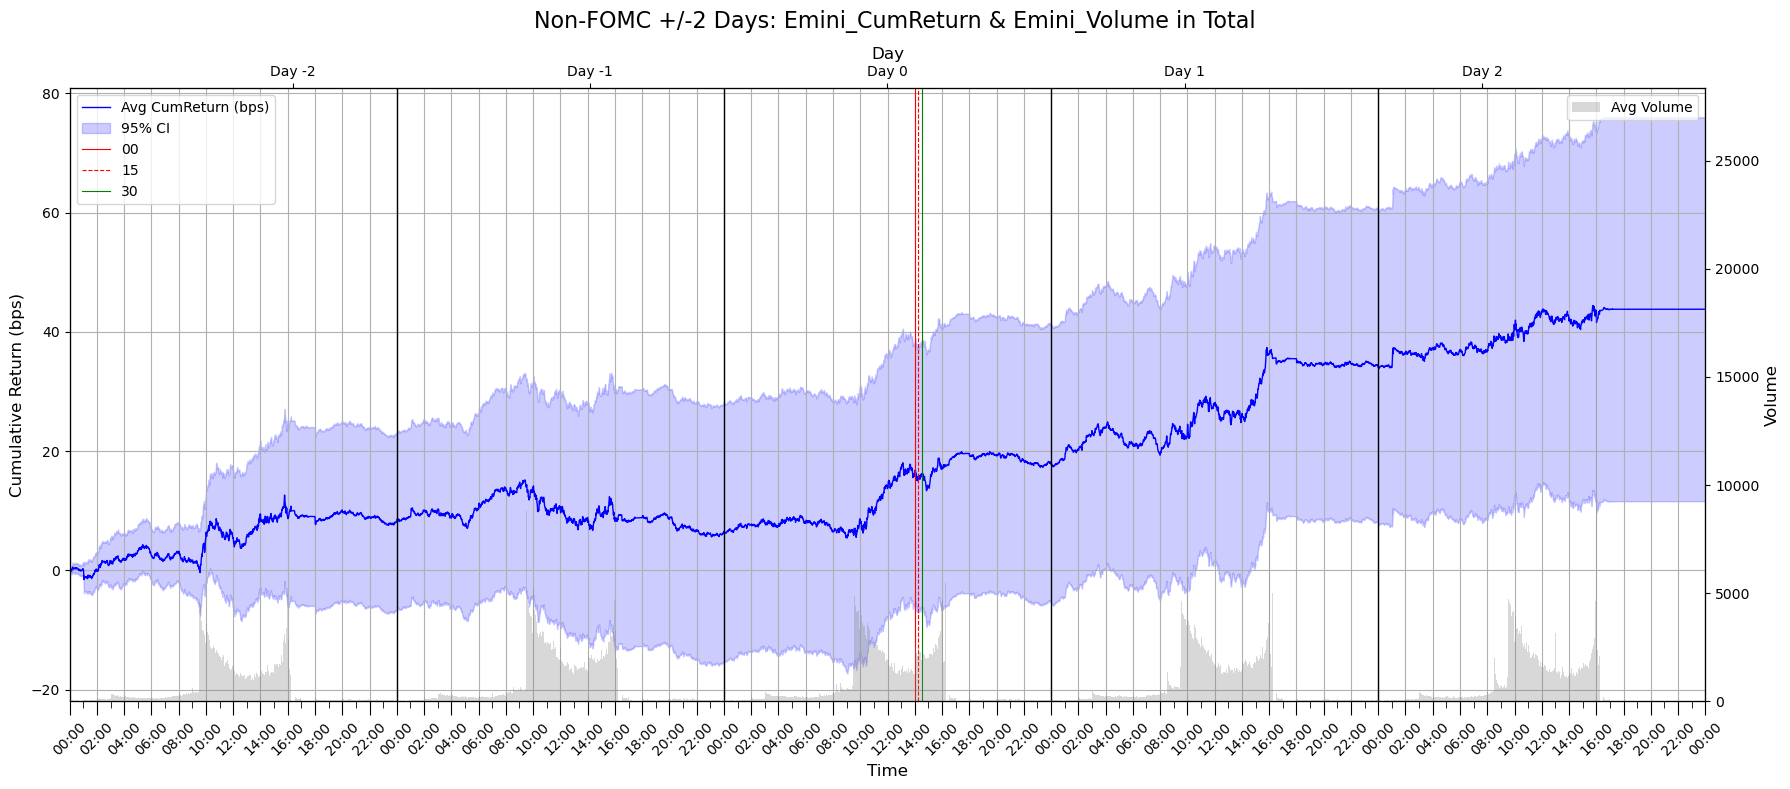

Saved CR table: ..\data\Emini\nonfomc\nonfomc_Emini_in_2_cr_Total.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\1330121967.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\1330121967.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k2_Total.xlsx
Saved LaTeX bundle: ..\data\Emini\nonfomc\latex\nonfomc_Total.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\1330121967.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\1330121967.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved extras (Count) workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k2_Total_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\nonfomc\latex\nonfomc_Total_Count.tex


{'figure_path': WindowsPath('../data/Emini/nonfomc/nonfomc_fomc_window_k2_Total.png'),
 'cr_table_path': WindowsPath('../data/Emini/nonfomc/nonfomc_Emini_in_2_cr_Total.csv'),
 'daily_summary': {'table':                      FOMC_week_Day (-2)                                     \
                                     Mean        St. Dev       P25       P50   
  Avg Daily Volume          933150.588785  797218.617167  35857.75  953173.0   
  Diff_Vol (Ann - Day)      255129.733645            NaN       NaN       NaN   
  # Obs                        214.000000            NaN       NaN       NaN   
  
                                           FOMC_week_Day (-1)                 \
                               P75 No. Obs               Mean        St. Dev   
  Avg Daily Volume      1458499.25   214.0       1.204335e+06  880674.580305   
  Diff_Vol (Ann - Day)         NaN     NaN      -1.605438e+04            NaN   
  # Obs                        NaN     NaN       2.140000e+02            NaN

In [79]:
plot_fomc_k_window_enhanced(
    hft_input=emini_full,
    fomc_input=non_fomc_data,
    k=2,
    asset='Emini',
    period='Total',
    extra_metrics={'Count': 'Emini_Count'},
    fomc_type='nonfomc'
)

Skipping fomc event at 1997-08-19 14:15:00: no market data in +/-2 day window.
Skipping fomc event at 1997-07-02 14:15:00: no market data in +/-2 day window.
Skipping fomc event at 1997-05-20 14:15:00: no market data in +/-2 day window.
Skipping fomc event at 1997-03-25 14:15:00: no market data in +/-2 day window.
Skipping fomc event at 1997-02-05 14:15:00: no market data in +/-2 day window.
Skipping fomc event at 1996-12-17 14:15:00: no market data in +/-2 day window.
Skipping fomc event at 1996-11-13 14:15:00: no market data in +/-2 day window.
Skipping fomc event at 1996-09-24 14:15:00: no market data in +/-2 day window.
Skipping fomc event at 1996-08-20 14:15:00: no market data in +/-2 day window.
Skipping fomc event at 1996-07-03 14:15:00: no market data in +/-2 day window.
Skipping fomc event at 1996-05-21 14:15:00: no market data in +/-2 day window.
Skipping fomc event at 1996-03-26 11:39:00: no market data in +/-2 day window.
Skipping fomc event at 1996-01-31 14:15:00: no marke

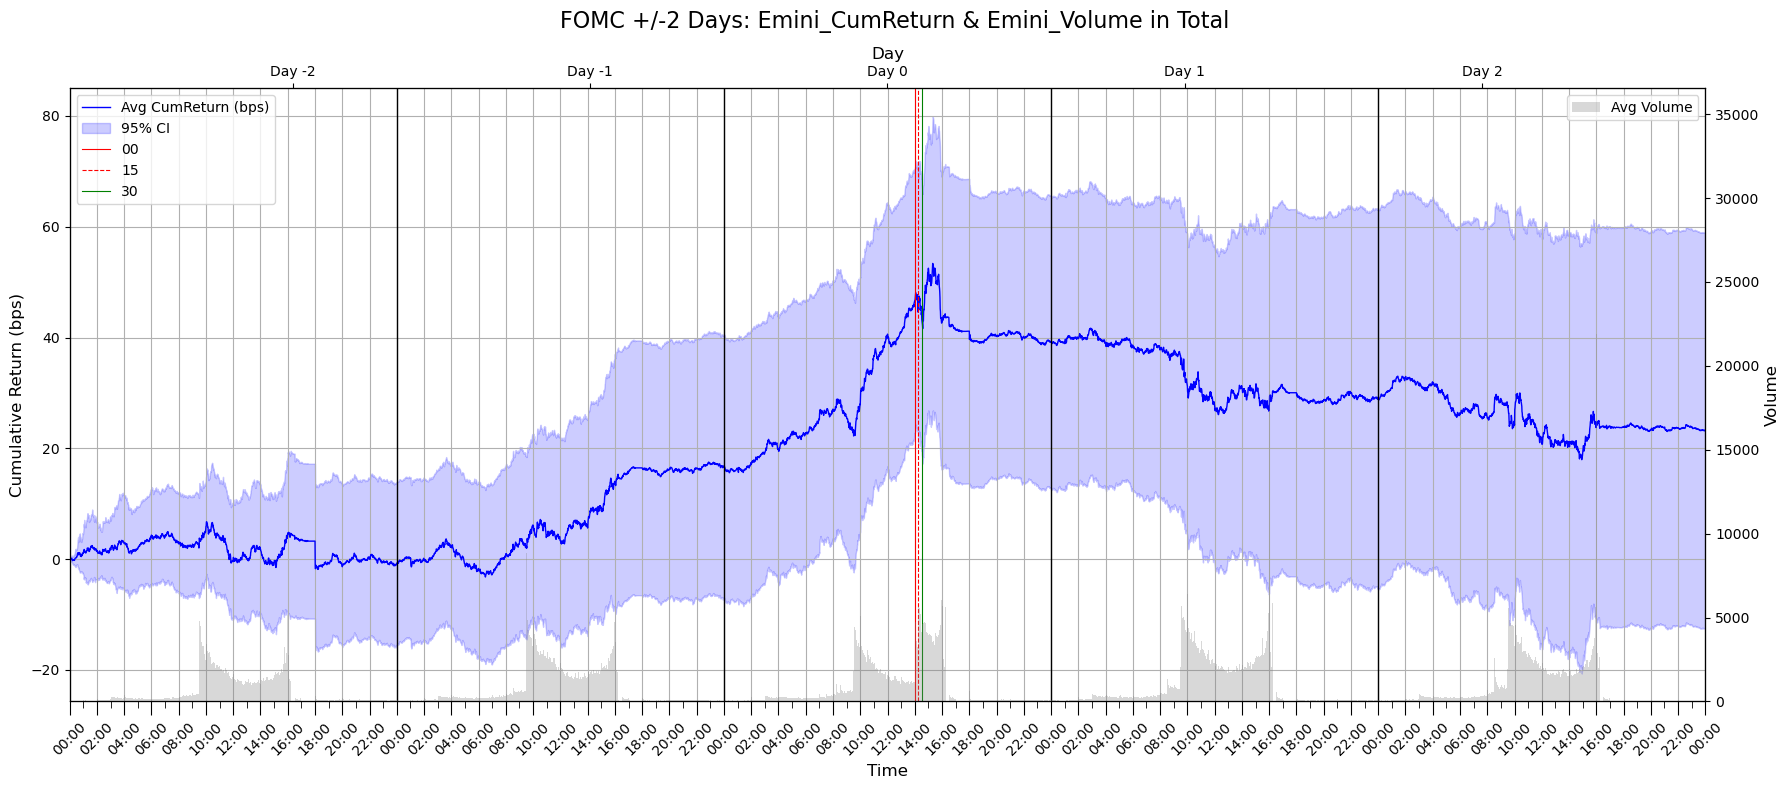

Saved CR table: ..\data\Emini\Emini_in_2_cr_Total.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\1330121967.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\1330121967.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved boxpairs:
  ..\data\Emini\boxplots\Emini_k2_Total_boxpair_daily.png
  ..\data\Emini\boxplots\Emini_k2_Total_boxpair_intraday.png
Saved summary workbook: ..\data\Emini\Emini_k2_Total.xlsx
Saved LaTeX bundle: ..\data\Emini\latex\Total.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\1330121967.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\1330121967.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved extras (Count) workbook: ..\data\Emini\Emini_k2_Total_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\latex\Total_Count.tex


{'figure_path': WindowsPath('../data/Emini/fomc_window_k2_Total.png'),
 'cr_table_path': WindowsPath('../data/Emini/Emini_in_2_cr_Total.csv'),
 'daily_summary': {'table':                      FOMC_week_Day (-2)                                    \
                                     Mean        St. Dev     P25        P50   
  Avg Daily Volume          898789.610860  864606.358945  2468.0  1002885.0   
  Diff_Vol (Ann - Day)      430664.479638            NaN     NaN        NaN   
  # Obs                        221.000000            NaN     NaN        NaN   
  
                                          FOMC_week_Day (-1)                 \
                              P75 No. Obs               Mean        St. Dev   
  Avg Daily Volume      1406731.0   221.0       1.157603e+06  956073.811522   
  Diff_Vol (Ann - Day)        NaN     NaN       1.718509e+05            NaN   
  # Obs                       NaN     NaN       2.210000e+02            NaN   
  
                                   

In [80]:
plot_fomc_k_window_enhanced(
    hft_input=emini_full,
    fomc_input=fomc_data,
    k=2,
    asset='Emini',
    period='Total',
    extra_metrics={'Count': 'Emini_Count'},
    fomc_type='fomc'
)

##  Summary Tables ##

In [26]:
# Aggregate summary tables across assets

def load_asset_tables(asset, period='Total', k=2):
    safe_period = str(period).replace(' ', '_')
    excel_path = DATA_ROOT / asset / f'{asset}_k{k}_{safe_period}.xlsx'
    if not excel_path.exists():
        raise FileNotFoundError(f"Summary workbook not found: {excel_path}")
    daily = pd.read_excel(excel_path, sheet_name='daily volume', header=[0, 1], index_col=0)
    intraday = pd.read_excel(excel_path, sheet_name='intraday volume', header=[0, 1], index_col=0)
    daily.index.name = 'Statistic'
    intraday.index.name = 'Statistic'
    return daily, intraday

def aggregate_assets(assets, period='Total', k=2):
    daily_tables = []
    intraday_tables = []
    for asset in assets:
        daily, intraday = load_asset_tables(asset, period=period, k=k)
        daily_tables.append(daily)
        intraday_tables.append(intraday)
    daily_panel = pd.concat(daily_tables, keys=assets, names=['Asset', 'Statistic'])
    intraday_panel = pd.concat(intraday_tables, keys=assets, names=['Asset', 'Statistic'])
    return daily_panel, intraday_panel

bond_assets = ['FF1', 'FF2', 'ED2', 'ED3', 'ED4', '2yr', '5yr', '10yr']
emini_assets = ['Emini']

bond_daily_total, bond_intraday_total = aggregate_assets(bond_assets, period='Total', k=2)
emini_daily_total, emini_intraday_total = aggregate_assets(emini_assets, period='Total', k=2)

table1 = pd.concat(
    {
        'Panel A (Bond Futures)': bond_daily_total,
        'Panel B (E-mini Futures)': emini_daily_total,
    },
    names=['Panel', 'Asset', 'Statistic'],
)

table2 = pd.concat(
    {
        'Panel A (Bond Futures)': bond_intraday_total,
        'Panel B (E-mini Futures)': emini_intraday_total,
    },
    names=['Panel', 'Asset', 'Statistic'],
)

summary_dir = DATA_ROOT / 'summary_tables'
summary_dir.mkdir(parents=True, exist_ok=True)

table1_path = summary_dir / 'Table1_daily_volume_total.xlsx'
table2_path = summary_dir / 'Table2_intraday_volume_total.xlsx'

table1.to_excel(table1_path)
table2.to_excel(table2_path)

periods = ['Pre-ZLB', 'ZLB', 'Post-ZLB']
table3_daily = {}
table3_intraday = {}

for period in periods:
    bond_daily_p, bond_intraday_p = aggregate_assets(bond_assets, period=period, k=2)
    emini_daily_p, emini_intraday_p = aggregate_assets(emini_assets, period=period, k=2)
    table3_daily[period] = pd.concat(
        {
            'Panel A (Bond Futures)': bond_daily_p,
            'Panel B (E-mini Futures)': emini_daily_p,
        },
        names=['Panel', 'Asset', 'Statistic'],
    )
    table3_intraday[period] = pd.concat(
        {
            'Panel A (Bond Futures)': bond_intraday_p,
            'Panel B (E-mini Futures)': emini_intraday_p,
        },
        names=['Panel', 'Asset', 'Statistic'],
    )

with pd.ExcelWriter(summary_dir / 'Table3_volume_by_period.xlsx') as writer:
    for period in periods:
        table3_daily[period].to_excel(writer, sheet_name=f'{period}_daily')
        table3_intraday[period].to_excel(writer, sheet_name=f'{period}_intraday')

print('Table1 saved to', table1_path)
print('Table2 saved to', table2_path)
print('Table3 workbook saved to', summary_dir / 'Table3_volume_by_period.xlsx')



Table1 saved to ..\data\summary_tables\Table1_daily_volume_total.xlsx
Table2 saved to ..\data\summary_tables\Table2_intraday_volume_total.xlsx
Table3 workbook saved to ..\data\summary_tables\Table3_volume_by_period.xlsx


In [27]:

# Individual Tables and Latex
def flatten_for_output(table):
    df = table.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [' '.join(str(part) for part in col if str(part) != '') for col in df.columns.to_flat_index()]
    else:
        df.columns = [str(col) for col in df.columns]
    df = df.reset_index()
    df.columns = [str(col) for col in df.columns]
    return df

def export_table(table, subdir, basename, caption):
    out_dir = OUTPUT_ROOT / subdir
    out_dir.mkdir(parents=True, exist_ok=True)
    flat = flatten_for_output(table)
    excel_path = out_dir / f"{basename}.xlsx"
    flat.to_excel(excel_path, index=False)

    latex_df = flat.copy()
    numeric_cols = latex_df.select_dtypes(include='number').columns
    latex_df[numeric_cols] = latex_df[numeric_cols].applymap(lambda x: f"{x:,.3f}")
    latex_body = latex_df.to_latex(index=False, escape=False)
    latex_lines = [
        r"\begin{table}[!htbp]\centering",
        f"\caption{{{caption}}}",
        r"\small",
        latex_body,
        r"\end{table}",
    ]
    latex_content = "\n".join(latex_lines)

    latex_path = out_dir / f"{basename}.tex"
    latex_path.write_text(latex_content, encoding='utf-8')
    print('Saved', excel_path)
    print('Saved', latex_path)

export_table(table1, 'table1', 'Table1_daily_volume_total', 'Daily volume around FOMC (Total period)')
export_table(table2, 'table2', 'Table2_intraday_volume_total', 'Intraday volume around FOMC (Total period)')

periods = ['Pre-ZLB', 'ZLB', 'Post-ZLB']
for period in periods:
    export_table(
        table3_daily[period],
        'table3',
        f'Table3_{period}_daily_volume',
        f'Daily volume around FOMC ({period})'
    )
    export_table(
        table3_intraday[period],
        'table3',
        f'Table3_{period}_intraday_volume',
        f'Intraday volume around FOMC ({period})'
    )


Saved ..\output\table1\Table1_daily_volume_total.xlsx
Saved ..\output\table1\Table1_daily_volume_total.tex
Saved ..\output\table2\Table2_intraday_volume_total.xlsx
Saved ..\output\table2\Table2_intraday_volume_total.tex
Saved ..\output\table3\Table3_Pre-ZLB_daily_volume.xlsx
Saved ..\output\table3\Table3_Pre-ZLB_daily_volume.tex
Saved ..\output\table3\Table3_Pre-ZLB_intraday_volume.xlsx
Saved ..\output\table3\Table3_Pre-ZLB_intraday_volume.tex


<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\4175188649.py:25: SyntaxWarning: invalid escape sequence '\c'
  f"\caption{{{caption}}}",
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\4175188649.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_df[numeric_cols] = latex_df[numeric_cols].applymap(lambda x: f"{x:,.3f}")
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\4175188649.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_df[numeric_cols] = latex_df[numeric_cols].applymap(lambda x: f"{x:,.3f}")
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\4175188649.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_df[numeric_cols] = latex_df[numeric_cols].applymap(lambda x: f"{x:,.3f}")
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\4175188649.p

Saved ..\output\table3\Table3_ZLB_daily_volume.xlsx
Saved ..\output\table3\Table3_ZLB_daily_volume.tex
Saved ..\output\table3\Table3_ZLB_intraday_volume.xlsx
Saved ..\output\table3\Table3_ZLB_intraday_volume.tex
Saved ..\output\table3\Table3_Post-ZLB_daily_volume.xlsx
Saved ..\output\table3\Table3_Post-ZLB_daily_volume.tex
Saved ..\output\table3\Table3_Post-ZLB_intraday_volume.xlsx
Saved ..\output\table3\Table3_Post-ZLB_intraday_volume.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\4175188649.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_df[numeric_cols] = latex_df[numeric_cols].applymap(lambda x: f"{x:,.3f}")
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\4175188649.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_df[numeric_cols] = latex_df[numeric_cols].applymap(lambda x: f"{x:,.3f}")
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\4175188649.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_df[numeric_cols] = latex_df[numeric_cols].applymap(lambda x: f"{x:,.3f}")


##  Stacked Plots ##

In [28]:
def plot_fomc_stacked_by_period_enhanced(asset='', k=1, hft_sets=None, fomc_sets=None, 
                                        extra_metrics=None, fomc_type='fomc'):
    """增强版按时期分析函数"""
    if fomc_type == 'fomc':
        default_hft_sets = {
            'Pre-ZLB': pre_zlb_hft,
            'ZLB': zlb_hft,
            'Post-ZLB': post_zlb_hft,
        }
        default_fomc_sets = {
            'Pre-ZLB': pre_zlb_fomc,
            'ZLB': zlb_fomc,
            'Post-ZLB': post_zlb_fomc,
        }
    else:  # nonfomc
        default_hft_sets = {
            'Pre-ZLB': pre_zlb_hft,
            'ZLB': zlb_hft,
            'Post-ZLB': post_zlb_hft,
        }
        default_fomc_sets = {
            'Pre-ZLB': pre_zlb_non_fomc,
            'ZLB': zlb_non_fomc,
            'Post-ZLB': post_zlb_non_fomc,
        }
    
    hft_map = hft_sets or default_hft_sets
    fomc_map = fomc_sets or default_fomc_sets

    results = {}
    for label, hft_df in hft_map.items():
        fomc_df = fomc_map.get(label, fomc_data if fomc_type == 'fomc' else non_fomc_data)
        res = plot_fomc_k_window_enhanced(
            hft_input=hft_df,
            fomc_input=fomc_df,
            k=k,
            asset=asset,
            period=label,
            extra_metrics=extra_metrics,
            fomc_type=fomc_type,
        )
        results[label] = res
    return results

### Glitches ###

### ========== Periodic Price/Volume Report ==========
We have 
Pre-ZLB, ZLB, Post-ZLB
Then run：
```python
plot_fomc_stacked_by_period('FF1', k=1)
```


Skipping fomc event at 1997-08-19 14:15:00: no market data in +/-0 day window.
Skipping fomc event at 1997-07-02 14:15:00: no market data in +/-0 day window.
Skipping fomc event at 1997-05-20 14:15:00: no market data in +/-0 day window.
Skipping fomc event at 1997-03-25 14:15:00: no market data in +/-0 day window.
Skipping fomc event at 1997-02-05 14:15:00: no market data in +/-0 day window.
Skipping fomc event at 1996-12-17 14:15:00: no market data in +/-0 day window.
Skipping fomc event at 1996-11-13 14:15:00: no market data in +/-0 day window.
Skipping fomc event at 1996-09-24 14:15:00: no market data in +/-0 day window.
Skipping fomc event at 1996-08-20 14:15:00: no market data in +/-0 day window.
Skipping fomc event at 1996-07-03 14:15:00: no market data in +/-0 day window.
Skipping fomc event at 1996-05-21 14:15:00: no market data in +/-0 day window.
Skipping fomc event at 1996-03-26 11:39:00: no market data in +/-0 day window.
Skipping fomc event at 1996-01-31 14:15:00: no marke

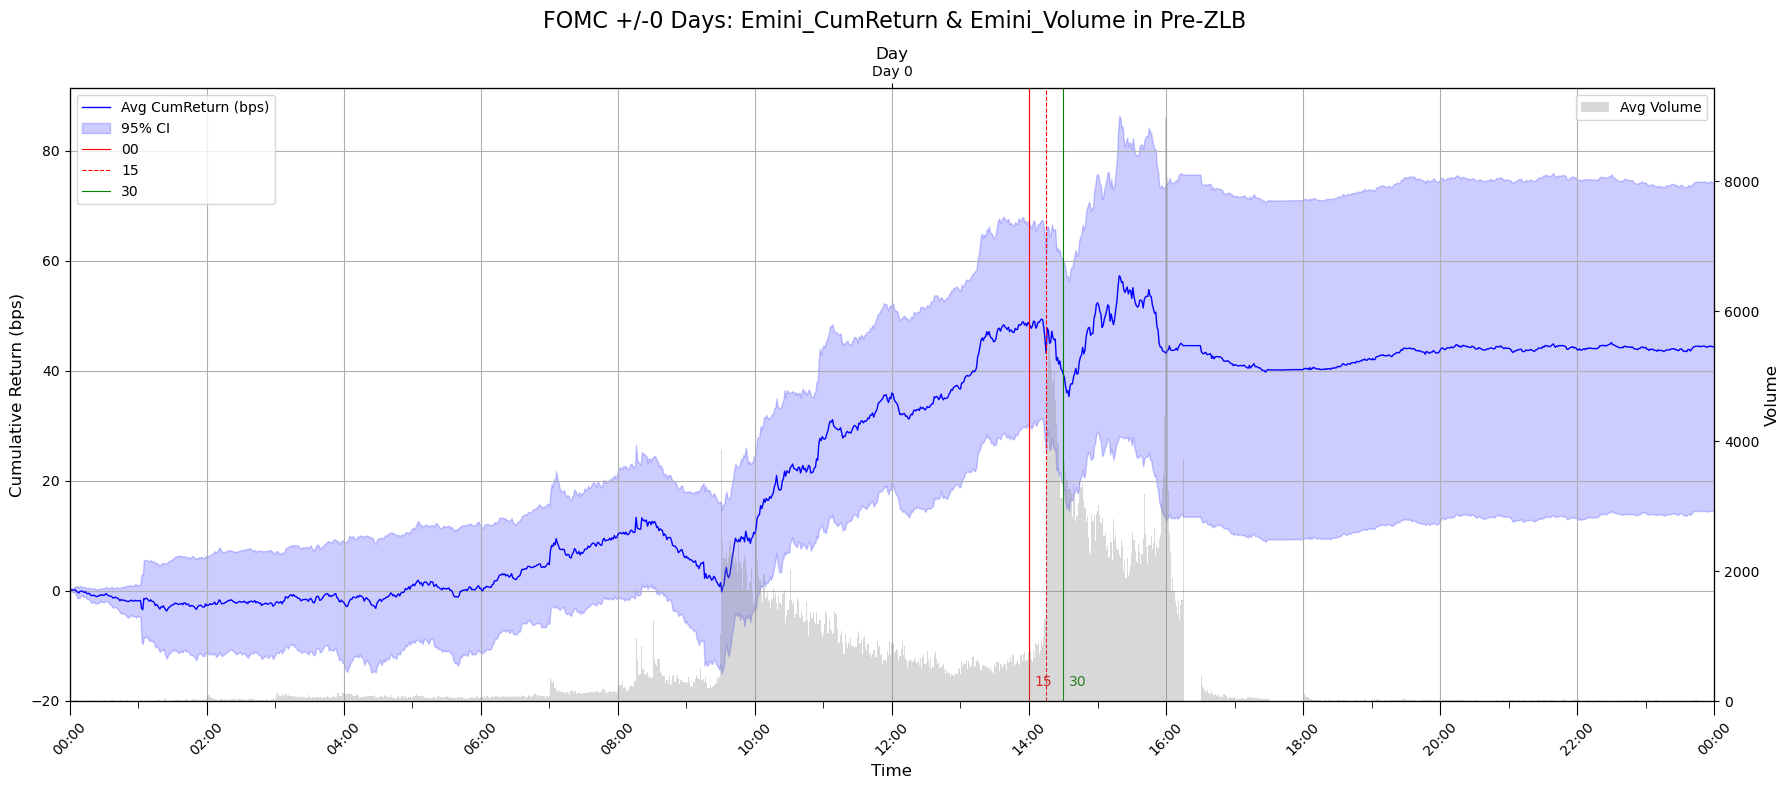

Saved CR table: ..\data\Emini\Emini_in_0_cr_Pre-ZLB.csv
Saved summary workbook: ..\data\Emini\Emini_k0_Pre-ZLB.xlsx
Saved LaTeX bundle: ..\data\Emini\latex\Pre-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify fu

Saved extras (Count) workbook: ..\data\Emini\Emini_k0_Pre-ZLB_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\latex\Pre-ZLB_Count.tex
Saved figure: ..\data\Emini\fomc_window_k0_ZLB.png


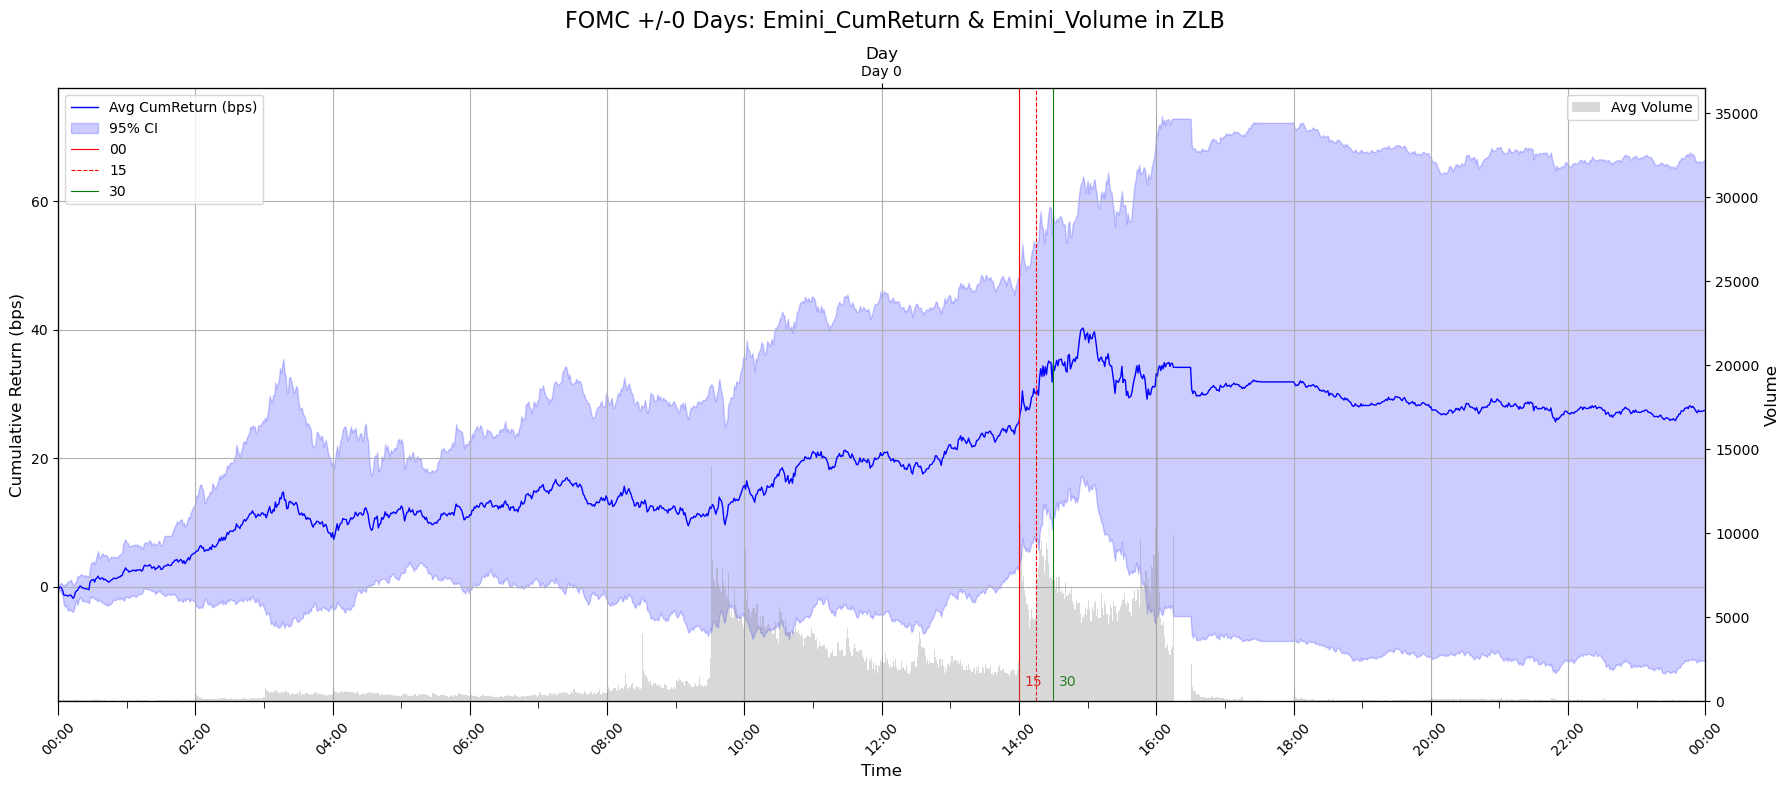

Saved CR table: ..\data\Emini\Emini_in_0_cr_ZLB.csv
Saved summary workbook: ..\data\Emini\Emini_k0_ZLB.xlsx
Saved LaTeX bundle: ..\data\Emini\latex\ZLB.tex
Saved extras (Count) workbook: ..\data\Emini\Emini_k0_ZLB_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\latex\ZLB_Count.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify fu

Skipping fomc event at 2020-03-15 14:00:00: excessive intraday gaps on ['2020-03-15'] (>20 minutes missing in a day) within +/-0 days.
Saved figure: ..\data\Emini\fomc_window_k0_Post-ZLB.png


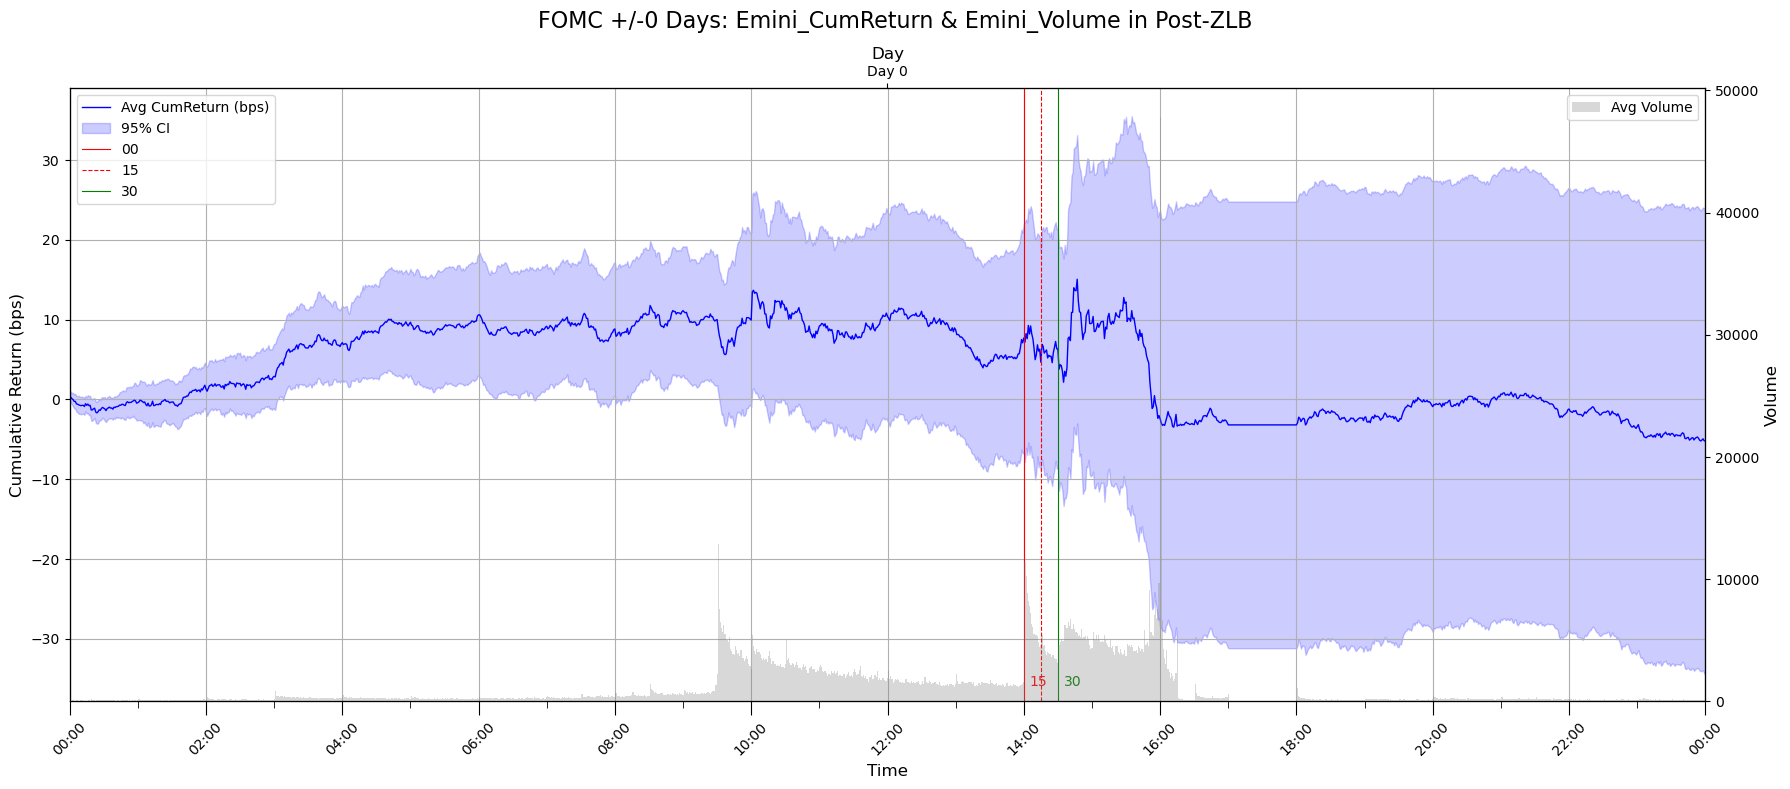

Saved CR table: ..\data\Emini\Emini_in_0_cr_Post-ZLB.csv
Saved summary workbook: ..\data\Emini\Emini_k0_Post-ZLB.xlsx
Saved LaTeX bundle: ..\data\Emini\latex\Post-ZLB.tex
Saved extras (Count) workbook: ..\data\Emini\Emini_k0_Post-ZLB_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\latex\Post-ZLB_Count.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify fu

{'Pre-ZLB': {'figure_path': WindowsPath('../data/Emini/fomc_window_k0_Pre-ZLB.png'),
  'cr_table_path': WindowsPath('../data/Emini/Emini_in_0_cr_Pre-ZLB.csv'),
  'daily_summary': {'table':                      FOMC_week_Day (-2)                              \
                                      Mean St. Dev P25 P50 P75 No. Obs   
   Avg Daily Volume                    NaN     NaN NaN NaN NaN     0.0   
   Diff_Vol (Ann - Day)                NaN     NaN NaN NaN NaN     NaN   
   # Obs                               0.0     NaN NaN NaN NaN     NaN   
   
                        FOMC_week_Day (-1)                  ...  \
                                      Mean St. Dev P25 P50  ...   
   Avg Daily Volume                    NaN     NaN NaN NaN  ...   
   Diff_Vol (Ann - Day)                NaN     NaN NaN NaN  ...   
   # Obs                               0.0     NaN NaN NaN  ...   
   
                        FOMC_week_Day (+1)                 FOMC_week_Day (+2)  \
                    

In [29]:
plot_fomc_stacked_by_period_enhanced(
    asset='Emini',
    k=0,
    hft_sets={
        'Pre-ZLB': pre_zlb_emini,
        'ZLB': zlb_emini,
        'Post-ZLB': post_zlb_emini,
    },
    fomc_sets={
        'Pre-ZLB': pre_zlb_fomc,
        'ZLB': zlb_fomc,
        'Post-ZLB': post_zlb_fomc,
    },
    extra_metrics={'Count': 'Emini_Count'},
)


Skipping nonfomc event at 1991-02-27 14:15:00: no market data in +/-0 day window.
Skipping nonfomc event at 1991-03-20 14:15:00: no market data in +/-0 day window.
Skipping nonfomc event at 1991-04-17 14:15:00: no market data in +/-0 day window.
Skipping nonfomc event at 1991-05-08 14:15:00: no market data in +/-0 day window.
Skipping nonfomc event at 1991-06-12 14:15:00: no market data in +/-0 day window.
Skipping nonfomc event at 1991-07-24 14:15:00: no market data in +/-0 day window.
Skipping nonfomc event at 1991-08-14 14:15:00: no market data in +/-0 day window.
Skipping nonfomc event at 1991-09-04 14:15:00: no market data in +/-0 day window.
Skipping nonfomc event at 1991-09-25 14:15:00: no market data in +/-0 day window.
Skipping nonfomc event at 1991-10-16 14:15:00: no market data in +/-0 day window.
Skipping nonfomc event at 1991-11-27 14:15:00: no market data in +/-0 day window.
Skipping nonfomc event at 1992-01-15 14:15:00: no market data in +/-0 day window.
Skipping nonfomc

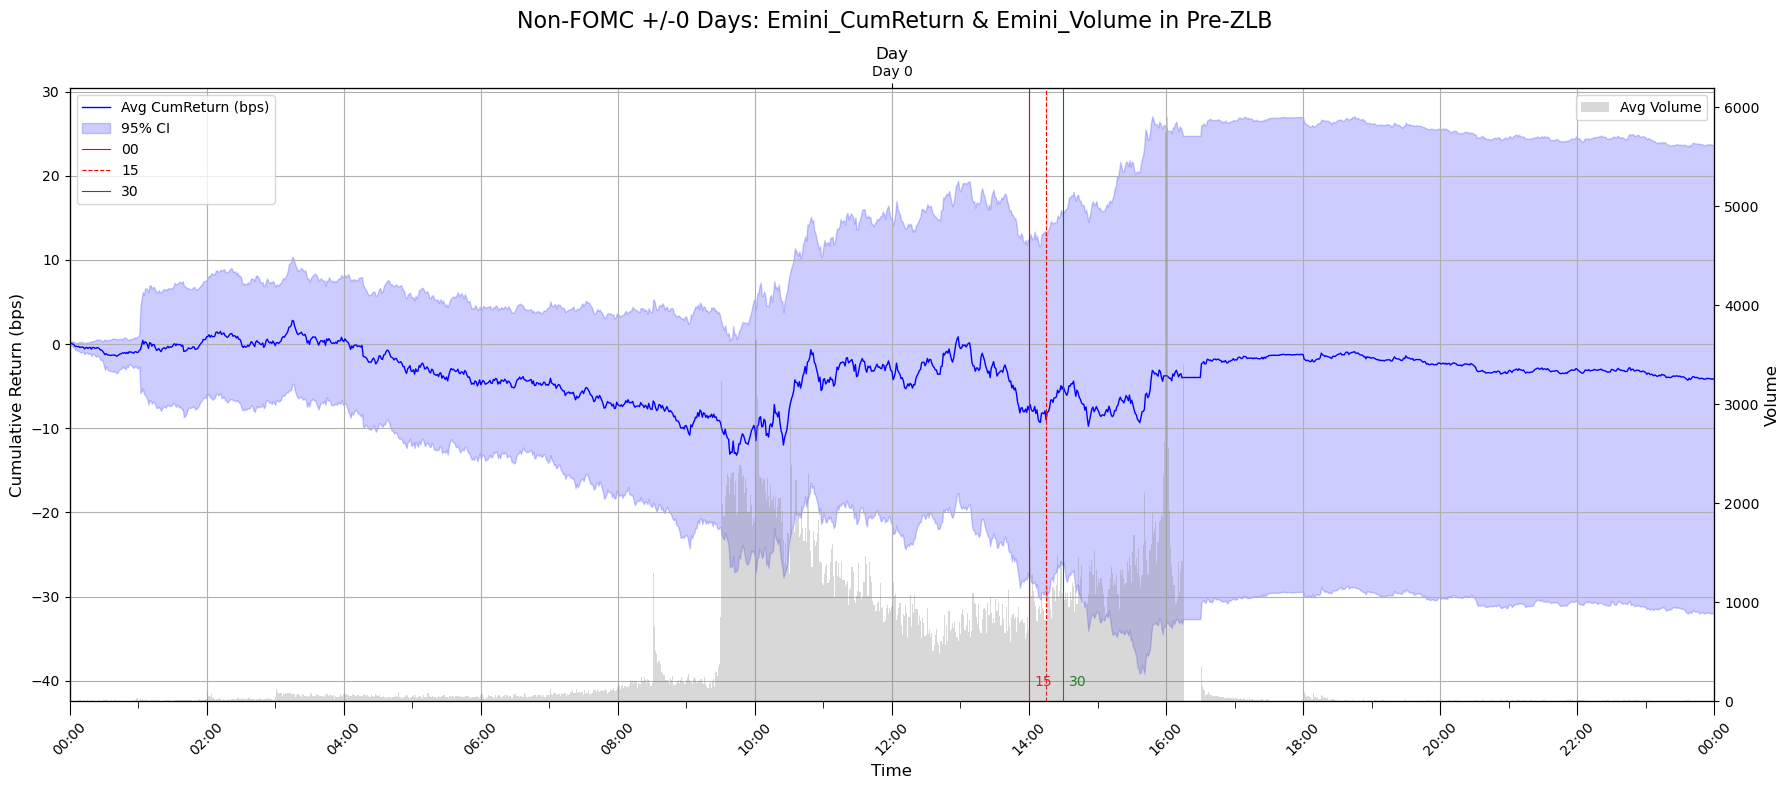

Saved CR table: ..\data\Emini\nonfomc\nonfomc_Emini_in_0_cr_Pre-ZLB.csv
Saved summary workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k0_Pre-ZLB.xlsx
Saved LaTeX bundle: ..\data\Emini\nonfomc\latex\nonfomc_Pre-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify fu

Saved extras (Count) workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k0_Pre-ZLB_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\nonfomc\latex\nonfomc_Pre-ZLB_Count.tex
Saved figure: ..\data\Emini\nonfomc\nonfomc_fomc_window_k0_ZLB.png


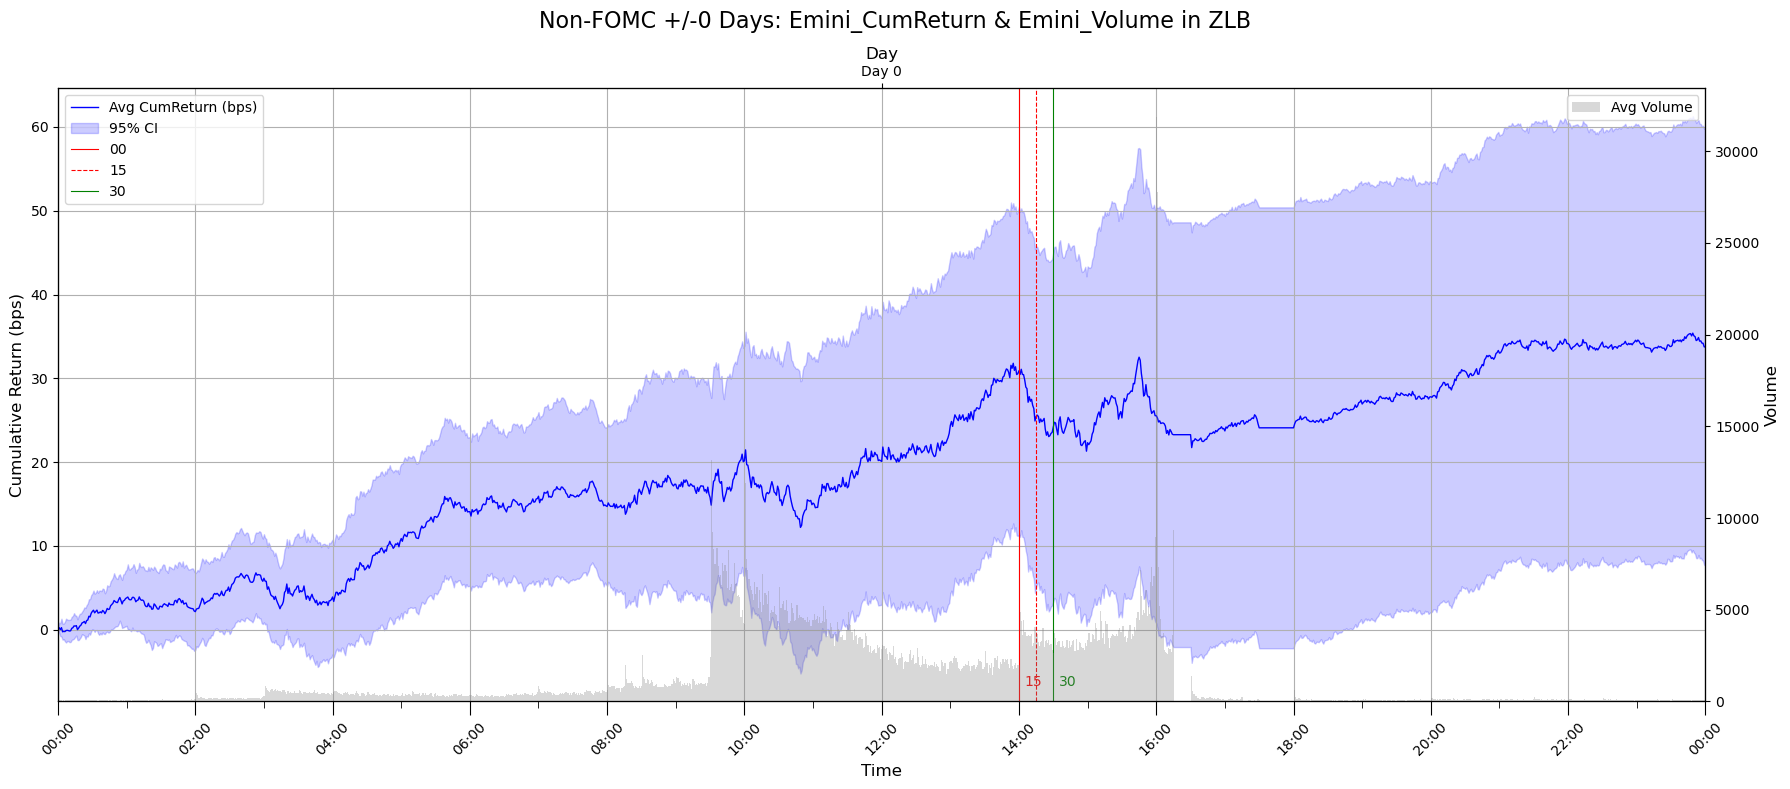

Saved CR table: ..\data\Emini\nonfomc\nonfomc_Emini_in_0_cr_ZLB.csv
Saved summary workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k0_ZLB.xlsx
Saved LaTeX bundle: ..\data\Emini\nonfomc\latex\nonfomc_ZLB.tex
Saved extras (Count) workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k0_ZLB_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\nonfomc\latex\nonfomc_ZLB_Count.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify fu

Saved figure: ..\data\Emini\nonfomc\nonfomc_fomc_window_k0_Post-ZLB.png


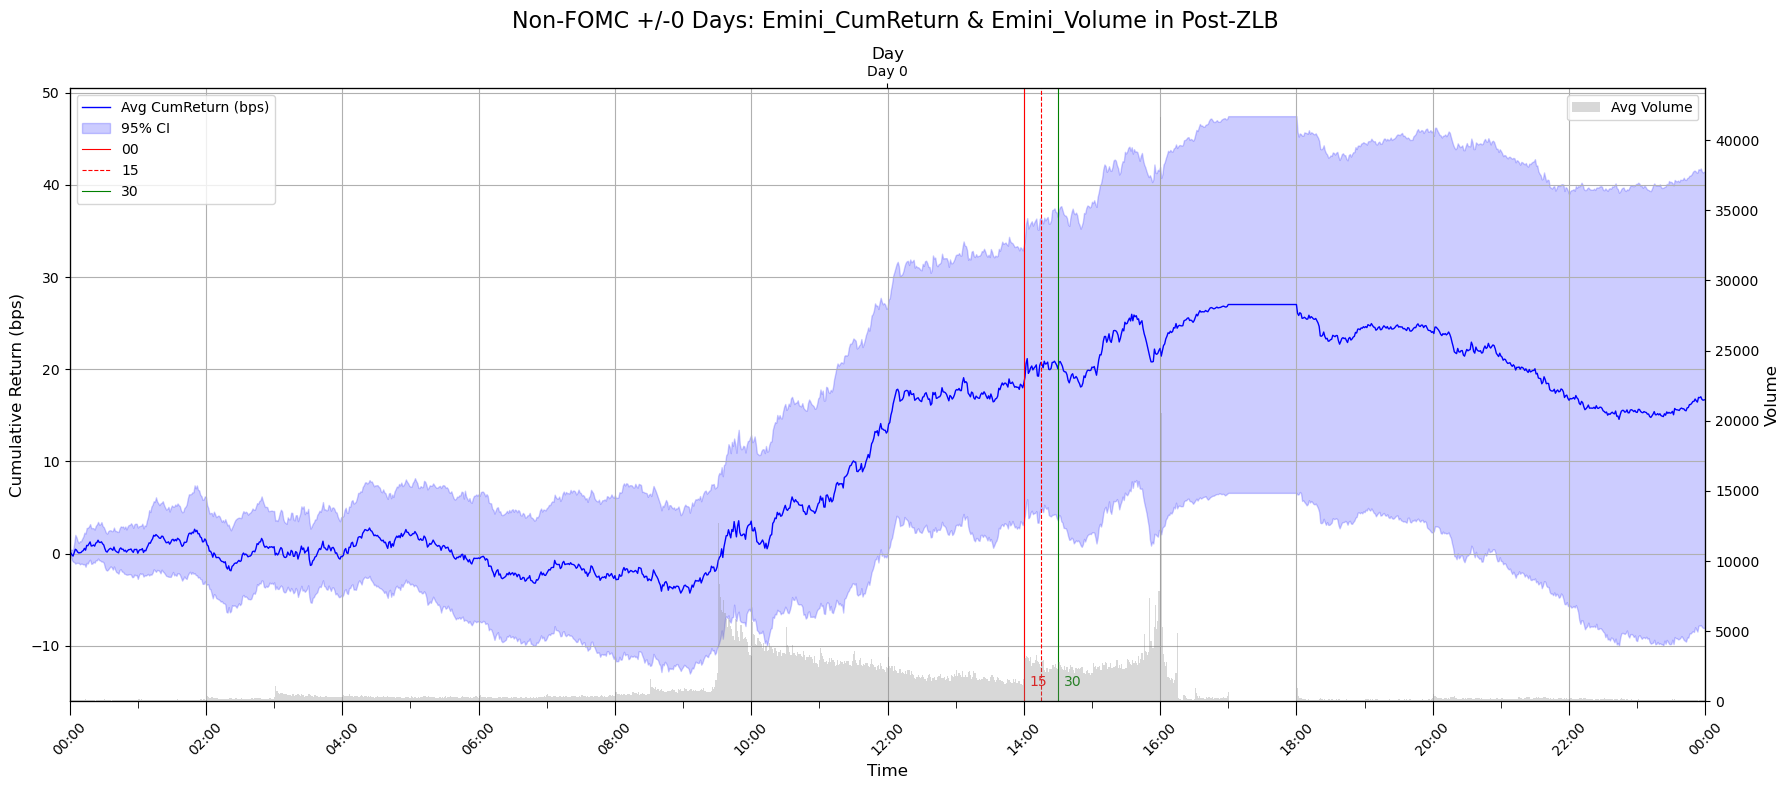

Saved CR table: ..\data\Emini\nonfomc\nonfomc_Emini_in_0_cr_Post-ZLB.csv
Saved summary workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k0_Post-ZLB.xlsx
Saved LaTeX bundle: ..\data\Emini\nonfomc\latex\nonfomc_Post-ZLB.tex
Saved extras (Count) workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k0_Post-ZLB_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\nonfomc\latex\nonfomc_Post-ZLB_Count.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify fu

{'Pre-ZLB': {'figure_path': WindowsPath('../data/Emini/nonfomc/nonfomc_fomc_window_k0_Pre-ZLB.png'),
  'cr_table_path': WindowsPath('../data/Emini/nonfomc/nonfomc_Emini_in_0_cr_Pre-ZLB.csv'),
  'daily_summary': {'table':                      FOMC_week_Day (-2)                              \
                                      Mean St. Dev P25 P50 P75 No. Obs   
   Avg Daily Volume                    NaN     NaN NaN NaN NaN     0.0   
   Diff_Vol (Ann - Day)                NaN     NaN NaN NaN NaN     NaN   
   # Obs                               0.0     NaN NaN NaN NaN     NaN   
   
                        FOMC_week_Day (-1)                  ...  \
                                      Mean St. Dev P25 P50  ...   
   Avg Daily Volume                    NaN     NaN NaN NaN  ...   
   Diff_Vol (Ann - Day)                NaN     NaN NaN NaN  ...   
   # Obs                               0.0     NaN NaN NaN  ...   
   
                        FOMC_week_Day (+1)                 FOMC_week_

In [30]:
plot_fomc_stacked_by_period_enhanced(
    asset='Emini',
    k=0,
    hft_sets={
        'Pre-ZLB': pre_zlb_emini,
        'ZLB': zlb_emini,
        'Post-ZLB': post_zlb_emini,
    },
    fomc_sets={
        'Pre-ZLB': pre_zlb_non_fomc,
        'ZLB': zlb_non_fomc,
        'Post-ZLB': post_zlb_non_fomc,
    },
    extra_metrics={'Count': 'Emini_Count'},
    fomc_type='nonfomc'
)


Skipping fomc event at 2008-12-16 14:15:00: excessive intraday gaps on ['2008-12-14'] (>20 minutes missing in a day) within +/-2 days.
Skipping fomc event at 2008-09-16 14:15:00: excessive intraday gaps on ['2008-09-14'] (>20 minutes missing in a day) within +/-2 days.
Skipping fomc event at 2008-08-05 14:15:00: excessive intraday gaps on ['2008-08-03'] (>20 minutes missing in a day) within +/-2 days.
Skipping fomc event at 2008-03-18 14:15:00: excessive intraday gaps on ['2008-03-16'] (>20 minutes missing in a day) within +/-2 days.
Skipping fomc event at 2008-01-22 08:30:00: excessive intraday gaps on ['2008-01-20'] (>20 minutes missing in a day) within +/-2 days.
Skipping fomc event at 2007-12-11 14:15:00: excessive intraday gaps on ['2007-12-09'] (>20 minutes missing in a day) within +/-2 days.
Skipping fomc event at 2007-09-18 14:15:00: excessive intraday gaps on ['2007-09-16'] (>20 minutes missing in a day) within +/-2 days.
Skipping fomc event at 2007-08-17 08:00:00: whole-day m

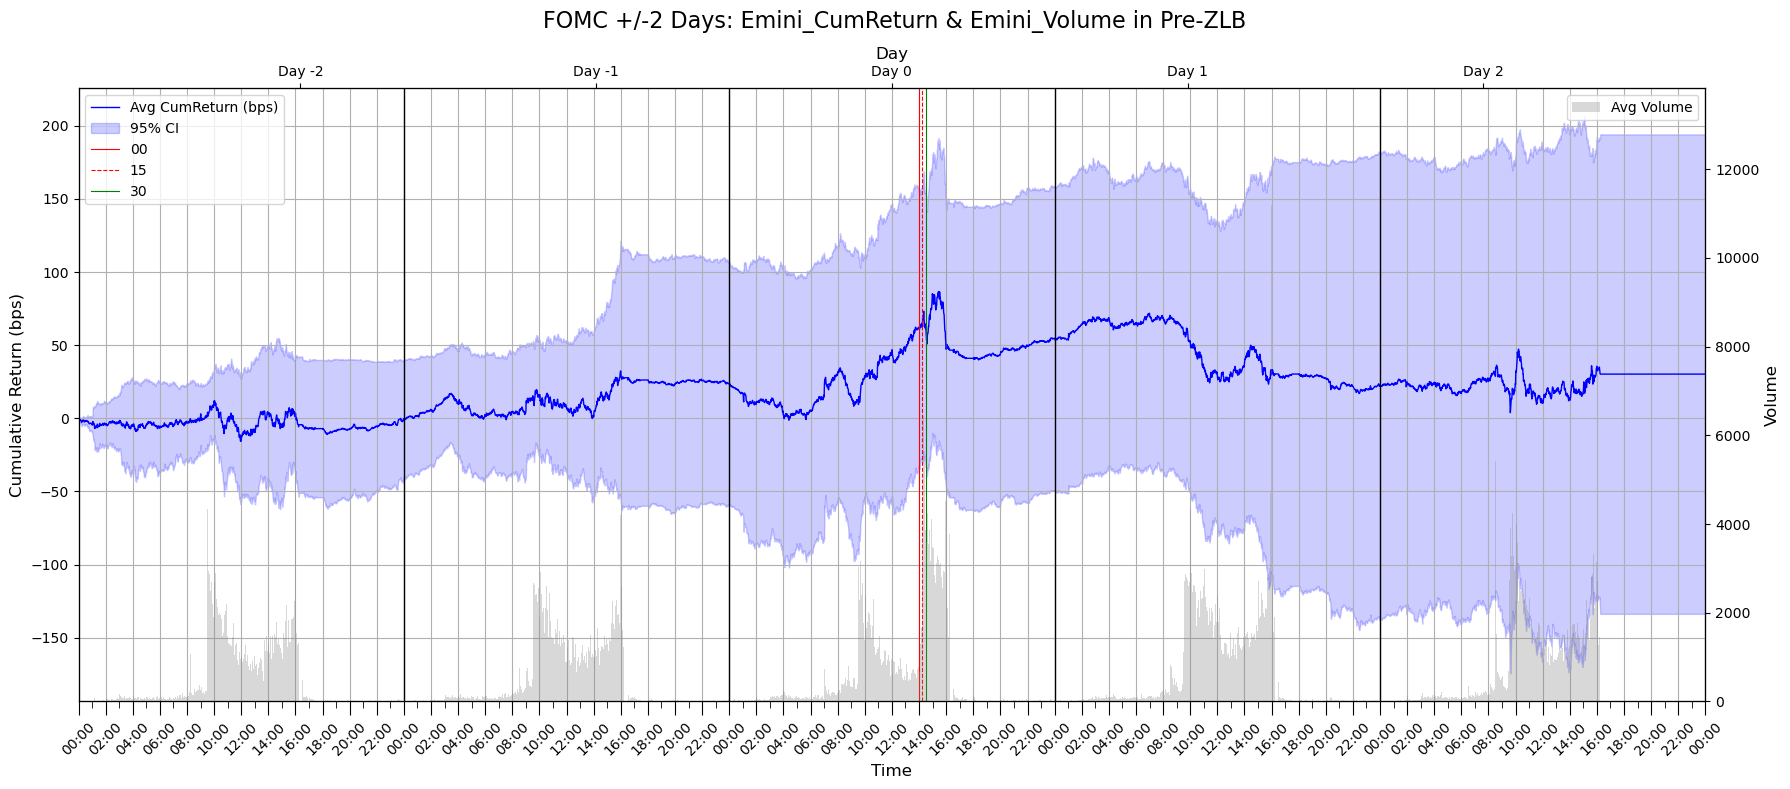

Saved CR table: ..\data\Emini\Emini_in_2_cr_Pre-ZLB.csv
Saved summary workbook: ..\data\Emini\Emini_k2_Pre-ZLB.xlsx
Saved LaTeX bundle: ..\data\Emini\latex\Pre-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify fu

Saved extras (Count) workbook: ..\data\Emini\Emini_k2_Pre-ZLB_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\latex\Pre-ZLB_Count.tex
Skipping fomc event at 2015-09-17 14:00:00: whole-day missing (or zero) on ['2015-09-19'] within +/-2 days.
Skipping fomc event at 2012-09-13 12:30:00: whole-day missing (or zero) on ['2012-09-15'] within +/-2 days.
Skipping fomc event at 2012-03-13 14:15:00: excessive intraday gaps on ['2012-03-11'] (>20 minutes missing in a day) within +/-2 days.
Skipping fomc event at 2011-12-13 14:15:00: excessive intraday gaps on ['2011-12-11'] (>20 minutes missing in a day) within +/-2 days.
Skipping fomc event at 2011-08-09 14:15:00: excessive intraday gaps on ['2011-08-07'] (>20 minutes missing in a day) within +/-2 days.
Skipping fomc event at 2011-03-15 14:15:00: excessive intraday gaps on ['2011-03-13'] (>20 minutes missing in a day) within +/-2 days.
Skipping fomc event at 2010-12-14 14:15:00: excessive intraday gaps on ['2010-12-12'] (>20 minutes missin

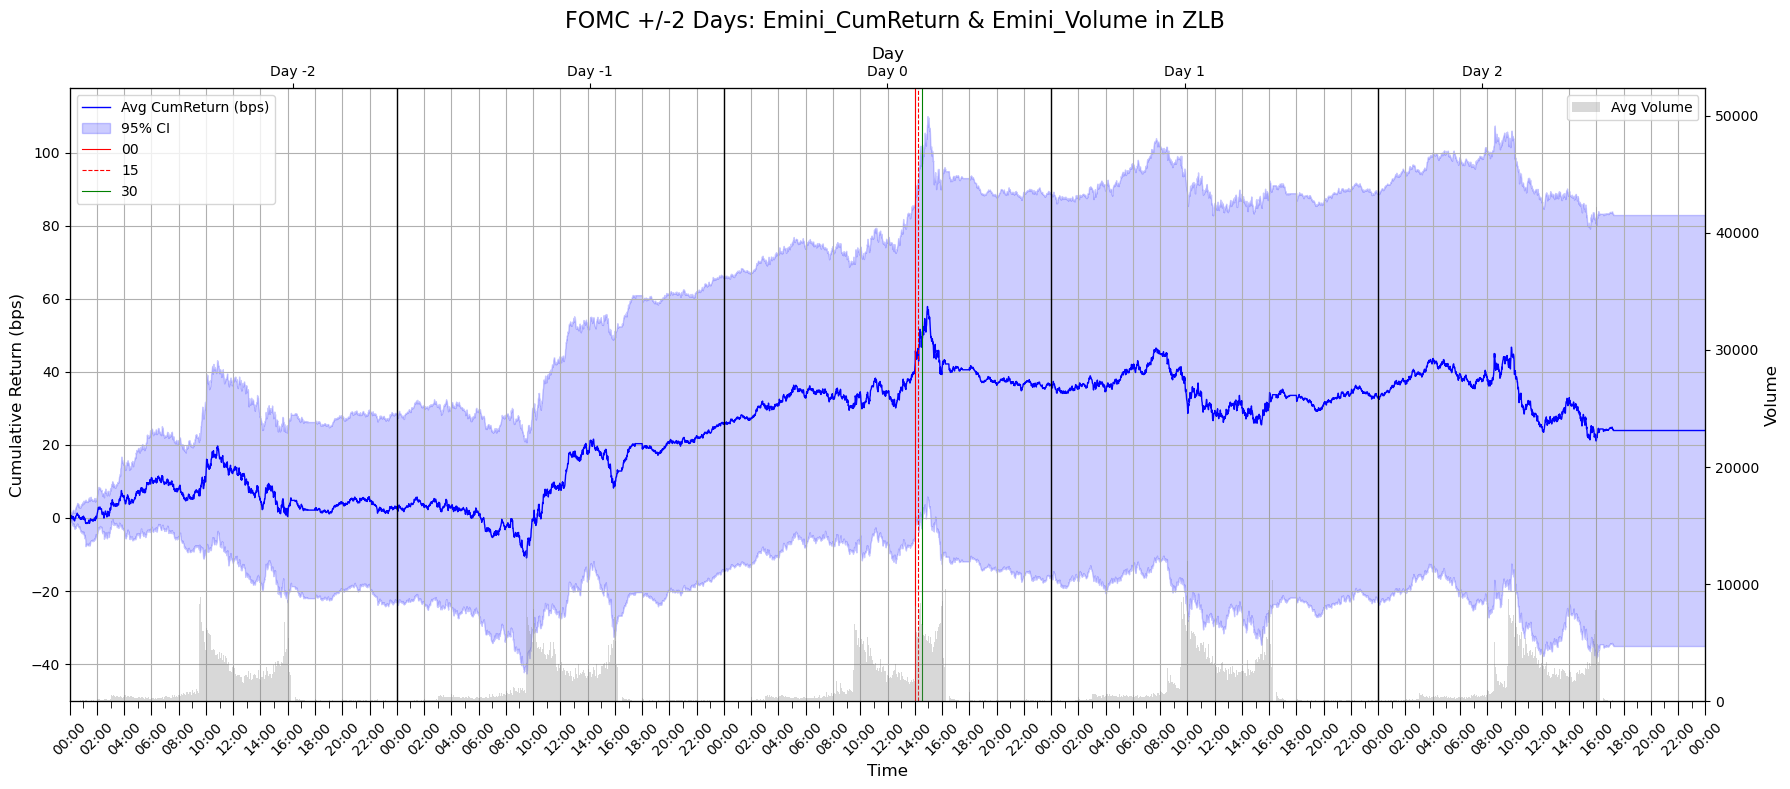

Saved CR table: ..\data\Emini\Emini_in_2_cr_ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\Emini\Emini_k2_ZLB.xlsx
Saved LaTeX bundle: ..\data\Emini\latex\ZLB.tex
Saved extras (Count) workbook: ..\data\Emini\Emini_k2_ZLB_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\latex\ZLB_Count.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Skipping fomc event at 2020-11-05 14:00:00: whole-day missing (or zero) on ['2020-11-07'] within +/-2 days.
Skipping fomc event at 2020-03-15 14:00:00: whole-day missing (or zero) on ['2020-03-14'] within +/-2 days.
Skipping fomc event at 2020-03-03 14:00:00: excessive intraday gaps on ['2020-03-01'] (>20 minutes missing in a day) within +/-2 days.
Skipping fomc event at 2018-11-08 14:00:00: whole-day missing (or zero) on ['2018-11-10'] within +/-2 days.
Saved figure: ..\data\Emini\fomc_window_k2_Post-ZLB.png


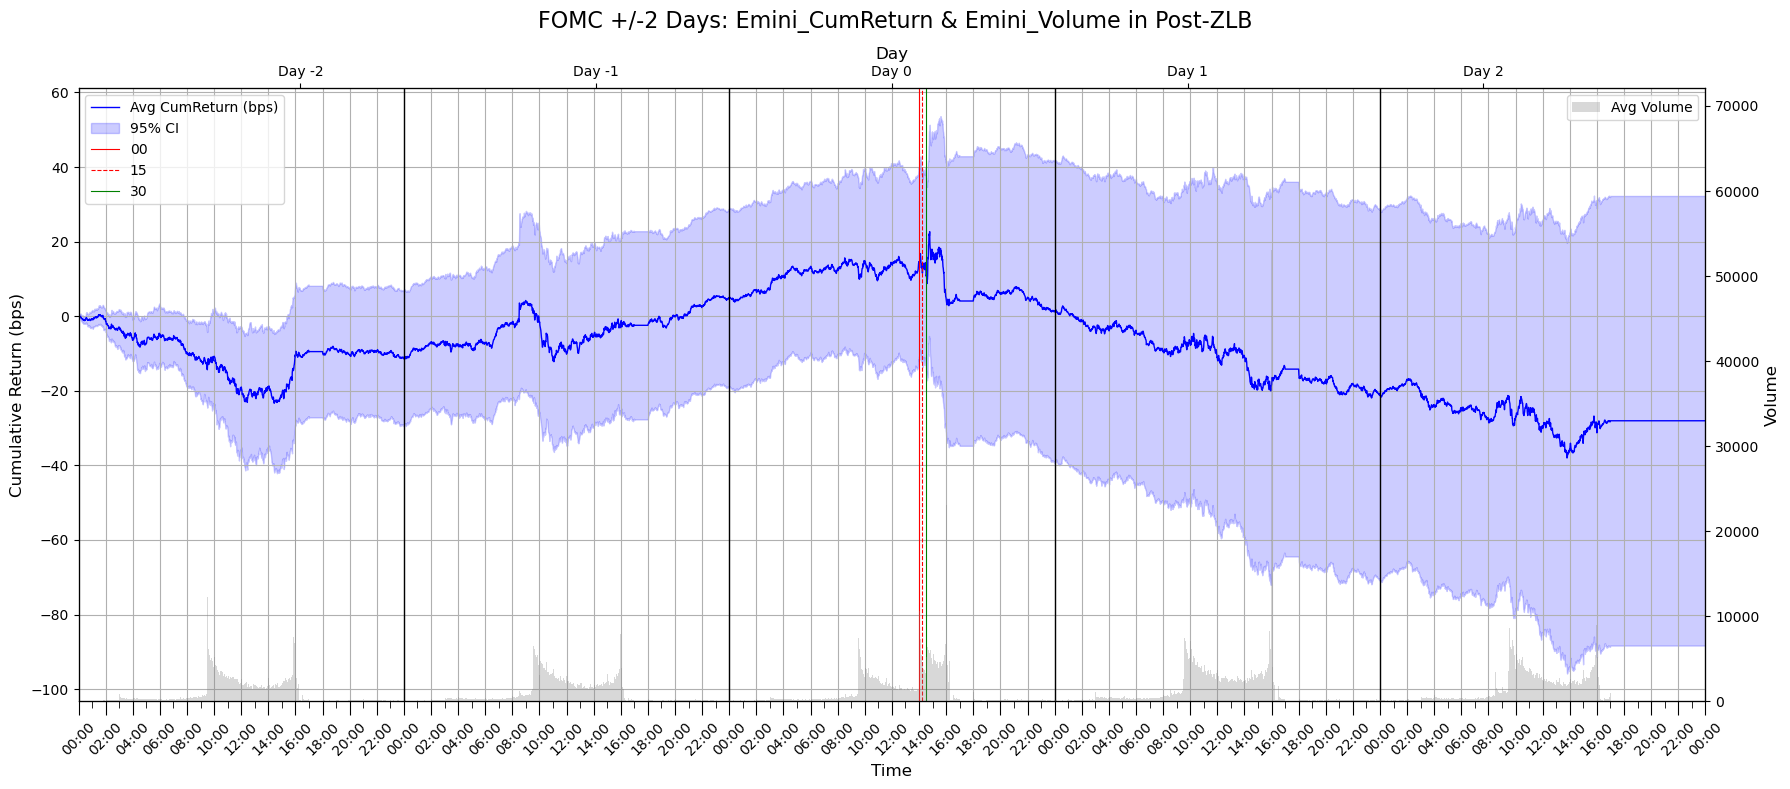

Saved CR table: ..\data\Emini\Emini_in_2_cr_Post-ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\Emini\Emini_k2_Post-ZLB.xlsx
Saved LaTeX bundle: ..\data\Emini\latex\Post-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved extras (Count) workbook: ..\data\Emini\Emini_k2_Post-ZLB_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\latex\Post-ZLB_Count.tex


{'Pre-ZLB': {'figure_path': WindowsPath('../data/Emini/fomc_window_k2_Pre-ZLB.png'),
  'cr_table_path': WindowsPath('../data/Emini/Emini_in_2_cr_Pre-ZLB.csv'),
  'daily_summary': {'table':                      FOMC_week_Day (-2)                                \
                                      Mean        St. Dev  P25       P50   
   Avg Daily Volume          652988.193548  994250.753985  0.0  423523.0   
   Diff_Vol (Ann - Day)      204989.064516            NaN  NaN       NaN   
   # Obs                         31.000000            NaN  NaN       NaN   
   
                                          FOMC_week_Day (-1)                     \
                              P75 No. Obs               Mean       St. Dev  P25   
   Avg Daily Volume      977114.0    31.0      704264.387097  1.053785e+06  0.0   
   Diff_Vol (Ann - Day)       NaN     NaN      153712.870968           NaN  NaN   
   # Obs                      NaN     NaN          31.000000           NaN  NaN   
   
           

In [31]:
plot_fomc_stacked_by_period_enhanced(
    asset='Emini',
    k=2,
    hft_sets={
        'Pre-ZLB': pre_zlb_emini,
        'ZLB': zlb_emini,
        'Post-ZLB': post_zlb_emini,
    },
    fomc_sets={
        'Pre-ZLB': pre_zlb_fomc,
        'ZLB': zlb_fomc,
        'Post-ZLB': post_zlb_fomc,
    },
    extra_metrics={'Count': 'Emini_Count'},
)


Skipping nonfomc event at 1991-02-27 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-03-20 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-04-17 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-05-08 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-06-12 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-07-24 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-08-14 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-09-04 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-09-25 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-10-16 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1991-11-27 14:15:00: no market data in +/-2 day window.
Skipping nonfomc event at 1992-01-15 14:15:00: no market data in +/-2 day window.
Skipping nonfomc

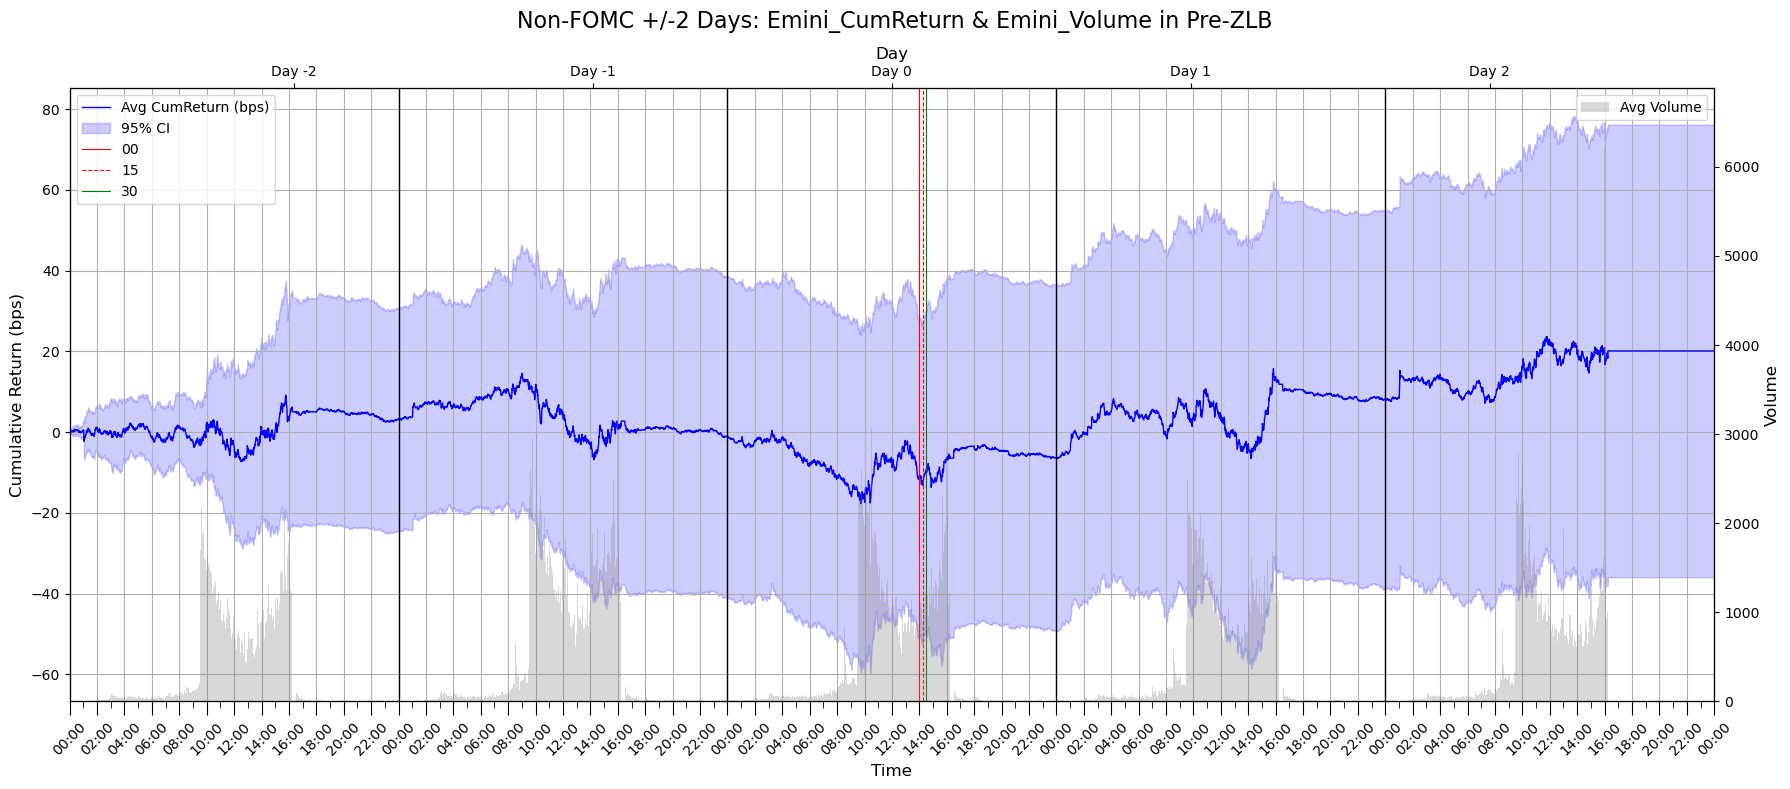

Saved CR table: ..\data\Emini\nonfomc\nonfomc_Emini_in_2_cr_Pre-ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k2_Pre-ZLB.xlsx
Saved LaTeX bundle: ..\data\Emini\nonfomc\latex\nonfomc_Pre-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved extras (Count) workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k2_Pre-ZLB_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\nonfomc\latex\nonfomc_Pre-ZLB_Count.tex
Skipping nonfomc event at 2009-04-08 14:15:00: whole-day missing (or zero) on ['2009-04-10'] within +/-2 days.
Skipping nonfomc event at 2012-01-04 14:15:00: whole-day missing (or zero) on ['2012-01-02'] within +/-2 days.
Saved figure: ..\data\Emini\nonfomc\nonfomc_fomc_window_k2_ZLB.png


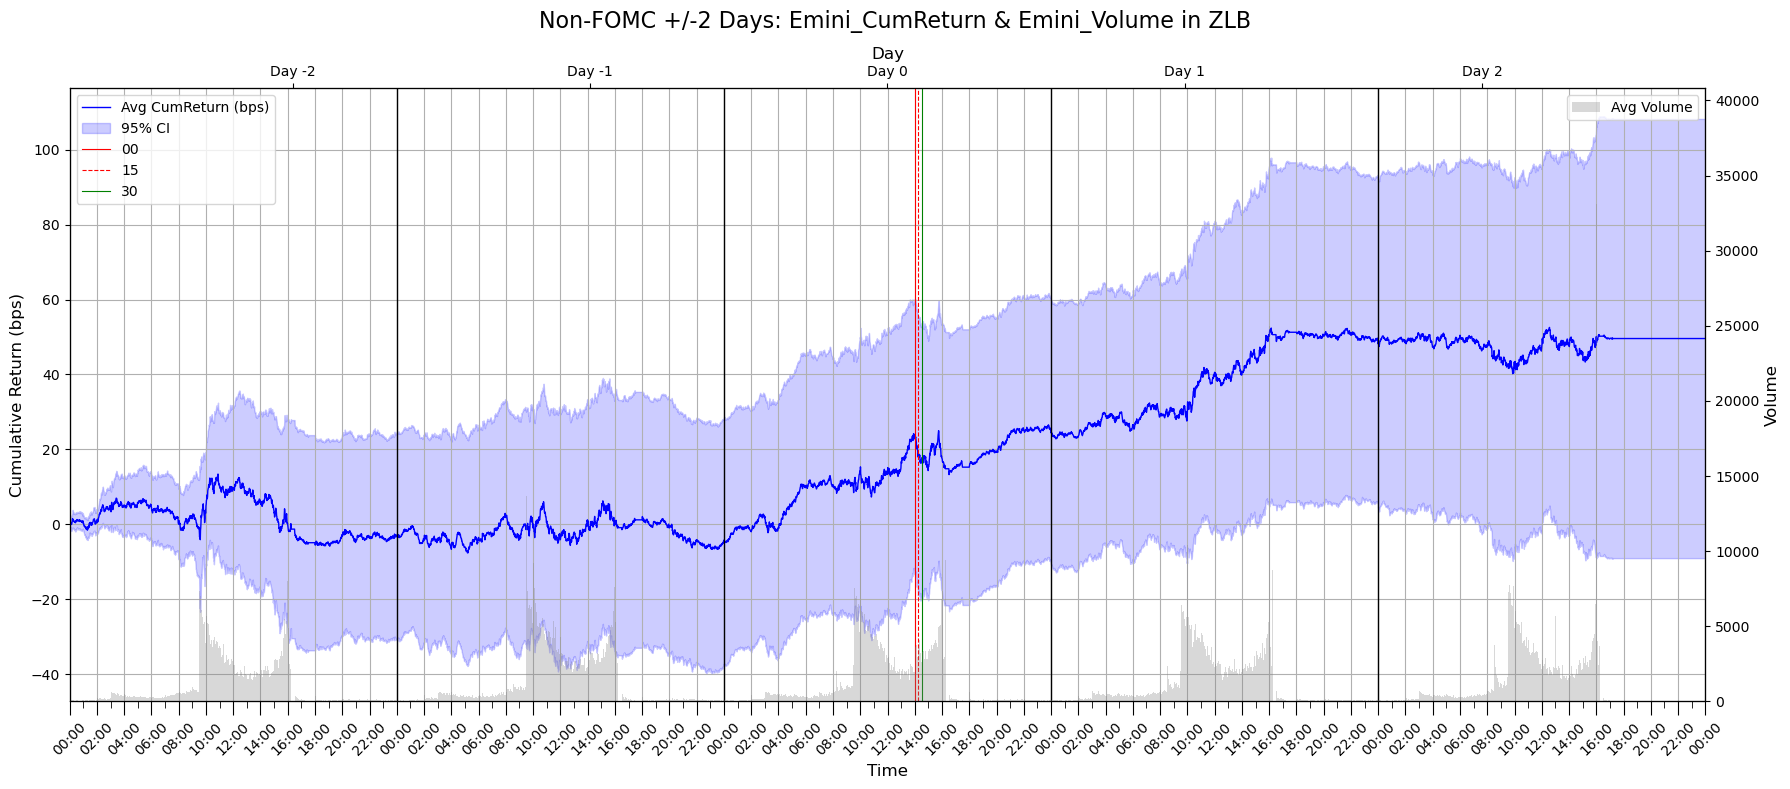

Saved CR table: ..\data\Emini\nonfomc\nonfomc_Emini_in_2_cr_ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k2_ZLB.xlsx
Saved LaTeX bundle: ..\data\Emini\nonfomc\latex\nonfomc_ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved extras (Count) workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k2_ZLB_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\nonfomc\latex\nonfomc_ZLB_Count.tex
Skipping nonfomc event at 2017-04-12 14:00:00: whole-day missing (or zero) on ['2017-04-14'] within +/-2 days.
Skipping nonfomc event at 2020-04-08 14:00:00: whole-day missing (or zero) on ['2020-04-10'] within +/-2 days.
Skipping nonfomc event at 2022-04-13 14:00:00: whole-day missing (or zero) on ['2022-04-15'] within +/-2 days.
Saved figure: ..\data\Emini\nonfomc\nonfomc_fomc_window_k2_Post-ZLB.png


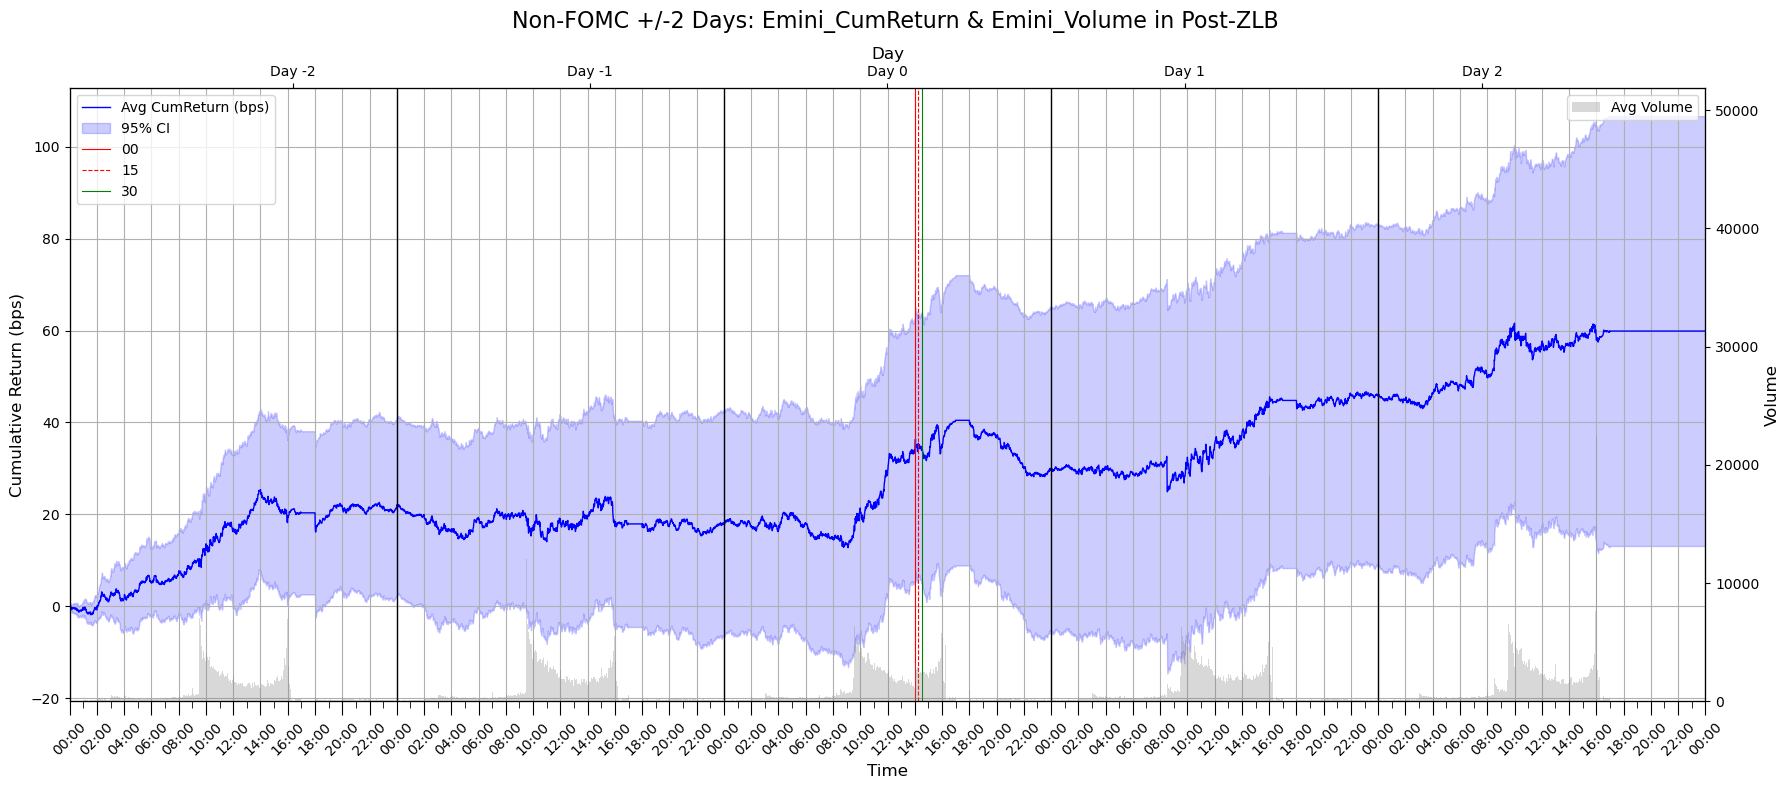

Saved CR table: ..\data\Emini\nonfomc\nonfomc_Emini_in_2_cr_Post-ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k2_Post-ZLB.xlsx
Saved LaTeX bundle: ..\data\Emini\nonfomc\latex\nonfomc_Post-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved extras (Count) workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k2_Post-ZLB_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\nonfomc\latex\nonfomc_Post-ZLB_Count.tex


{'Pre-ZLB': {'figure_path': WindowsPath('../data/Emini/nonfomc/nonfomc_fomc_window_k2_Pre-ZLB.png'),
  'cr_table_path': WindowsPath('../data/Emini/nonfomc/nonfomc_Emini_in_2_cr_Pre-ZLB.csv'),
  'daily_summary': {'table':                      FOMC_week_Day (-2)                                        \
                                      Mean        St. Dev  P25     P50       P75   
   Avg Daily Volume          467865.686747  678248.848442  0.0  5323.0  727485.5   
   Diff_Vol (Ann - Day)      159939.108434            NaN  NaN     NaN       NaN   
   # Obs                         83.000000            NaN  NaN     NaN       NaN   
   
                                FOMC_week_Day (-1)                                \
                        No. Obs               Mean        St. Dev  P25       P50   
   Avg Daily Volume        83.0      661285.253012  861433.714827  0.0  519761.0   
   Diff_Vol (Ann - Day)     NaN      -33480.457831            NaN  NaN       NaN   
   # Obs              

In [32]:
plot_fomc_stacked_by_period_enhanced(
    asset='Emini',
    k=2,
    hft_sets={
        'Pre-ZLB': pre_zlb_emini,
        'ZLB': zlb_emini,
        'Post-ZLB': post_zlb_emini,
    },
    fomc_sets={
        'Pre-ZLB': pre_zlb_non_fomc,
        'ZLB': zlb_non_fomc,
        'Post-ZLB': post_zlb_non_fomc,
    },
    extra_metrics={'Count': 'Emini_Count'},
    fomc_type='nonfomc'
)


Skipping fomc event at 1994-12-20 14:17:00: whole-day missing (or zero) on ['1994-12-20'] within +/-0 days.
Skipping fomc event at 1994-11-15 14:20:00: whole-day missing (or zero) on ['1994-11-15'] within +/-0 days.
Skipping fomc event at 1994-09-27 14:18:00: whole-day missing (or zero) on ['1994-09-27'] within +/-0 days.
Skipping fomc event at 1994-08-16 13:18:00: whole-day missing (or zero) on ['1994-08-16'] within +/-0 days.
Skipping fomc event at 1994-07-06 14:18:00: whole-day missing (or zero) on ['1994-07-06'] within +/-0 days.
Skipping fomc event at 1994-05-17 14:26:00: whole-day missing (or zero) on ['1994-05-17'] within +/-0 days.
Skipping fomc event at 1994-04-18 10:06:00: whole-day missing (or zero) on ['1994-04-18'] within +/-0 days.
Skipping fomc event at 1994-03-22 14:20:00: whole-day missing (or zero) on ['1994-03-22'] within +/-0 days.
Skipping fomc event at 1994-02-04 11:05:00: whole-day missing (or zero) on ['1994-02-04'] within +/-0 days.
Skipping fomc event at 1993-

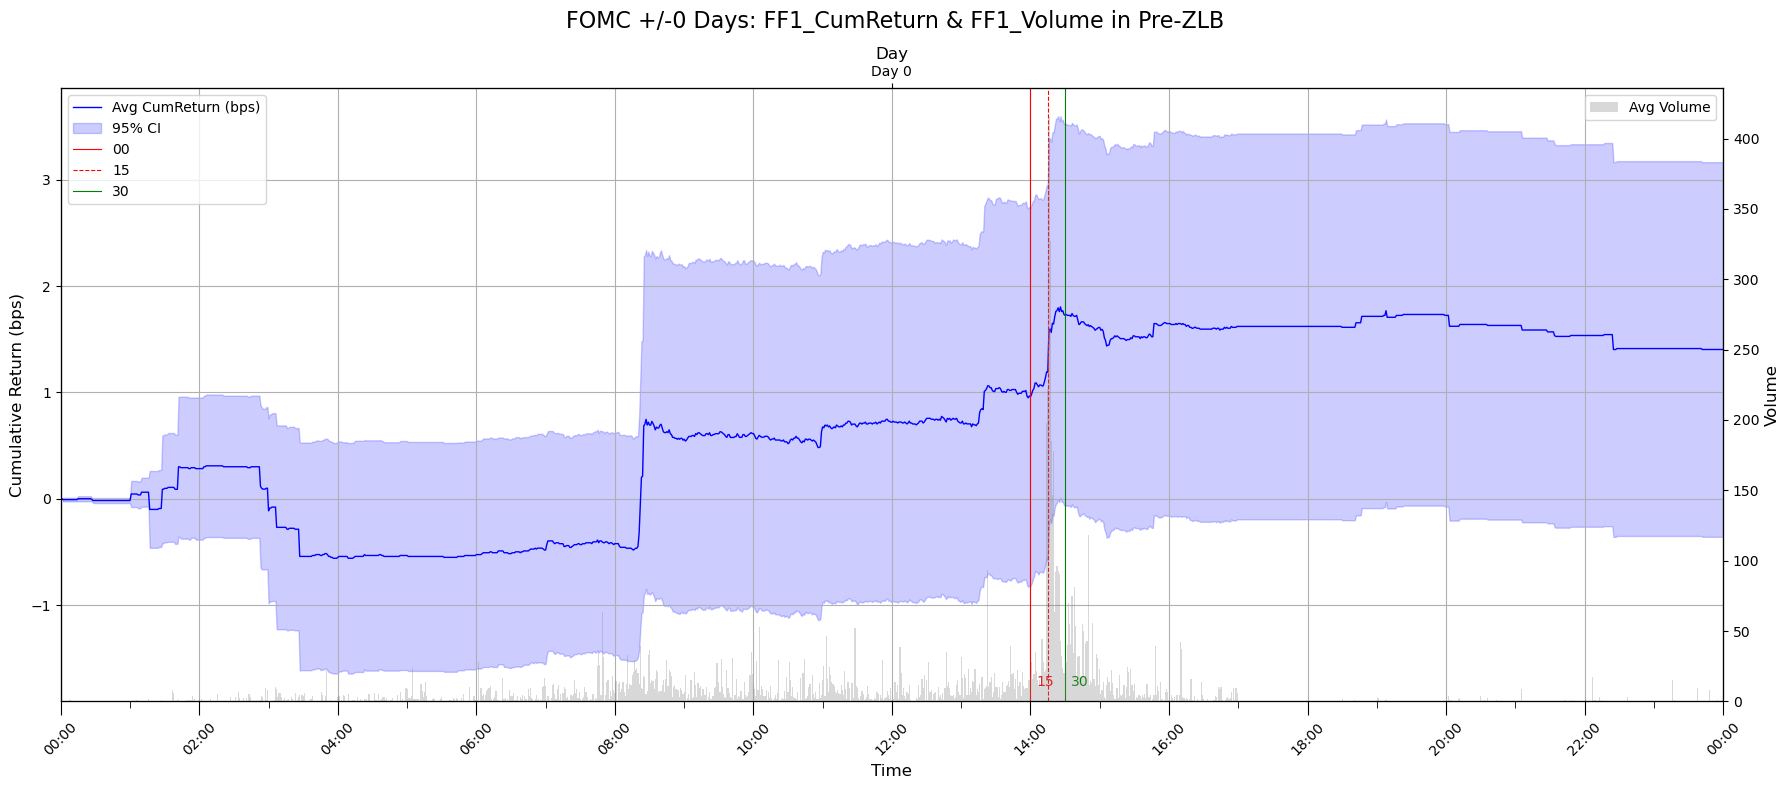

Saved CR table: ..\data\FF1\FF1_in_0_cr_Pre-ZLB.csv
Saved summary workbook: ..\data\FF1\FF1_k0_Pre-ZLB.xlsx
Saved LaTeX bundle: ..\data\FF1\latex\Pre-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved figure: ..\data\FF1\fomc_window_k0_ZLB.png


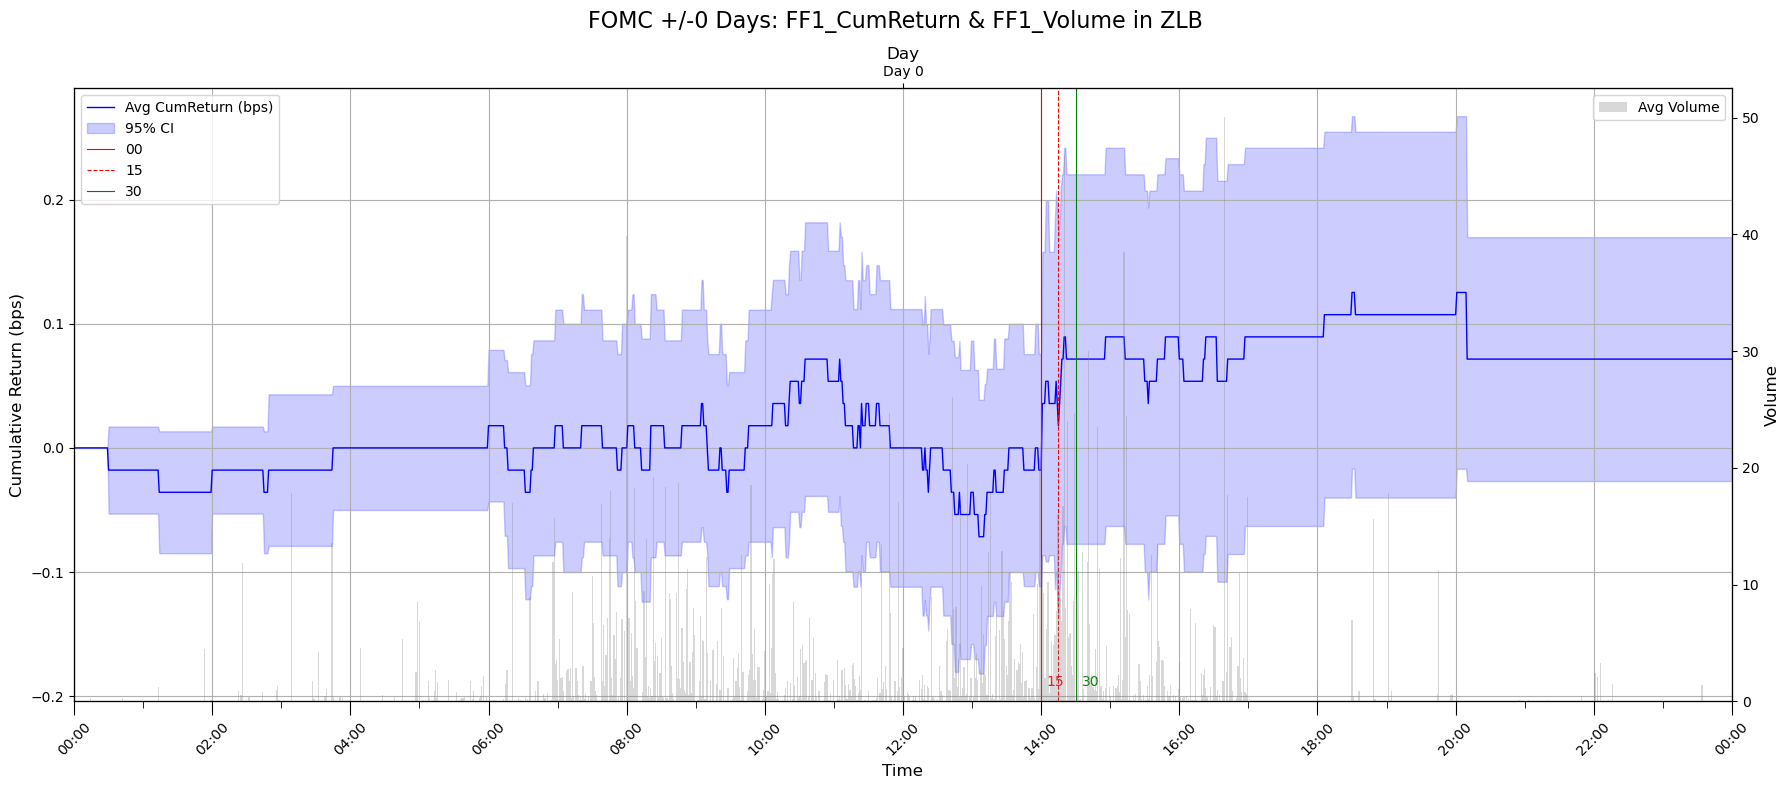

Saved CR table: ..\data\FF1\FF1_in_0_cr_ZLB.csv
Saved summary workbook: ..\data\FF1\FF1_k0_ZLB.xlsx
Saved LaTeX bundle: ..\data\FF1\latex\ZLB.tex
Skipping fomc event at 2024-01-31 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-12-13 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-11-01 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-09-20 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-07-26 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-06-14 14:00:00: no market data in +/-0 day window.


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Skipping fomc event at 2023-05-03 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-03-22 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-02-01 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-12-14 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-11-02 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-09-21 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-07-27 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-06-15 14:00:00: whole-day missing (or zero) on ['2022-06-15'] within +/-0 days.
Skipping fomc event at 2022-05-04 14:00:00: whole-day missing (or zero) on ['2022-05-04'] within +/-0 days.
Saved figure: ..\data\FF1\fomc_window_k0_Post-ZLB.png


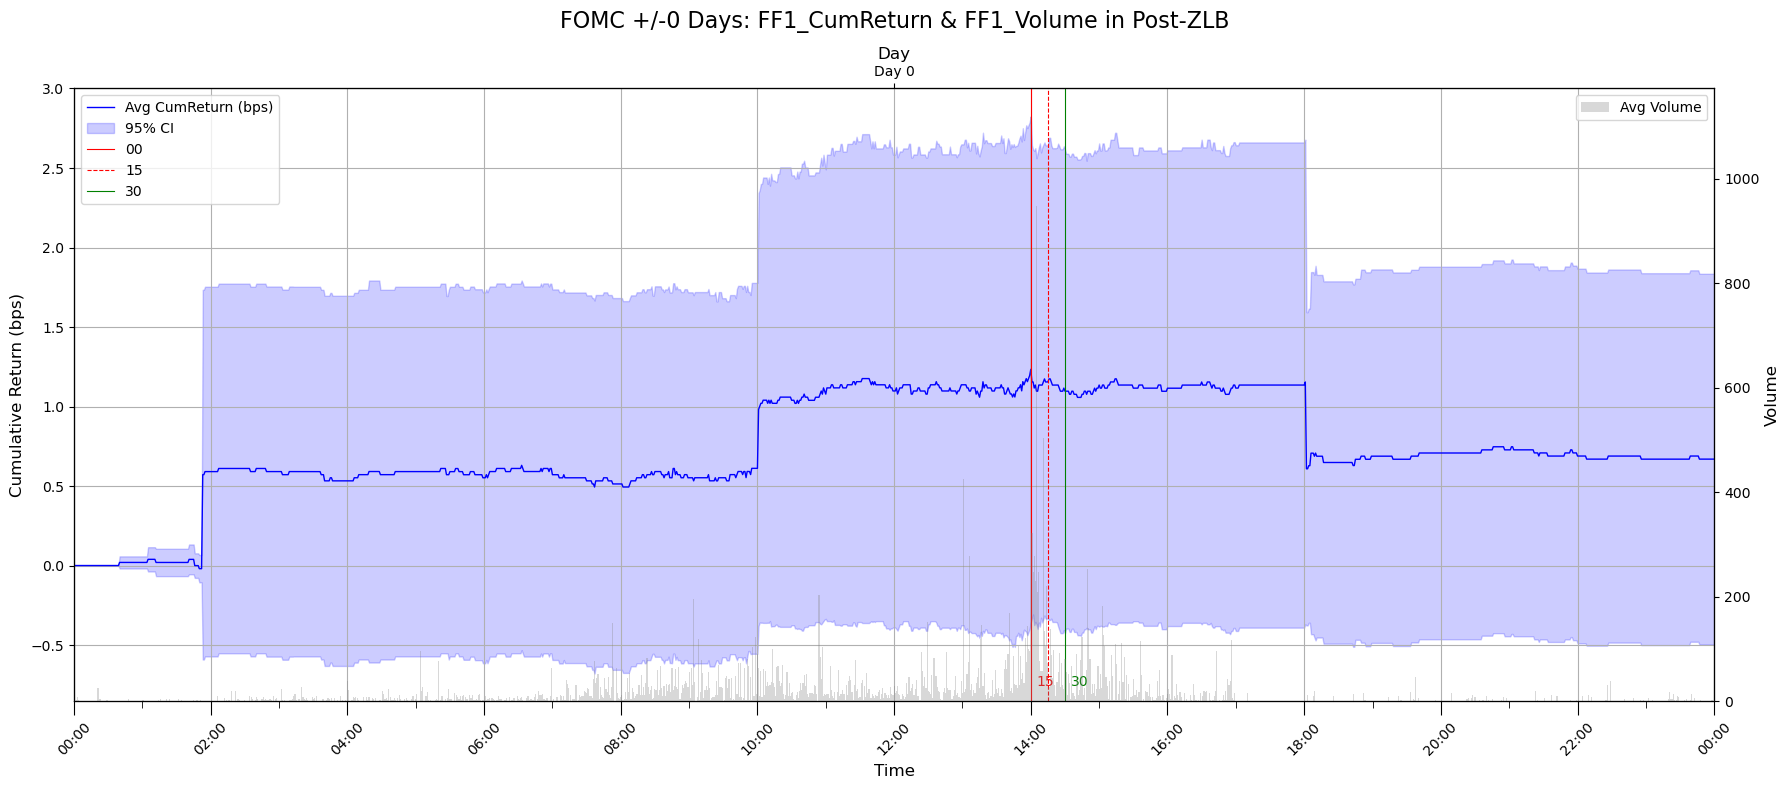

Saved CR table: ..\data\FF1\FF1_in_0_cr_Post-ZLB.csv
Saved summary workbook: ..\data\FF1\FF1_k0_Post-ZLB.xlsx
Saved LaTeX bundle: ..\data\FF1\latex\Post-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


{'Pre-ZLB': {'figure_path': WindowsPath('../data/FF1/fomc_window_k0_Pre-ZLB.png'),
  'cr_table_path': WindowsPath('../data/FF1/FF1_in_0_cr_Pre-ZLB.csv'),
  'daily_summary': {'table':                      FOMC_week_Day (-2)                              \
                                      Mean St. Dev P25 P50 P75 No. Obs   
   Avg Daily Volume                    NaN     NaN NaN NaN NaN     0.0   
   Diff_Vol (Ann - Day)                NaN     NaN NaN NaN NaN     NaN   
   # Obs                               0.0     NaN NaN NaN NaN     NaN   
   
                        FOMC_week_Day (-1)                  ...  \
                                      Mean St. Dev P25 P50  ...   
   Avg Daily Volume                    NaN     NaN NaN NaN  ...   
   Diff_Vol (Ann - Day)                NaN     NaN NaN NaN  ...   
   # Obs                               0.0     NaN NaN NaN  ...   
   
                        FOMC_week_Day (+1)                 FOMC_week_Day (+2)  \
                          

In [65]:
plot_fomc_stacked_by_period_enhanced(asset='FF1', k=0, hft_sets=None, fomc_sets=None, 
                                        extra_metrics=None, fomc_type='fomc')

Skipping fomc event at 1994-12-20 14:17:00: whole-day missing (or zero) on ['1994-12-20'] within +/-0 days.
Skipping fomc event at 1994-11-15 14:20:00: whole-day missing (or zero) on ['1994-11-15'] within +/-0 days.
Skipping fomc event at 1994-09-27 14:18:00: whole-day missing (or zero) on ['1994-09-27'] within +/-0 days.
Skipping fomc event at 1994-08-16 13:18:00: whole-day missing (or zero) on ['1994-08-16'] within +/-0 days.
Skipping fomc event at 1994-07-06 14:18:00: whole-day missing (or zero) on ['1994-07-06'] within +/-0 days.
Skipping fomc event at 1994-05-17 14:26:00: whole-day missing (or zero) on ['1994-05-17'] within +/-0 days.
Skipping fomc event at 1994-04-18 10:06:00: whole-day missing (or zero) on ['1994-04-18'] within +/-0 days.
Skipping fomc event at 1994-03-22 14:20:00: whole-day missing (or zero) on ['1994-03-22'] within +/-0 days.
Skipping fomc event at 1994-02-04 11:05:00: whole-day missing (or zero) on ['1994-02-04'] within +/-0 days.
Skipping fomc event at 1993-

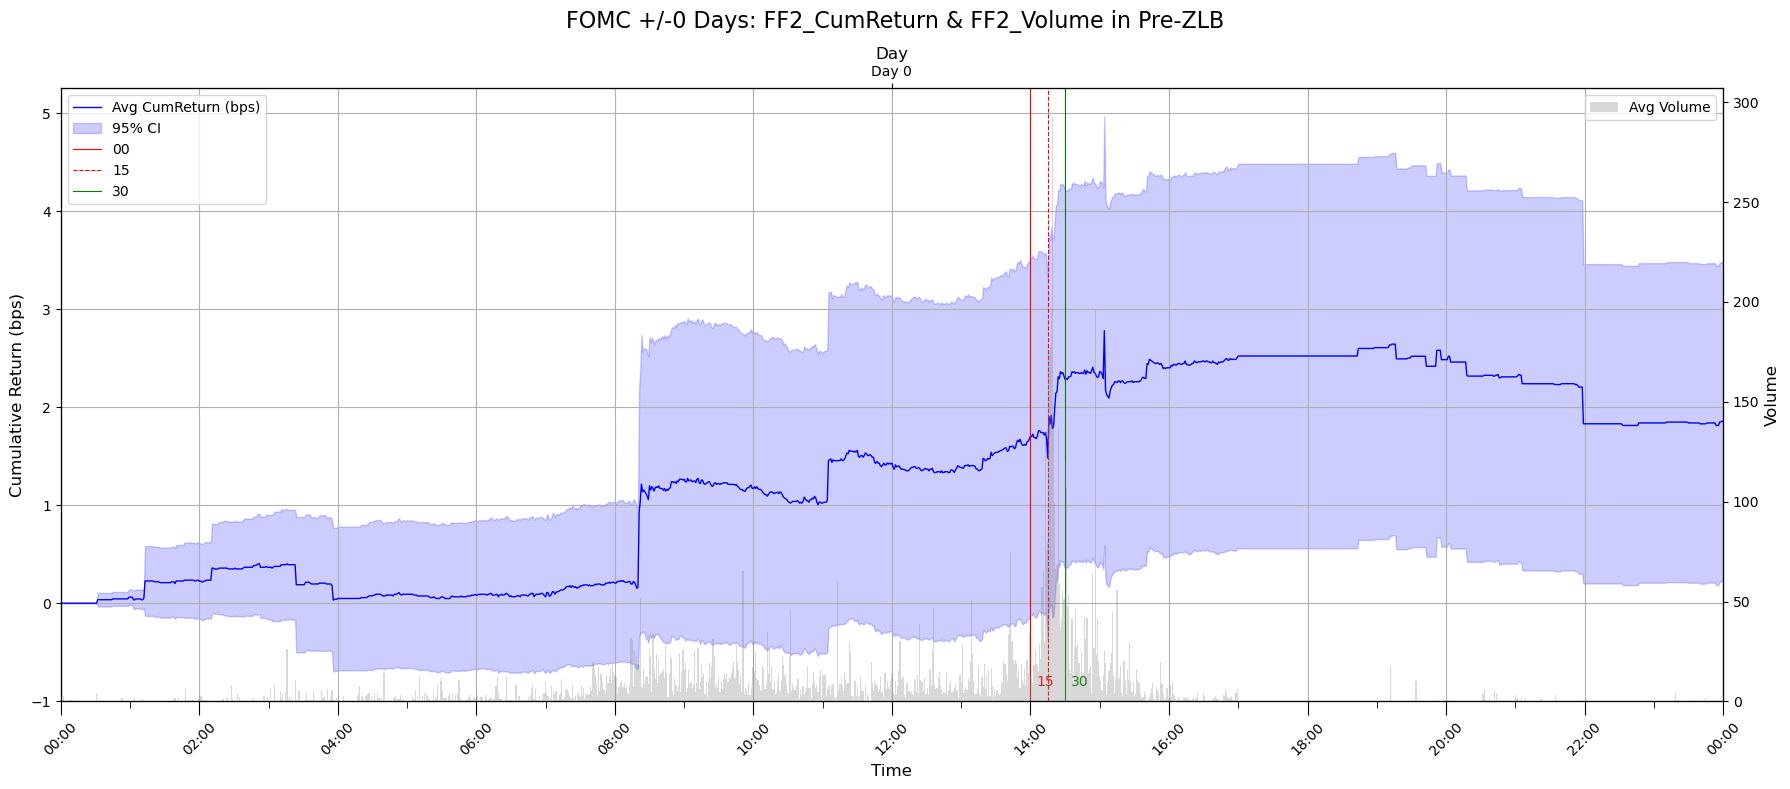

Saved CR table: ..\data\FF2\FF2_in_0_cr_Pre-ZLB.csv
Saved summary workbook: ..\data\FF2\FF2_k0_Pre-ZLB.xlsx
Saved LaTeX bundle: ..\data\FF2\latex\Pre-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved figure: ..\data\FF2\fomc_window_k0_ZLB.png


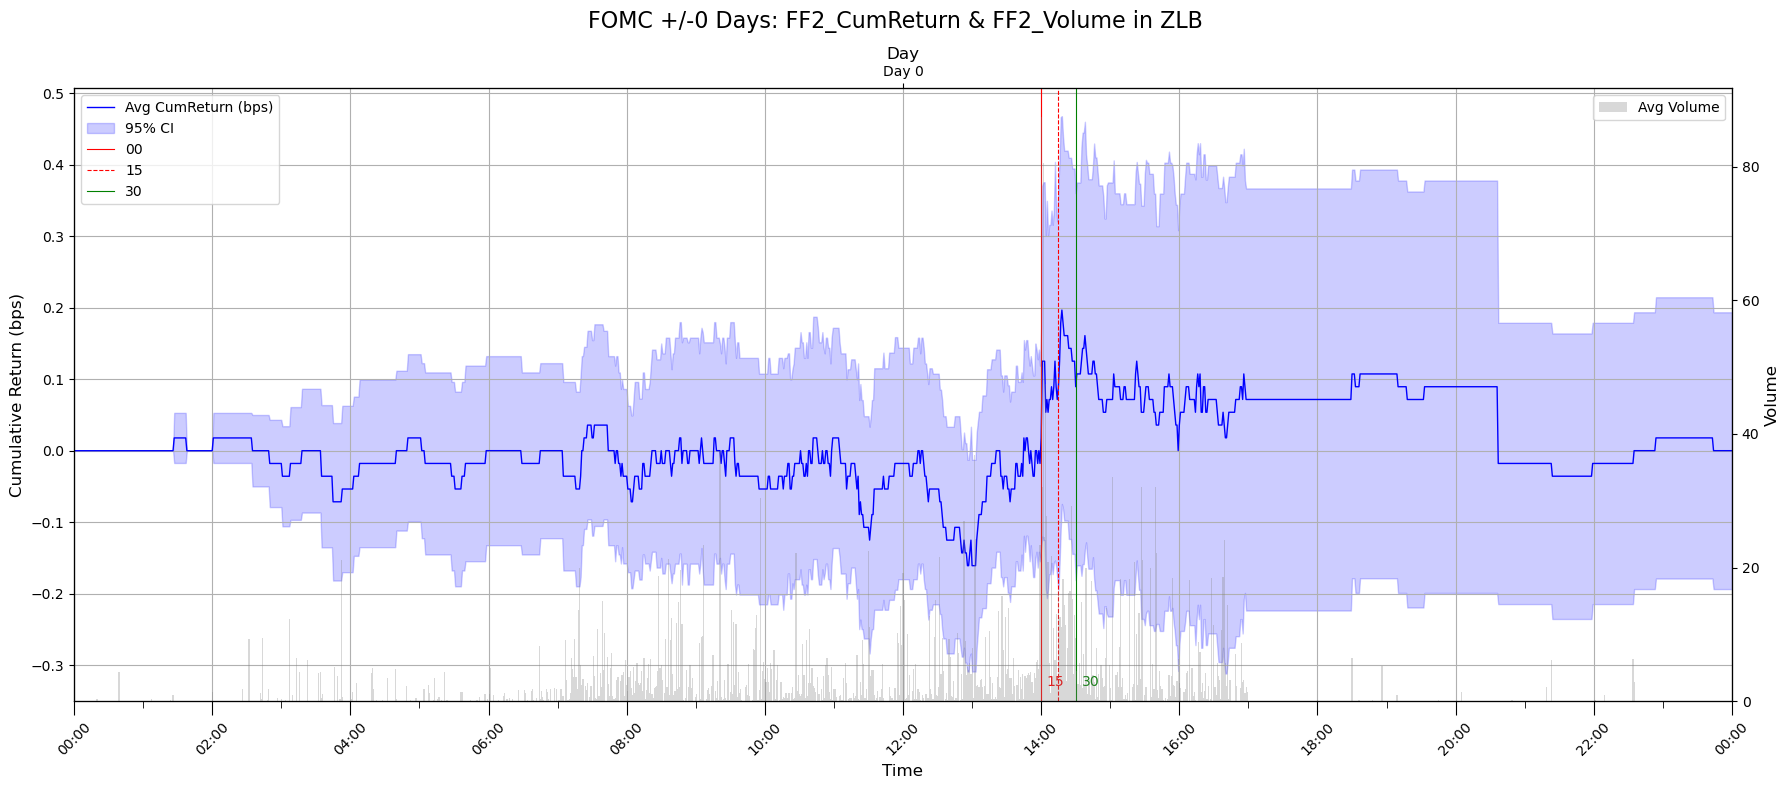

Saved CR table: ..\data\FF2\FF2_in_0_cr_ZLB.csv
Saved summary workbook: ..\data\FF2\FF2_k0_ZLB.xlsx
Saved LaTeX bundle: ..\data\FF2\latex\ZLB.tex
Skipping fomc event at 2024-01-31 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-12-13 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-11-01 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-09-20 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-07-26 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-06-14 14:00:00: no market data in +/-0 day window.


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Skipping fomc event at 2023-05-03 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-03-22 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-02-01 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-12-14 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-11-02 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-09-21 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-07-27 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-06-15 14:00:00: whole-day missing (or zero) on ['2022-06-15'] within +/-0 days.
Skipping fomc event at 2022-05-04 14:00:00: whole-day missing (or zero) on ['2022-05-04'] within +/-0 days.
Saved figure: ..\data\FF2\fomc_window_k0_Post-ZLB.png


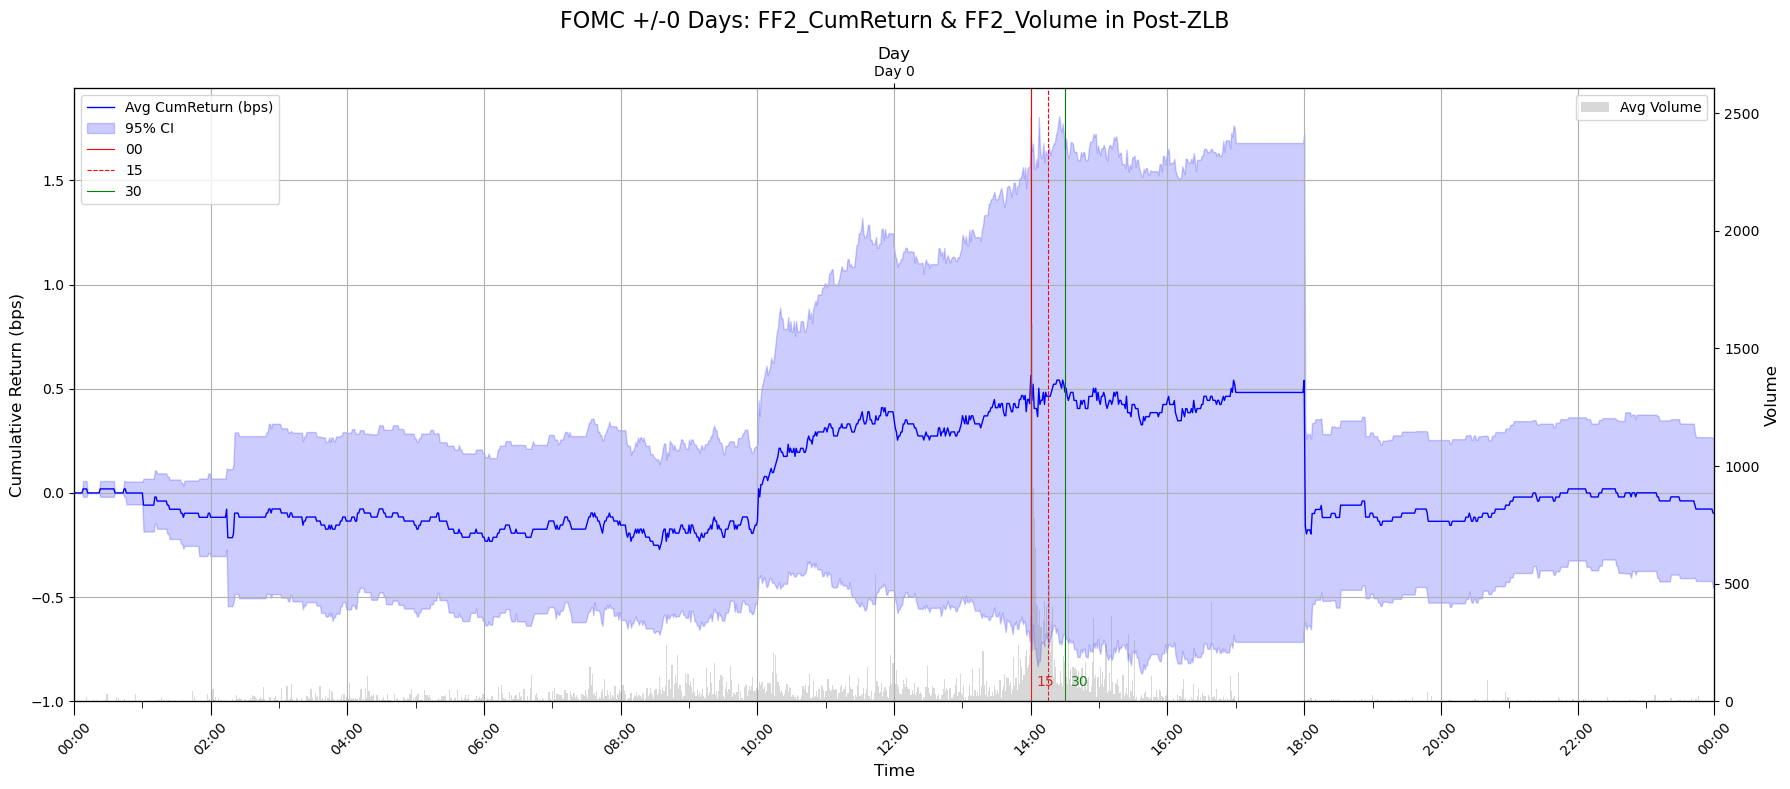

Saved CR table: ..\data\FF2\FF2_in_0_cr_Post-ZLB.csv
Saved summary workbook: ..\data\FF2\FF2_k0_Post-ZLB.xlsx
Saved LaTeX bundle: ..\data\FF2\latex\Post-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


{'Pre-ZLB': {'figure_path': WindowsPath('../data/FF2/fomc_window_k0_Pre-ZLB.png'),
  'cr_table_path': WindowsPath('../data/FF2/FF2_in_0_cr_Pre-ZLB.csv'),
  'daily_summary': {'table':                      FOMC_week_Day (-2)                              \
                                      Mean St. Dev P25 P50 P75 No. Obs   
   Avg Daily Volume                    NaN     NaN NaN NaN NaN     0.0   
   Diff_Vol (Ann - Day)                NaN     NaN NaN NaN NaN     NaN   
   # Obs                               0.0     NaN NaN NaN NaN     NaN   
   
                        FOMC_week_Day (-1)                  ...  \
                                      Mean St. Dev P25 P50  ...   
   Avg Daily Volume                    NaN     NaN NaN NaN  ...   
   Diff_Vol (Ann - Day)                NaN     NaN NaN NaN  ...   
   # Obs                               0.0     NaN NaN NaN  ...   
   
                        FOMC_week_Day (+1)                 FOMC_week_Day (+2)  \
                          

In [66]:
plot_fomc_stacked_by_period_enhanced(asset='FF2', k=0, hft_sets=None, fomc_sets=None, 
                                        extra_metrics=None, fomc_type='fomc')

Saved figure: ..\data\ED2\fomc_window_k0_Pre-ZLB.png


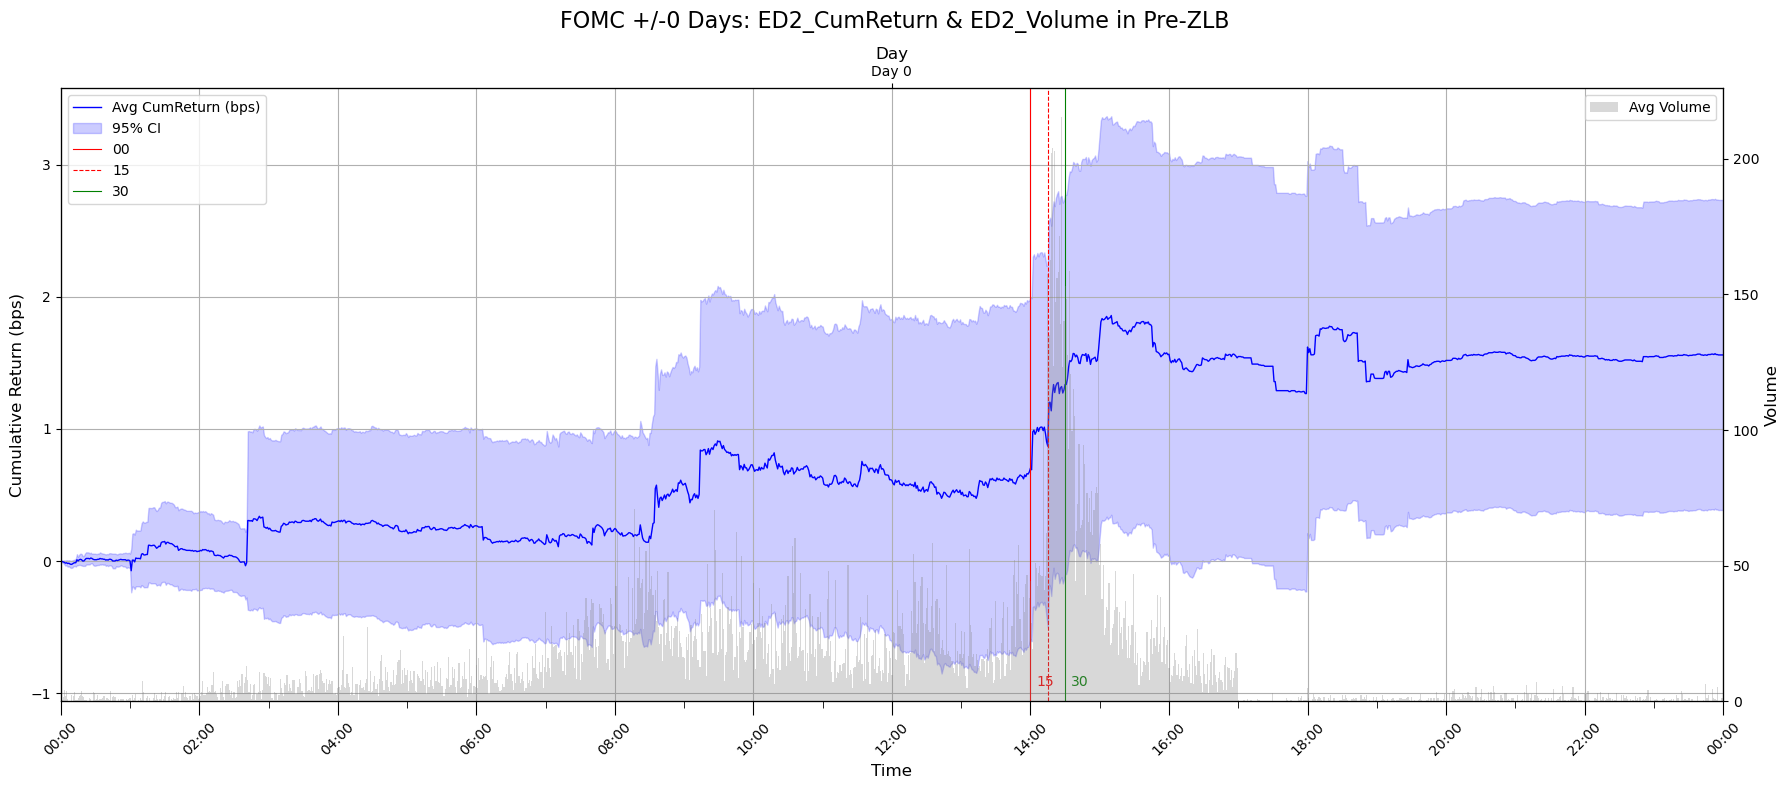

Saved CR table: ..\data\ED2\ED2_in_0_cr_Pre-ZLB.csv
Saved summary workbook: ..\data\ED2\ED2_k0_Pre-ZLB.xlsx
Saved LaTeX bundle: ..\data\ED2\latex\Pre-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved figure: ..\data\ED2\fomc_window_k0_ZLB.png


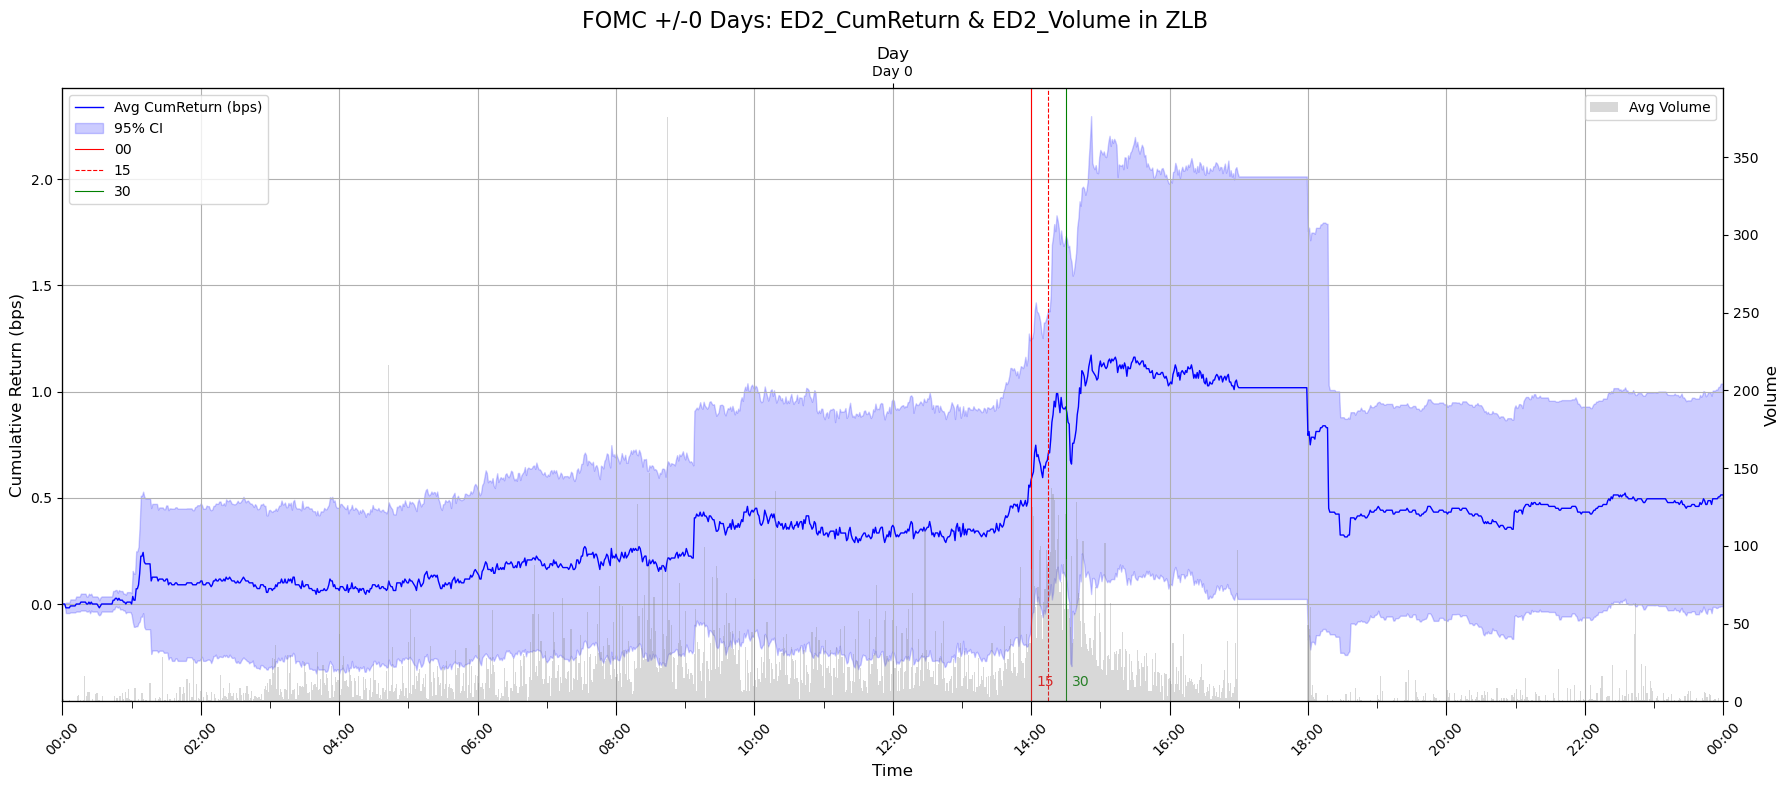

Saved CR table: ..\data\ED2\ED2_in_0_cr_ZLB.csv
Saved summary workbook: ..\data\ED2\ED2_k0_ZLB.xlsx
Saved LaTeX bundle: ..\data\ED2\latex\ZLB.tex
Skipping fomc event at 2024-01-31 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-12-13 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-11-01 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-09-20 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-07-26 14:00:00: no market data in +/-0 day window.


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Skipping fomc event at 2023-06-14 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-05-03 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-03-22 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-02-01 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-12-14 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-11-02 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-09-21 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-07-27 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-06-15 14:00:00: whole-day missing (or zero) on ['2022-06-15'] within +/-0 days.
Skipping fomc event at 2022-05-04 14:00:00: whole-day missing (or zero) on ['2022-05-04'] within +/-0 days.
Saved figure: ..\data\ED2\fomc_window_k0_Post-ZLB.png


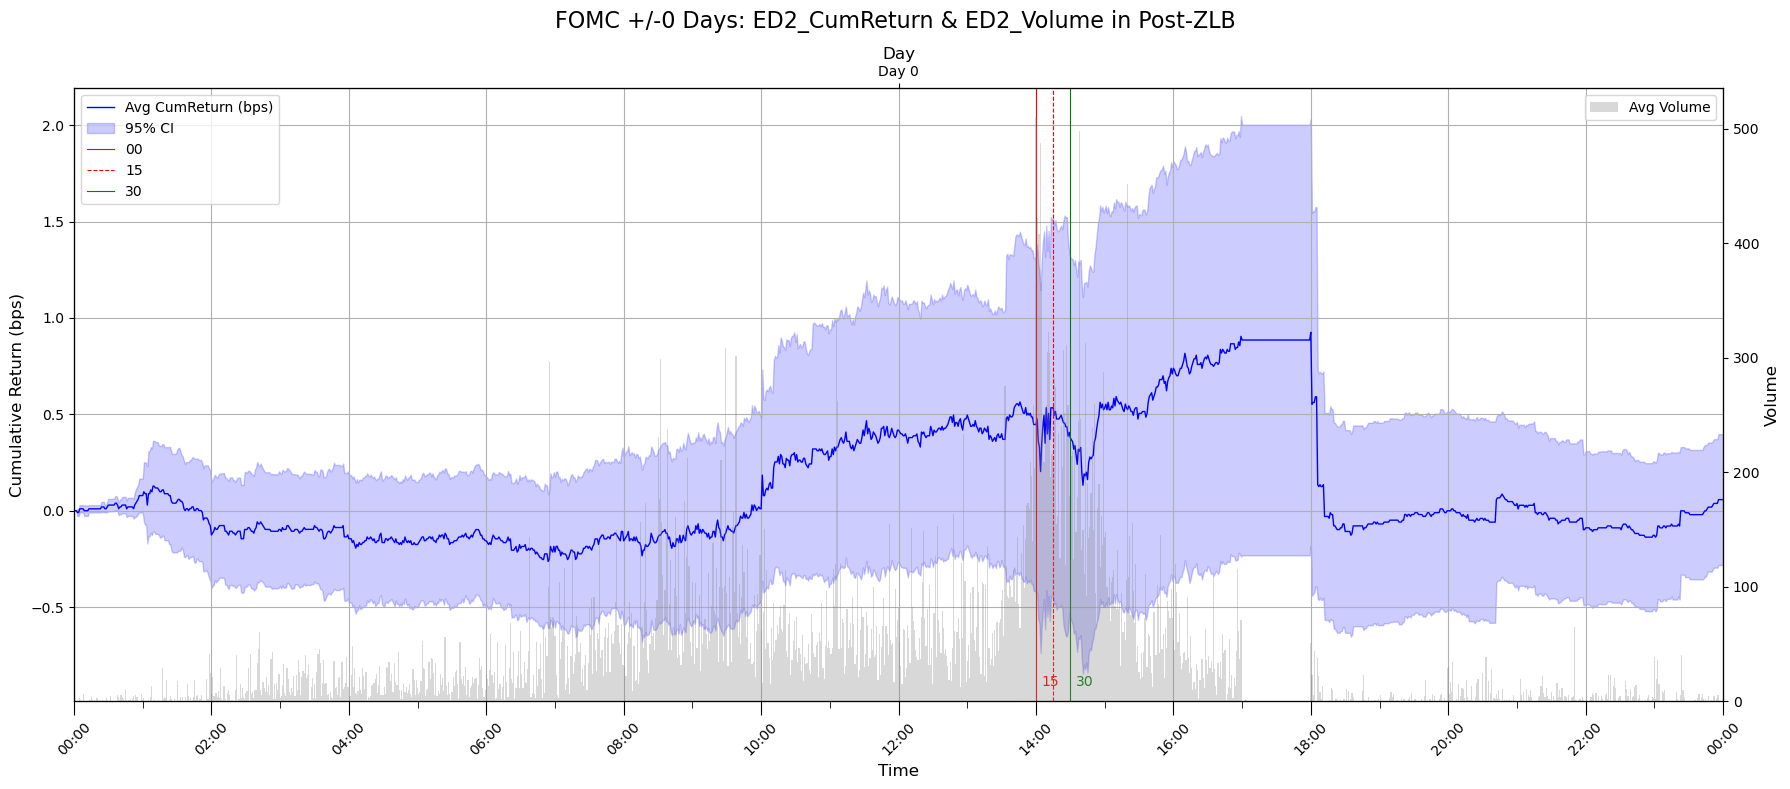

Saved CR table: ..\data\ED2\ED2_in_0_cr_Post-ZLB.csv
Saved summary workbook: ..\data\ED2\ED2_k0_Post-ZLB.xlsx
Saved LaTeX bundle: ..\data\ED2\latex\Post-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


{'Pre-ZLB': {'figure_path': WindowsPath('../data/ED2/fomc_window_k0_Pre-ZLB.png'),
  'cr_table_path': WindowsPath('../data/ED2/ED2_in_0_cr_Pre-ZLB.csv'),
  'daily_summary': {'table':                      FOMC_week_Day (-2)                              \
                                      Mean St. Dev P25 P50 P75 No. Obs   
   Avg Daily Volume                    NaN     NaN NaN NaN NaN     0.0   
   Diff_Vol (Ann - Day)                NaN     NaN NaN NaN NaN     NaN   
   # Obs                               0.0     NaN NaN NaN NaN     NaN   
   
                        FOMC_week_Day (-1)                  ...  \
                                      Mean St. Dev P25 P50  ...   
   Avg Daily Volume                    NaN     NaN NaN NaN  ...   
   Diff_Vol (Ann - Day)                NaN     NaN NaN NaN  ...   
   # Obs                               0.0     NaN NaN NaN  ...   
   
                        FOMC_week_Day (+1)                 FOMC_week_Day (+2)  \
                          

In [67]:
plot_fomc_stacked_by_period_enhanced(asset='ED2', k=0, hft_sets=None, fomc_sets=None, 
                                        extra_metrics=None, fomc_type='fomc')

Saved figure: ..\data\ED3\fomc_window_k0_Pre-ZLB.png


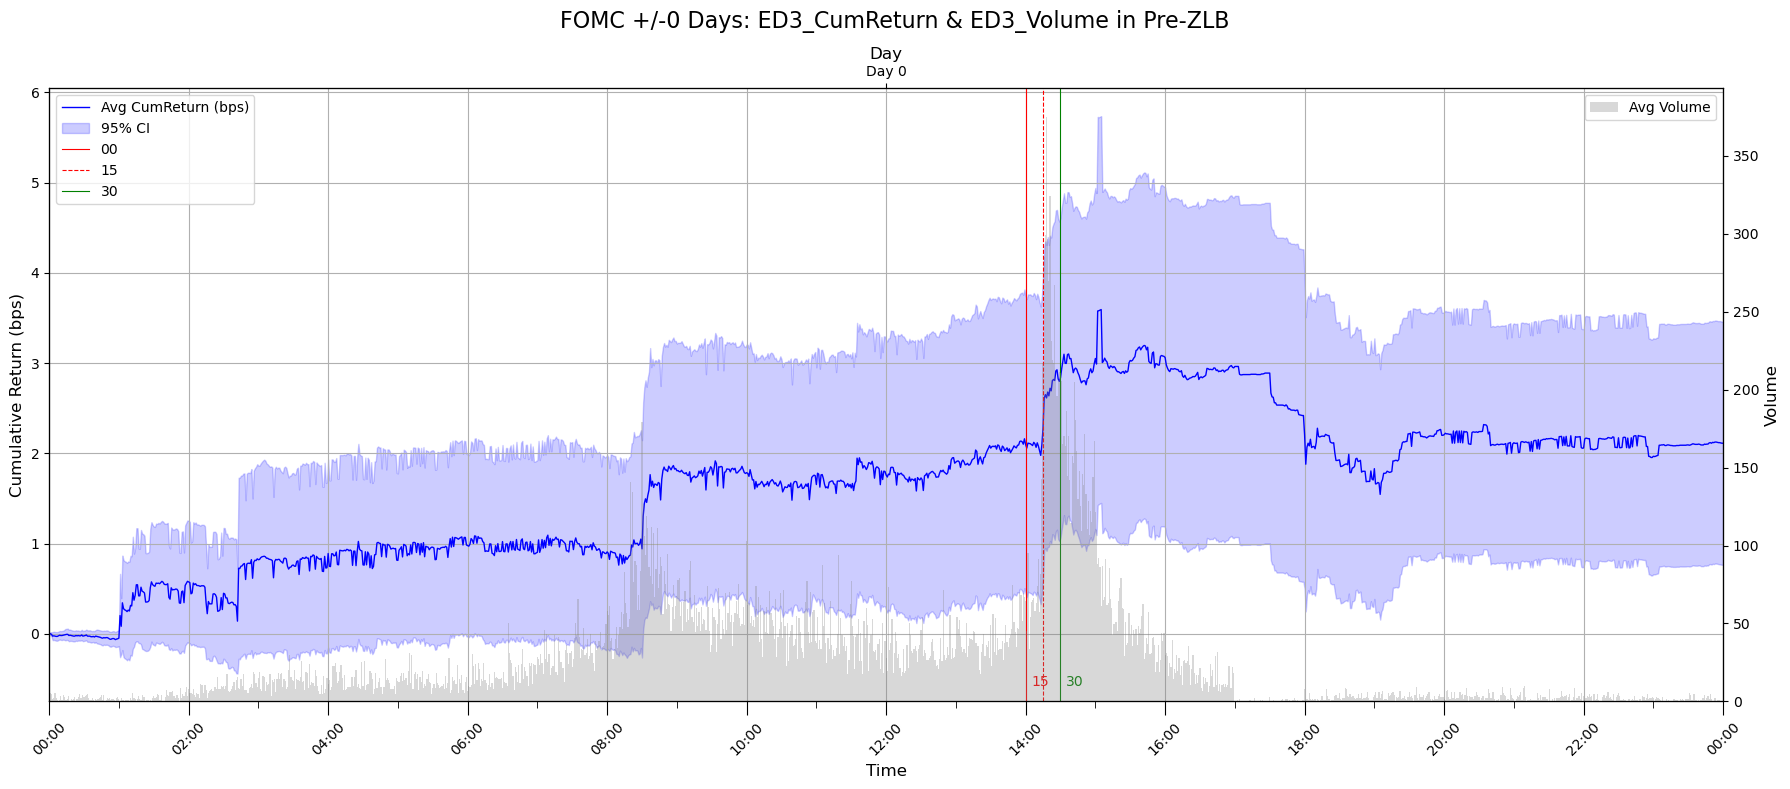

Saved CR table: ..\data\ED3\ED3_in_0_cr_Pre-ZLB.csv
Saved summary workbook: ..\data\ED3\ED3_k0_Pre-ZLB.xlsx
Saved LaTeX bundle: ..\data\ED3\latex\Pre-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved figure: ..\data\ED3\fomc_window_k0_ZLB.png


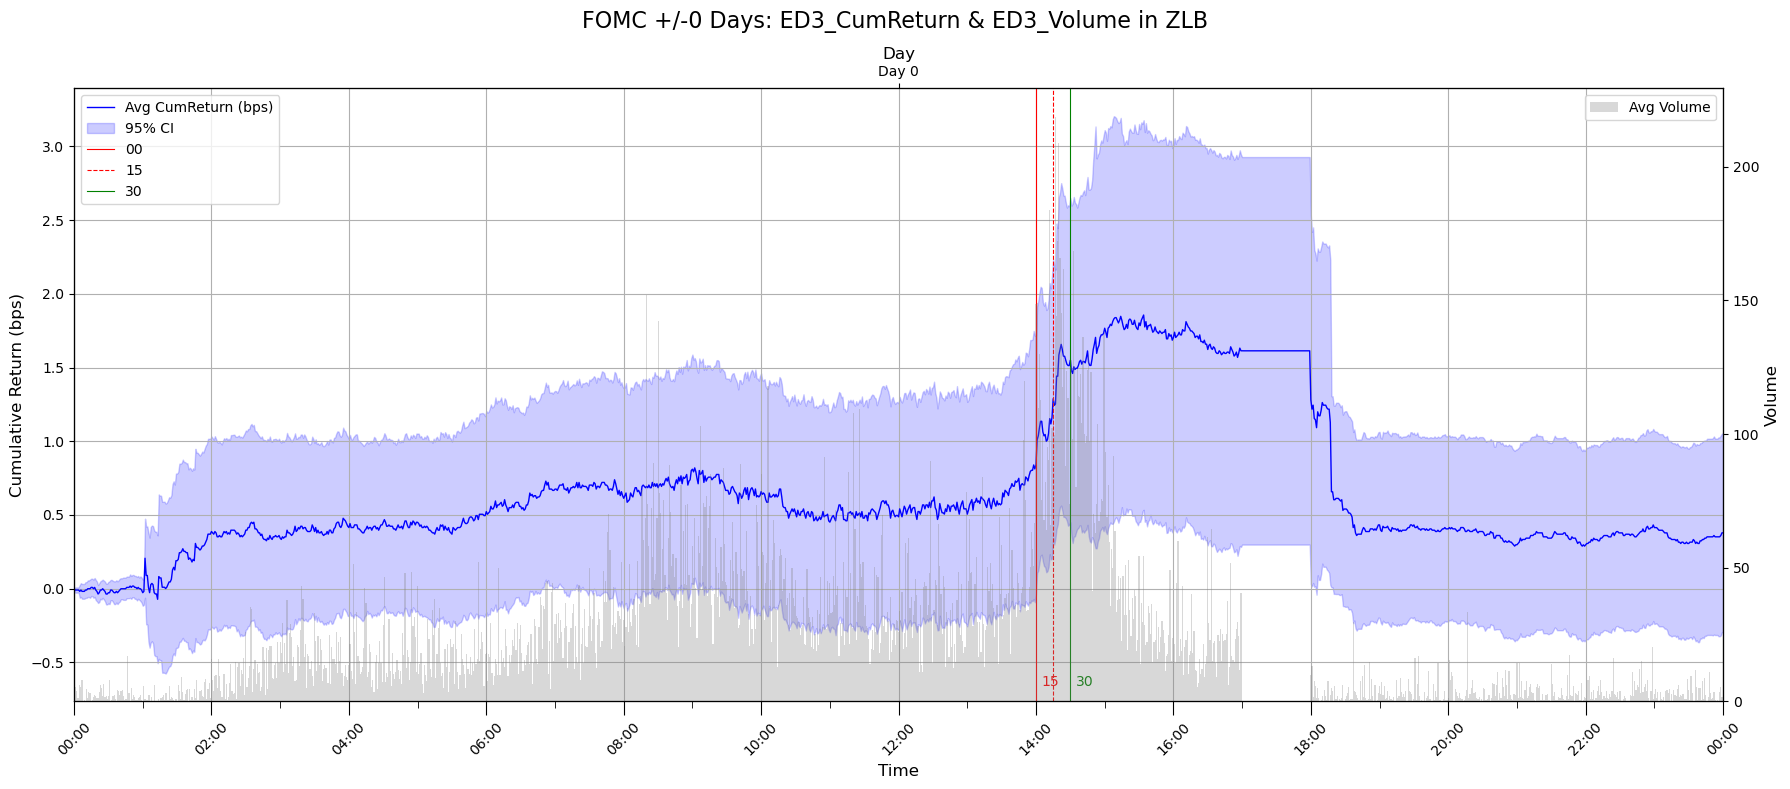

Saved CR table: ..\data\ED3\ED3_in_0_cr_ZLB.csv
Saved summary workbook: ..\data\ED3\ED3_k0_ZLB.xlsx
Saved LaTeX bundle: ..\data\ED3\latex\ZLB.tex
Skipping fomc event at 2024-01-31 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-12-13 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-11-01 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-09-20 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-07-26 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-06-14 14:00:00: no market data in +/-0 day window.


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Skipping fomc event at 2023-05-03 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-03-22 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2023-02-01 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-12-14 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-11-02 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-09-21 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-07-27 14:00:00: no market data in +/-0 day window.
Skipping fomc event at 2022-06-15 14:00:00: whole-day missing (or zero) on ['2022-06-15'] within +/-0 days.
Skipping fomc event at 2022-05-04 14:00:00: whole-day missing (or zero) on ['2022-05-04'] within +/-0 days.
Saved figure: ..\data\ED3\fomc_window_k0_Post-ZLB.png


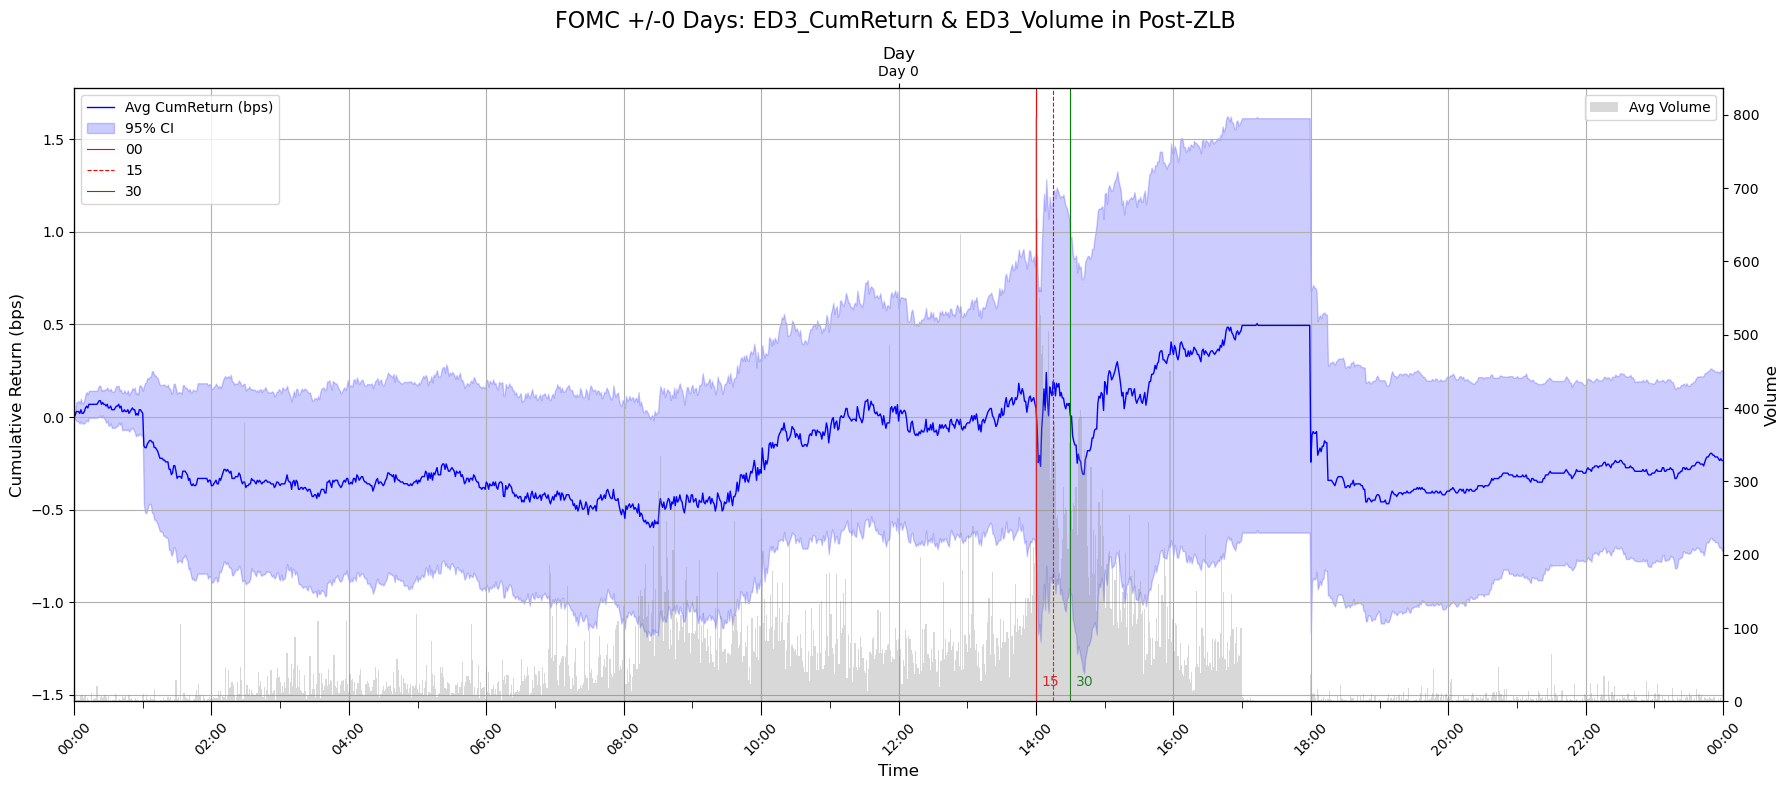

Saved CR table: ..\data\ED3\ED3_in_0_cr_Post-ZLB.csv
Saved summary workbook: ..\data\ED3\ED3_k0_Post-ZLB.xlsx
Saved LaTeX bundle: ..\data\ED3\latex\Post-ZLB.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


{'Pre-ZLB': {'figure_path': WindowsPath('../data/ED3/fomc_window_k0_Pre-ZLB.png'),
  'cr_table_path': WindowsPath('../data/ED3/ED3_in_0_cr_Pre-ZLB.csv'),
  'daily_summary': {'table':                      FOMC_week_Day (-2)                              \
                                      Mean St. Dev P25 P50 P75 No. Obs   
   Avg Daily Volume                    NaN     NaN NaN NaN NaN     0.0   
   Diff_Vol (Ann - Day)                NaN     NaN NaN NaN NaN     NaN   
   # Obs                               0.0     NaN NaN NaN NaN     NaN   
   
                        FOMC_week_Day (-1)                  ...  \
                                      Mean St. Dev P25 P50  ...   
   Avg Daily Volume                    NaN     NaN NaN NaN  ...   
   Diff_Vol (Ann - Day)                NaN     NaN NaN NaN  ...   
   # Obs                               0.0     NaN NaN NaN  ...   
   
                        FOMC_week_Day (+1)                 FOMC_week_Day (+2)  \
                          

In [68]:
plot_fomc_stacked_by_period_enhanced(asset='ED3', k=0, hft_sets=None, fomc_sets=None, 
                                        extra_metrics=None, fomc_type='fomc')

Skipping fomc event at 1994-12-20 14:17:00: whole-day missing (or zero) on ['1994-12-18', '1994-12-19', '1994-12-20', '1994-12-21', '1994-12-22'] within +/-2 days.
Skipping fomc event at 1994-11-15 14:20:00: whole-day missing (or zero) on ['1994-11-13', '1994-11-14', '1994-11-15', '1994-11-16', '1994-11-17'] within +/-2 days.
Skipping fomc event at 1994-09-27 14:18:00: whole-day missing (or zero) on ['1994-09-25', '1994-09-26', '1994-09-27', '1994-09-28', '1994-09-29'] within +/-2 days.
Skipping fomc event at 1994-08-16 13:18:00: whole-day missing (or zero) on ['1994-08-14', '1994-08-15', '1994-08-16', '1994-08-17', '1994-08-18'] within +/-2 days.
Skipping fomc event at 1994-07-06 14:18:00: whole-day missing (or zero) on ['1994-07-04', '1994-07-05', '1994-07-06', '1994-07-07', '1994-07-08'] within +/-2 days.
Skipping fomc event at 1994-05-17 14:26:00: whole-day missing (or zero) on ['1994-05-15', '1994-05-16', '1994-05-17', '1994-05-18', '1994-05-19'] within +/-2 days.
Skipping fomc ev

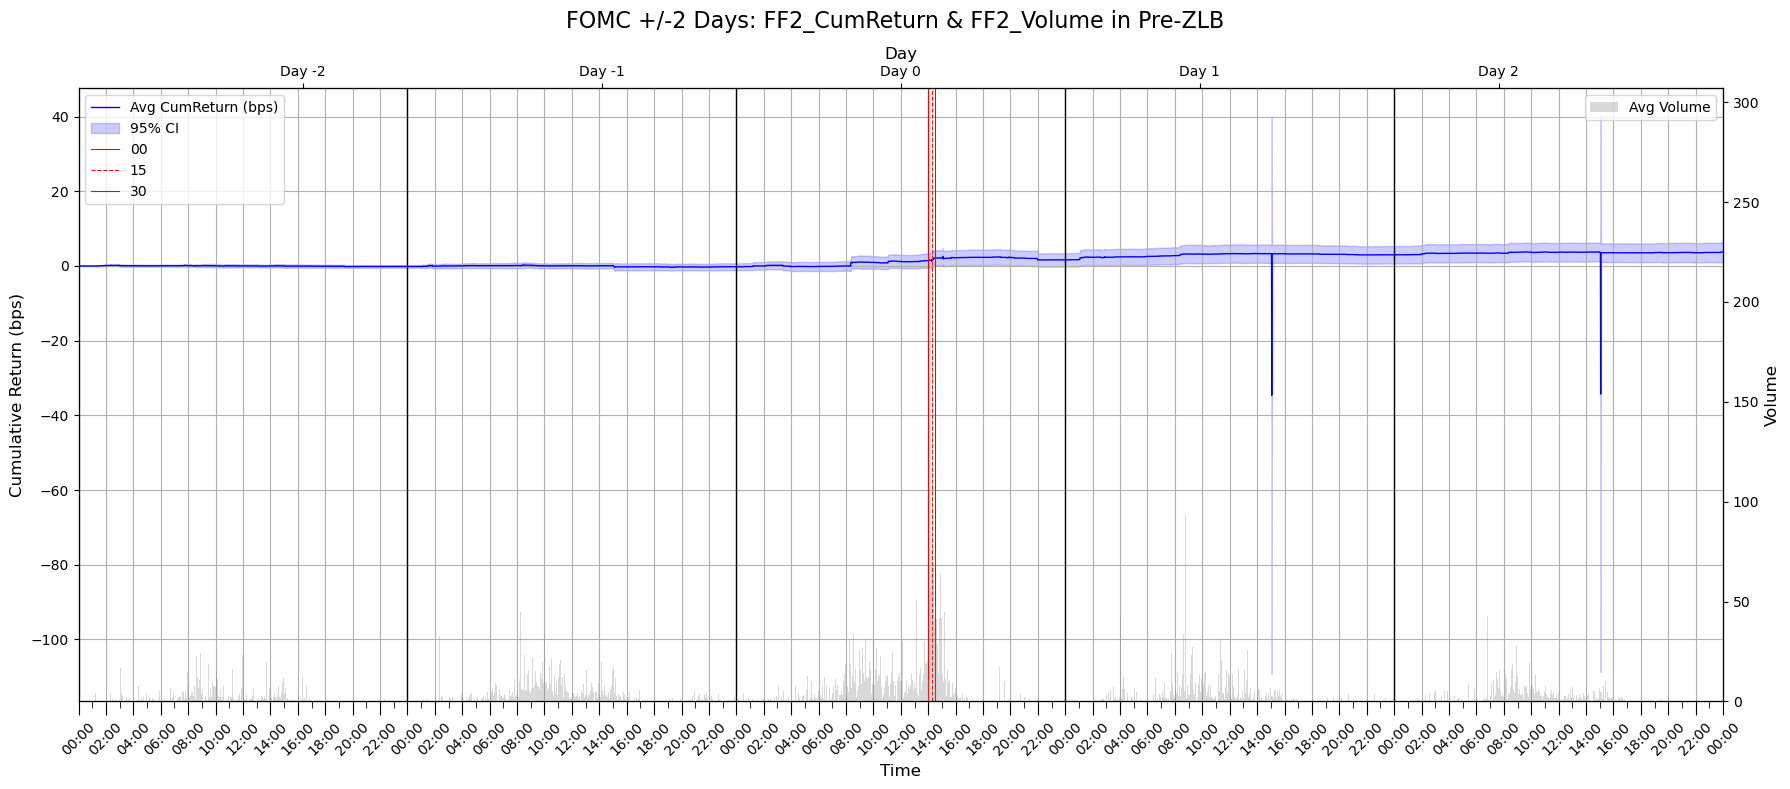

Saved CR table: ..\data\FF2\FF2_in_2_cr_Pre-ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\FF2\FF2_k2_Pre-ZLB.xlsx
Saved LaTeX bundle: ..\data\FF2\latex\Pre-ZLB.tex
Saved figure: ..\data\FF2\fomc_window_k2_ZLB.png


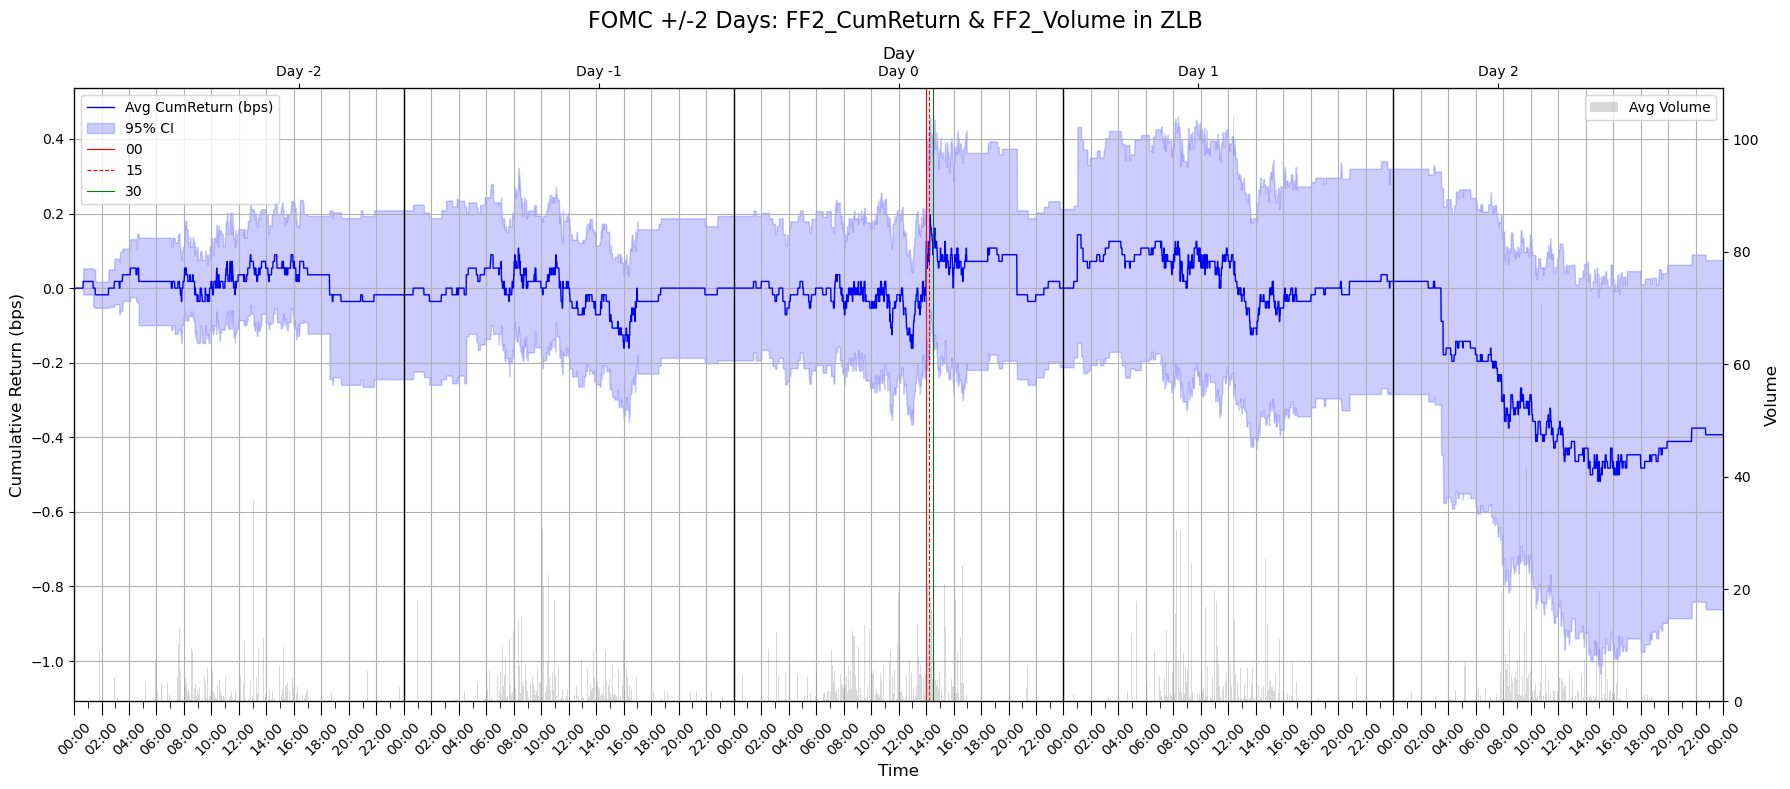

Saved CR table: ..\data\FF2\FF2_in_2_cr_ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\FF2\FF2_k2_ZLB.xlsx
Saved LaTeX bundle: ..\data\FF2\latex\ZLB.tex
Skipping fomc event at 2024-01-31 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-12-13 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-11-01 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-09-20 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-07-26 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-06-14 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-05-03 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-03-22 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-02-01 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-12-14 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-11-02 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-09-21

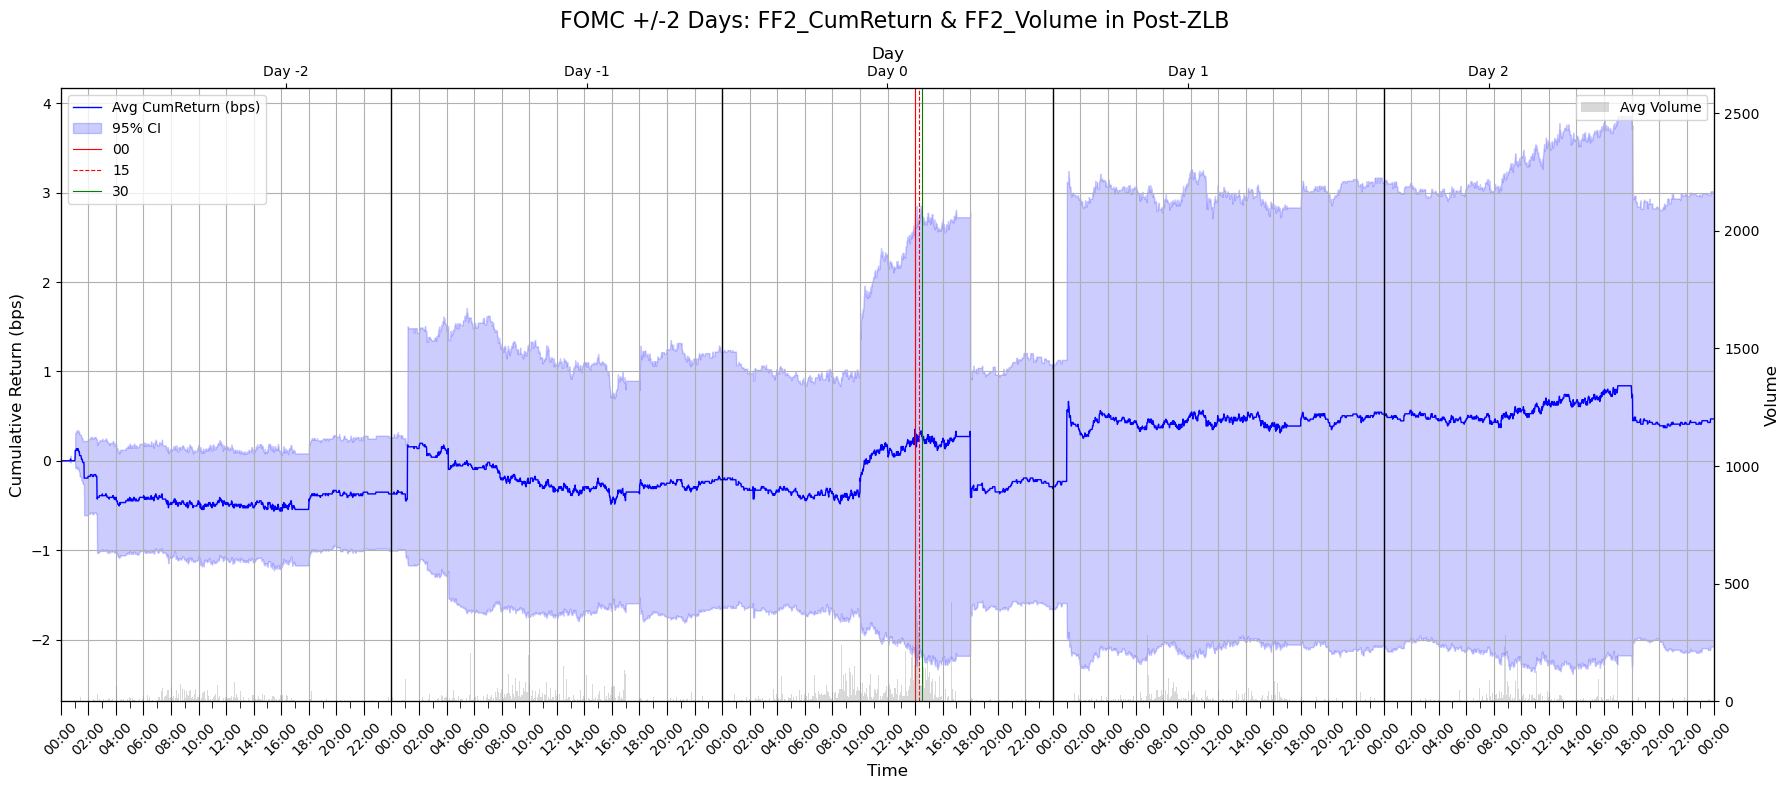

Saved CR table: ..\data\FF2\FF2_in_2_cr_Post-ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\FF2\FF2_k2_Post-ZLB.xlsx
Saved LaTeX bundle: ..\data\FF2\latex\Post-ZLB.tex


{'Pre-ZLB': {'figure_path': WindowsPath('../data/FF2/fomc_window_k2_Pre-ZLB.png'),
  'cr_table_path': WindowsPath('../data/FF2/FF2_in_2_cr_Pre-ZLB.csv'),
  'daily_summary': {'table':                      FOMC_week_Day (-2)                                     \
                                      Mean     St. Dev  P25  P50  P75 No. Obs   
   Avg Daily Volume            2616.579832  9499.01683  0.0  0.0  0.0   119.0   
   Diff_Vol (Ann - Day)        6733.957983         NaN  NaN  NaN  NaN     NaN   
   # Obs                        119.000000         NaN  NaN  NaN  NaN     NaN   
   
                        FOMC_week_Day (-1)                          ...  \
                                      Mean       St. Dev  P25  P50  ...   
   Avg Daily Volume            5201.411765  12188.442308  0.0  0.0  ...   
   Diff_Vol (Ann - Day)        4149.126050           NaN  NaN  NaN  ...   
   # Obs                        119.000000           NaN  NaN  NaN  ...   
   
                        FOMC_wee

In [69]:
plot_fomc_stacked_by_period_enhanced(asset='FF2', k=2, hft_sets=None, fomc_sets=None, 
                                        extra_metrics=None, fomc_type='fomc')

Saved figure: ..\data\ED2\fomc_window_k2_Pre-ZLB.png


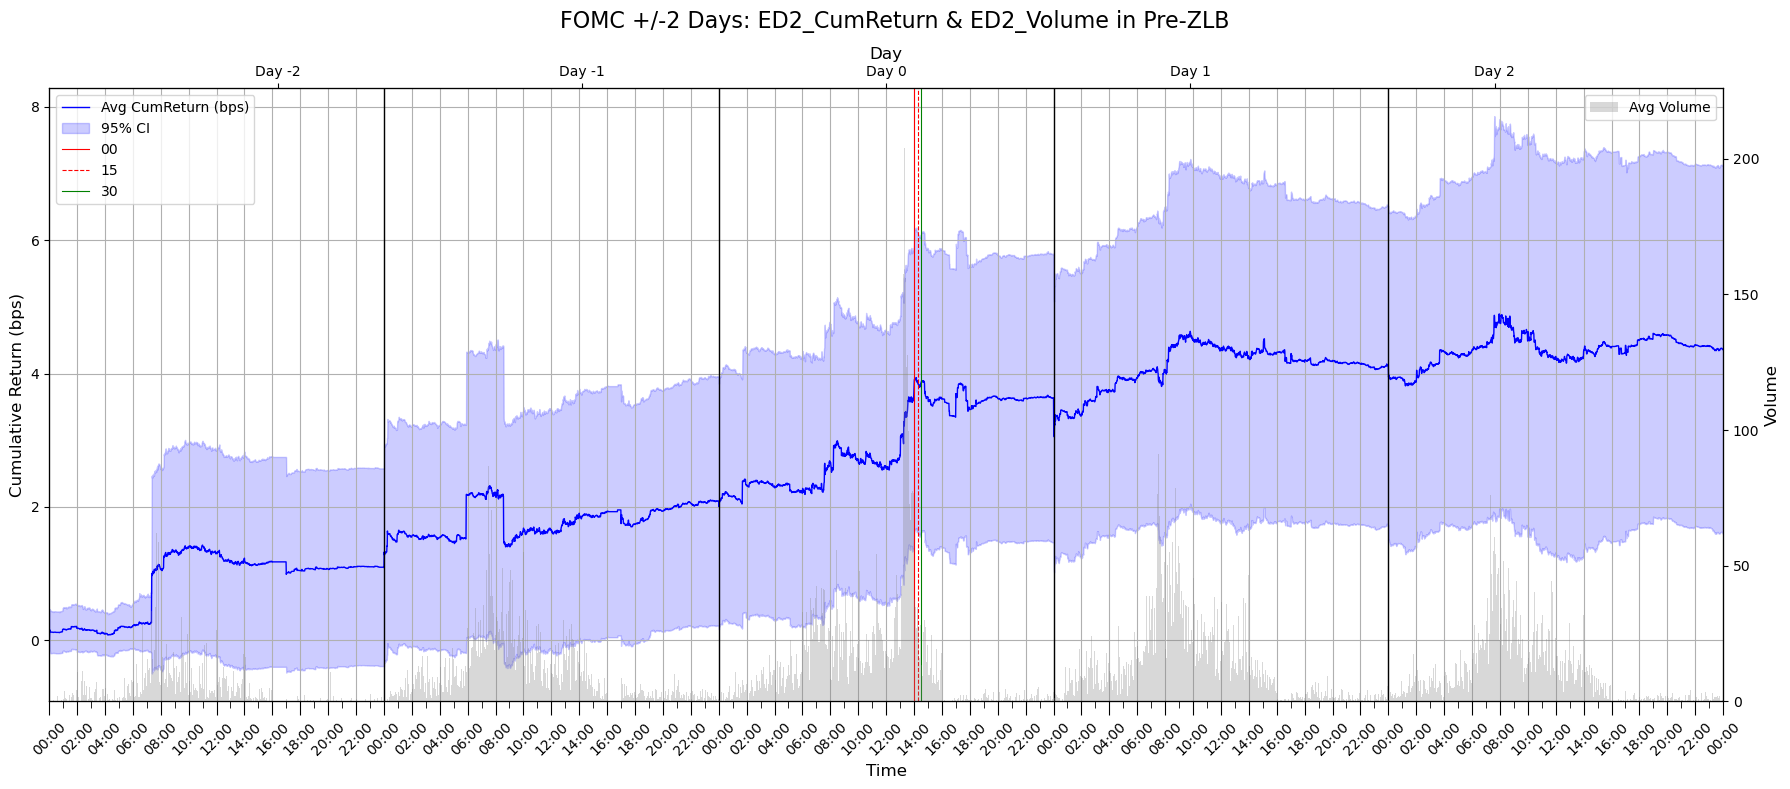

Saved CR table: ..\data\ED2\ED2_in_2_cr_Pre-ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\ED2\ED2_k2_Pre-ZLB.xlsx
Saved LaTeX bundle: ..\data\ED2\latex\Pre-ZLB.tex
Saved figure: ..\data\ED2\fomc_window_k2_ZLB.png


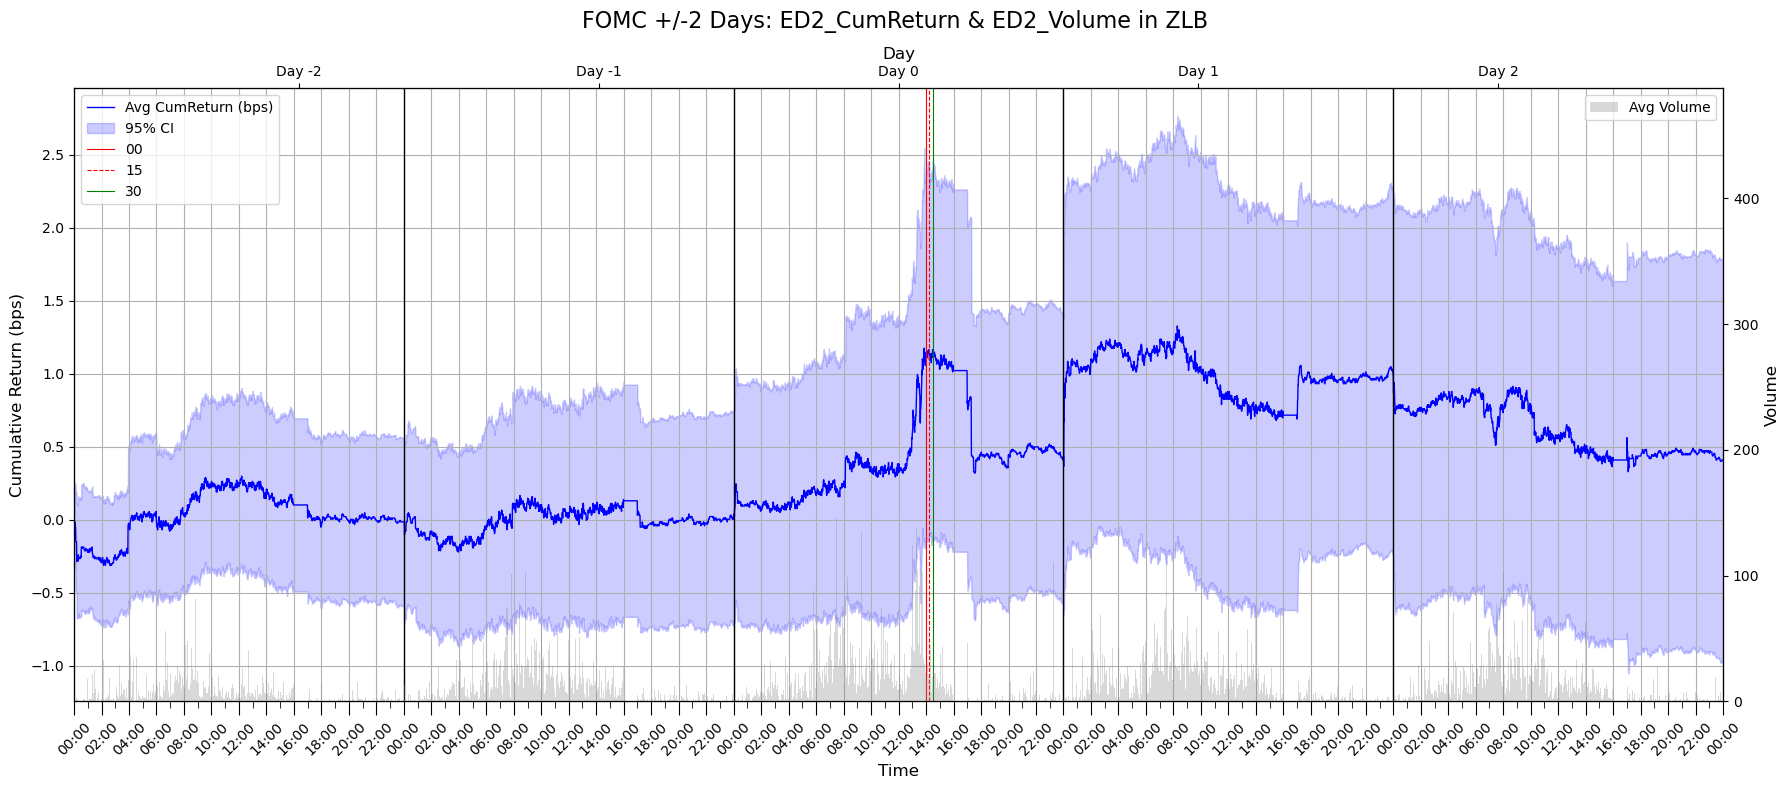

Saved CR table: ..\data\ED2\ED2_in_2_cr_ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\ED2\ED2_k2_ZLB.xlsx
Saved LaTeX bundle: ..\data\ED2\latex\ZLB.tex
Skipping fomc event at 2024-01-31 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-12-13 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-11-01 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-09-20 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-07-26 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-06-14 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-05-03 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-03-22 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-02-01 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-12-14 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-11-02 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-09-21

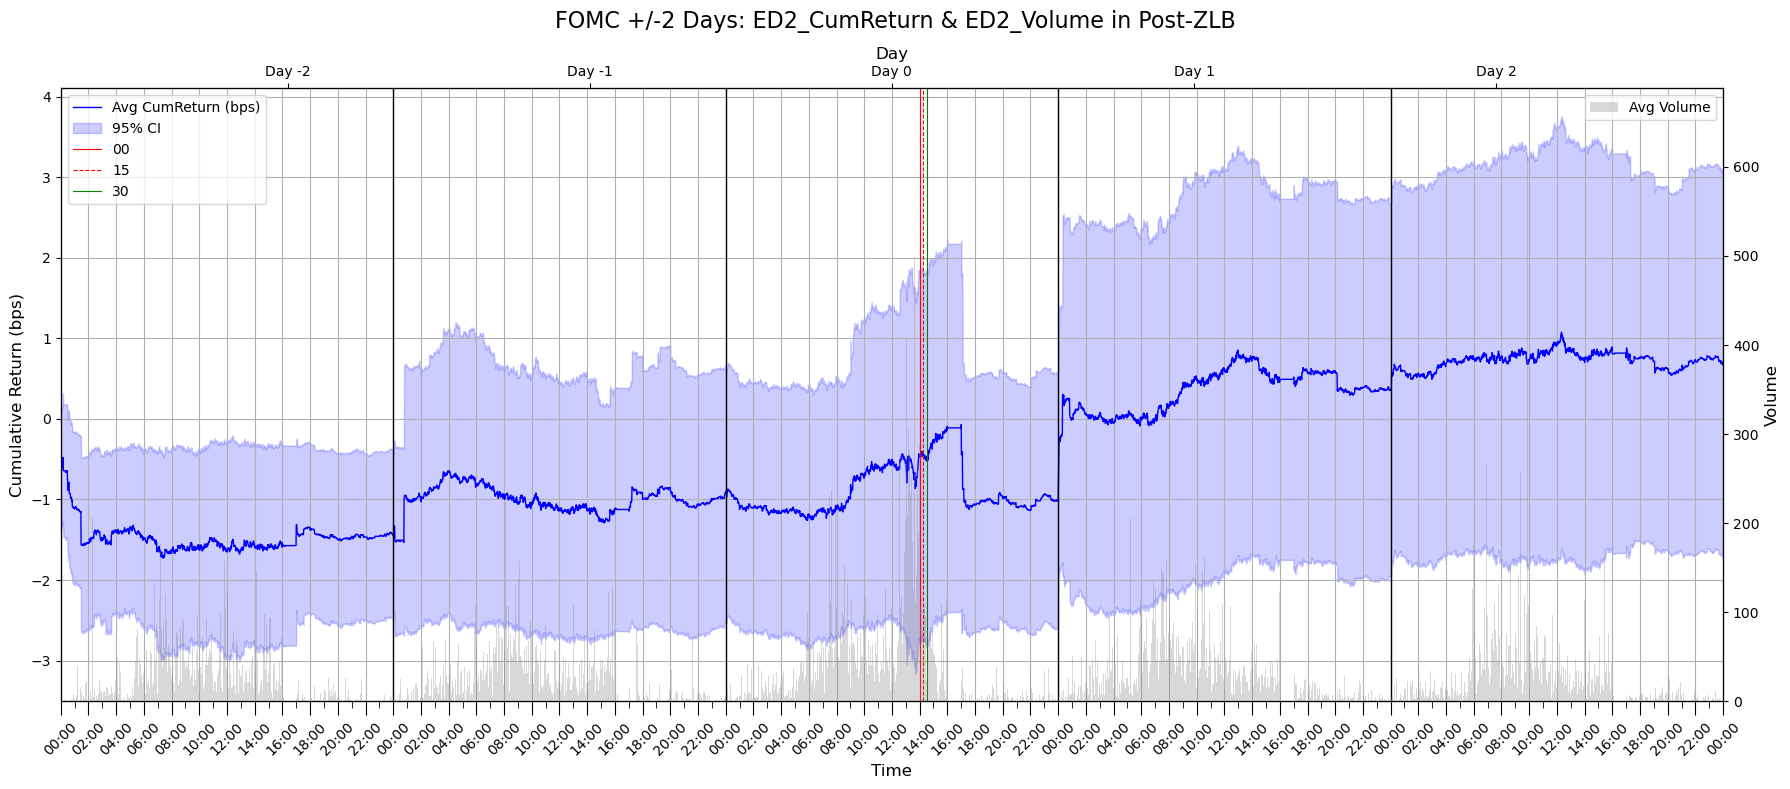

Saved CR table: ..\data\ED2\ED2_in_2_cr_Post-ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\ED2\ED2_k2_Post-ZLB.xlsx
Saved LaTeX bundle: ..\data\ED2\latex\Post-ZLB.tex


{'Pre-ZLB': {'figure_path': WindowsPath('../data/ED2/fomc_window_k2_Pre-ZLB.png'),
  'cr_table_path': WindowsPath('../data/ED2/ED2_in_2_cr_Pre-ZLB.csv'),
  'daily_summary': {'table':                      FOMC_week_Day (-2)                                       \
                                      Mean       St. Dev  P25  P50  P75 No. Obs   
   Avg Daily Volume             5513.49375  24600.986258  0.0  0.0  0.0   160.0   
   Diff_Vol (Ann - Day)        15386.98125           NaN  NaN  NaN  NaN     NaN   
   # Obs                         160.00000           NaN  NaN  NaN  NaN     NaN   
   
                        FOMC_week_Day (-1)                           ...  \
                                      Mean       St. Dev  P25   P50  ...   
   Avg Daily Volume            14839.55625  43568.633585  0.0  14.5  ...   
   Diff_Vol (Ann - Day)         6060.91875           NaN  NaN   NaN  ...   
   # Obs                         160.00000           NaN  NaN   NaN  ...   
   
                 

In [38]:
plot_fomc_stacked_by_period_enhanced(asset='ED2', k=2, hft_sets=None, fomc_sets=None, 
                                        extra_metrics=None, fomc_type='fomc')

Saved figure: ..\data\ED3\fomc_window_k2_Pre-ZLB.png


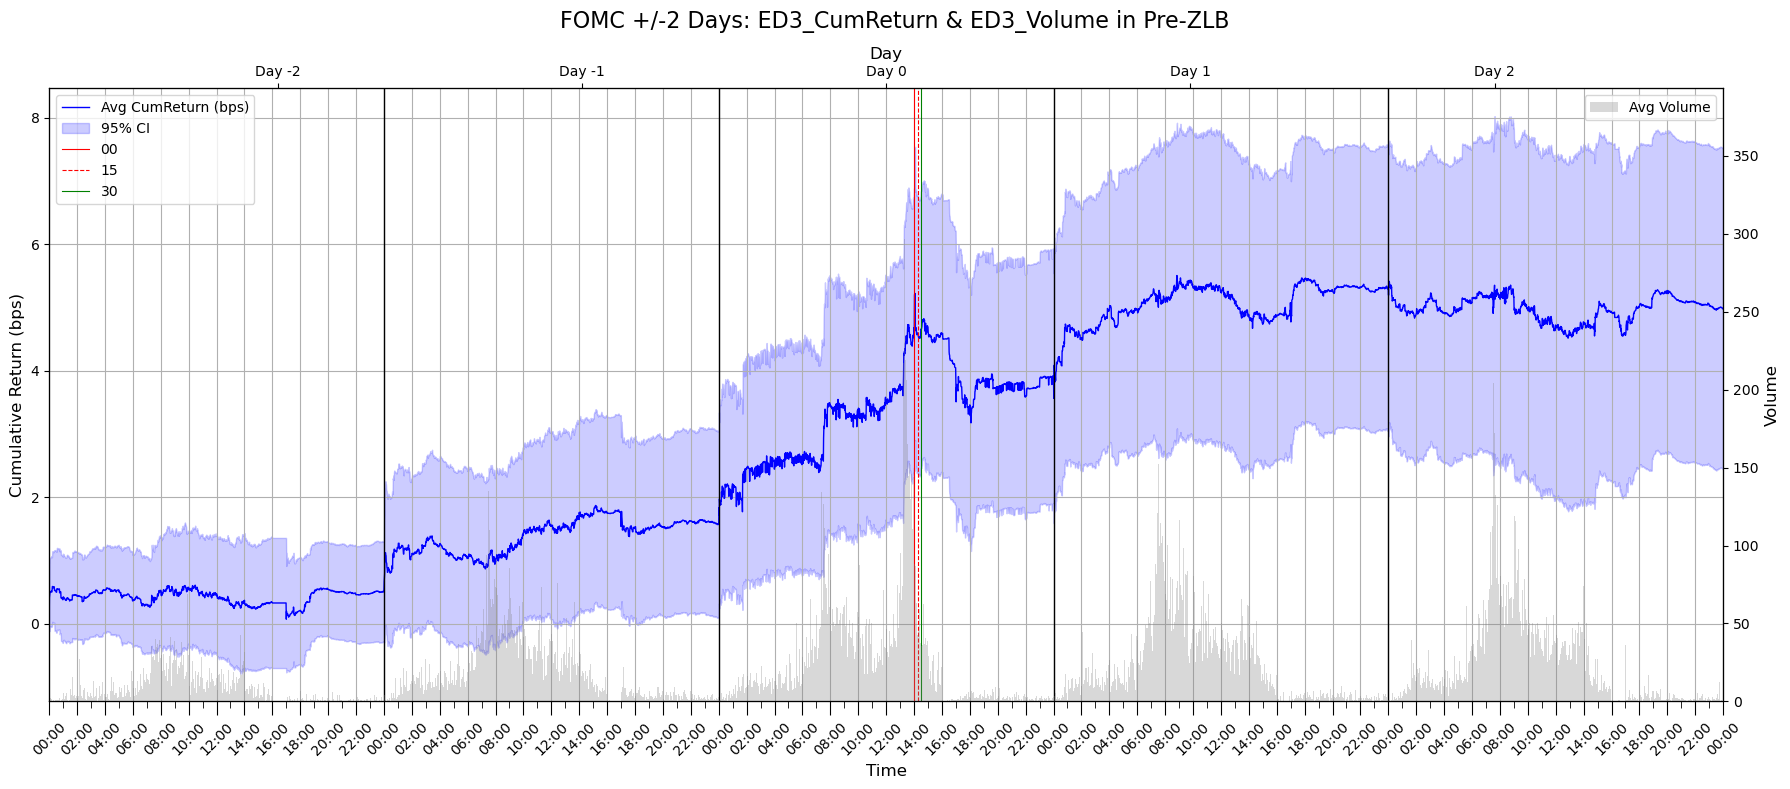

Saved CR table: ..\data\ED3\ED3_in_2_cr_Pre-ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\ED3\ED3_k2_Pre-ZLB.xlsx
Saved LaTeX bundle: ..\data\ED3\latex\Pre-ZLB.tex
Saved figure: ..\data\ED3\fomc_window_k2_ZLB.png


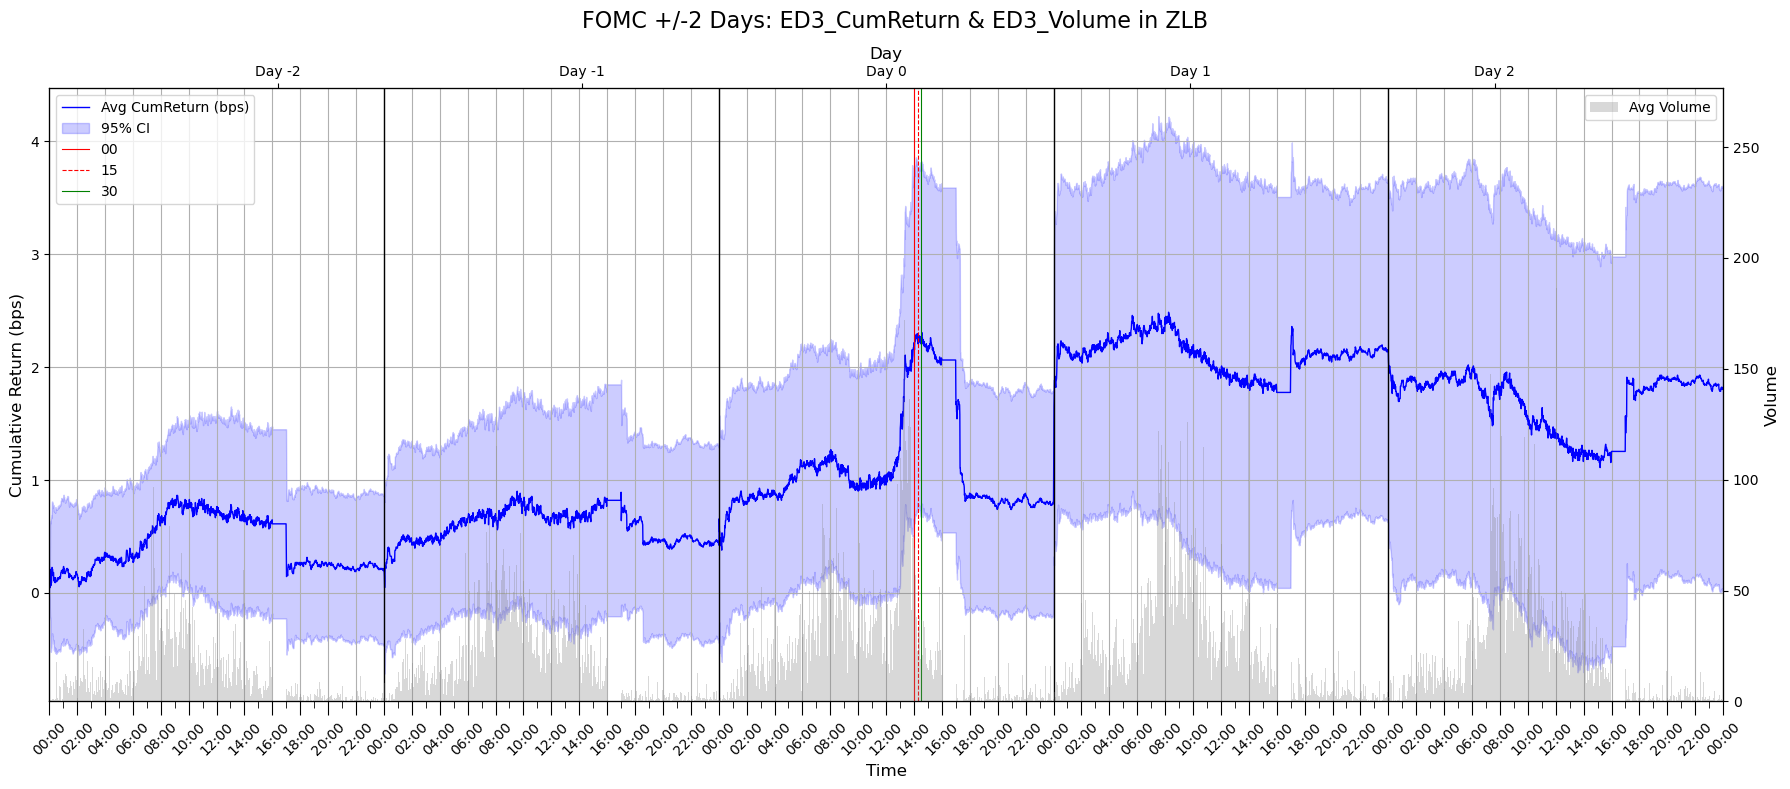

Saved CR table: ..\data\ED3\ED3_in_2_cr_ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\ED3\ED3_k2_ZLB.xlsx
Saved LaTeX bundle: ..\data\ED3\latex\ZLB.tex
Skipping fomc event at 2024-01-31 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-12-13 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-11-01 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-09-20 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-07-26 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-06-14 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-05-03 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-03-22 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-02-01 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-12-14 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-11-02 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-09-21

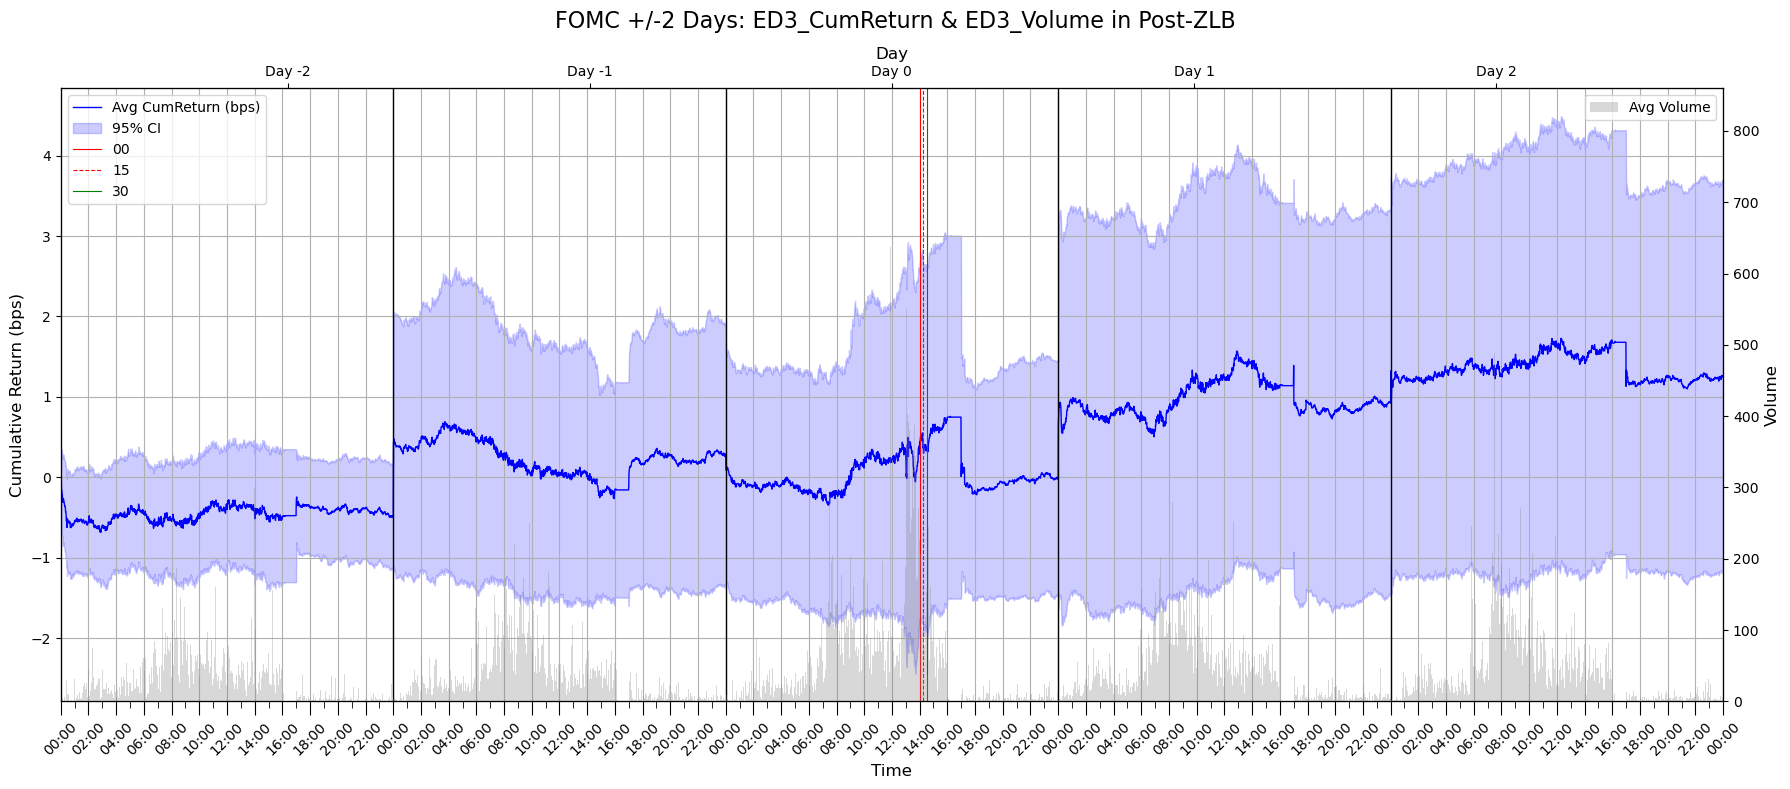

Saved CR table: ..\data\ED3\ED3_in_2_cr_Post-ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\ED3\ED3_k2_Post-ZLB.xlsx
Saved LaTeX bundle: ..\data\ED3\latex\Post-ZLB.tex


{'Pre-ZLB': {'figure_path': WindowsPath('../data/ED3/fomc_window_k2_Pre-ZLB.png'),
  'cr_table_path': WindowsPath('../data/ED3/ED3_in_2_cr_Pre-ZLB.csv'),
  'daily_summary': {'table':                      FOMC_week_Day (-2)                                 \
                                      Mean       St. Dev  P25  P50    P75   
   Avg Daily Volume            12049.33125  34800.609996  0.0  0.0  426.0   
   Diff_Vol (Ann - Day)        26400.45625           NaN  NaN  NaN    NaN   
   # Obs                         160.00000           NaN  NaN  NaN    NaN   
   
                                FOMC_week_Day (-1)                                \
                        No. Obs               Mean       St. Dev     P25     P50   
   Avg Daily Volume       160.0         27029.5625  54645.164051  188.75  1412.0   
   Diff_Vol (Ann - Day)     NaN         11420.2250           NaN     NaN     NaN   
   # Obs                    NaN           160.0000           NaN     NaN     NaN   
   
       

In [39]:
plot_fomc_stacked_by_period_enhanced(asset='ED3', k=2, hft_sets=None, fomc_sets=None, 
                                        extra_metrics=None, fomc_type='fomc')

Saved figure: ..\data\ED4\fomc_window_k2_Pre-ZLB.png


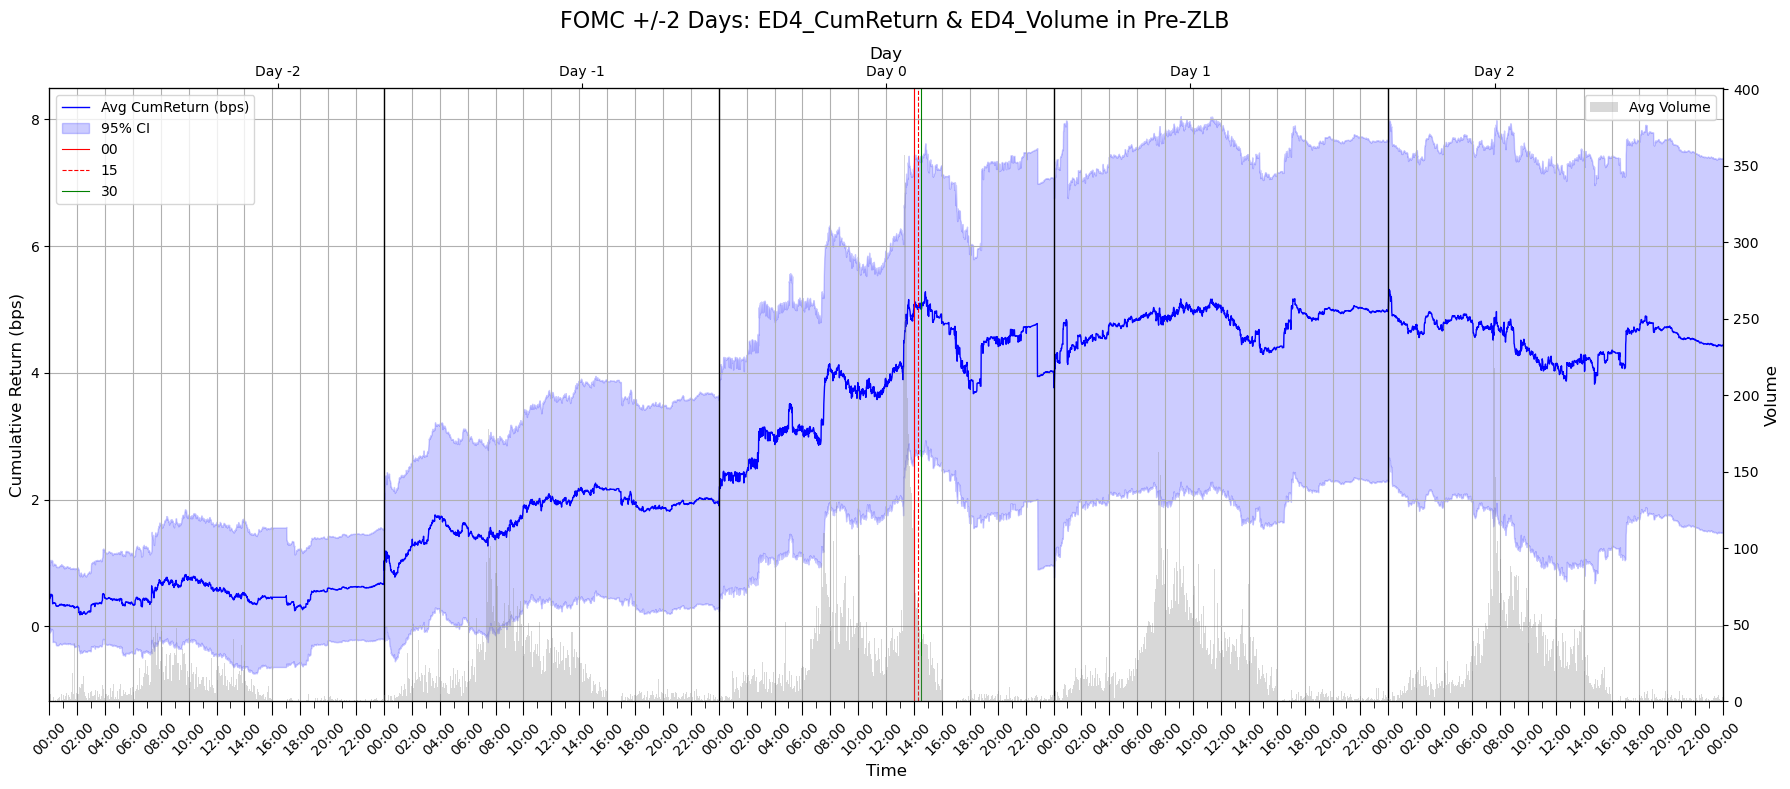

Saved CR table: ..\data\ED4\ED4_in_2_cr_Pre-ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\ED4\ED4_k2_Pre-ZLB.xlsx
Saved LaTeX bundle: ..\data\ED4\latex\Pre-ZLB.tex
Saved figure: ..\data\ED4\fomc_window_k2_ZLB.png


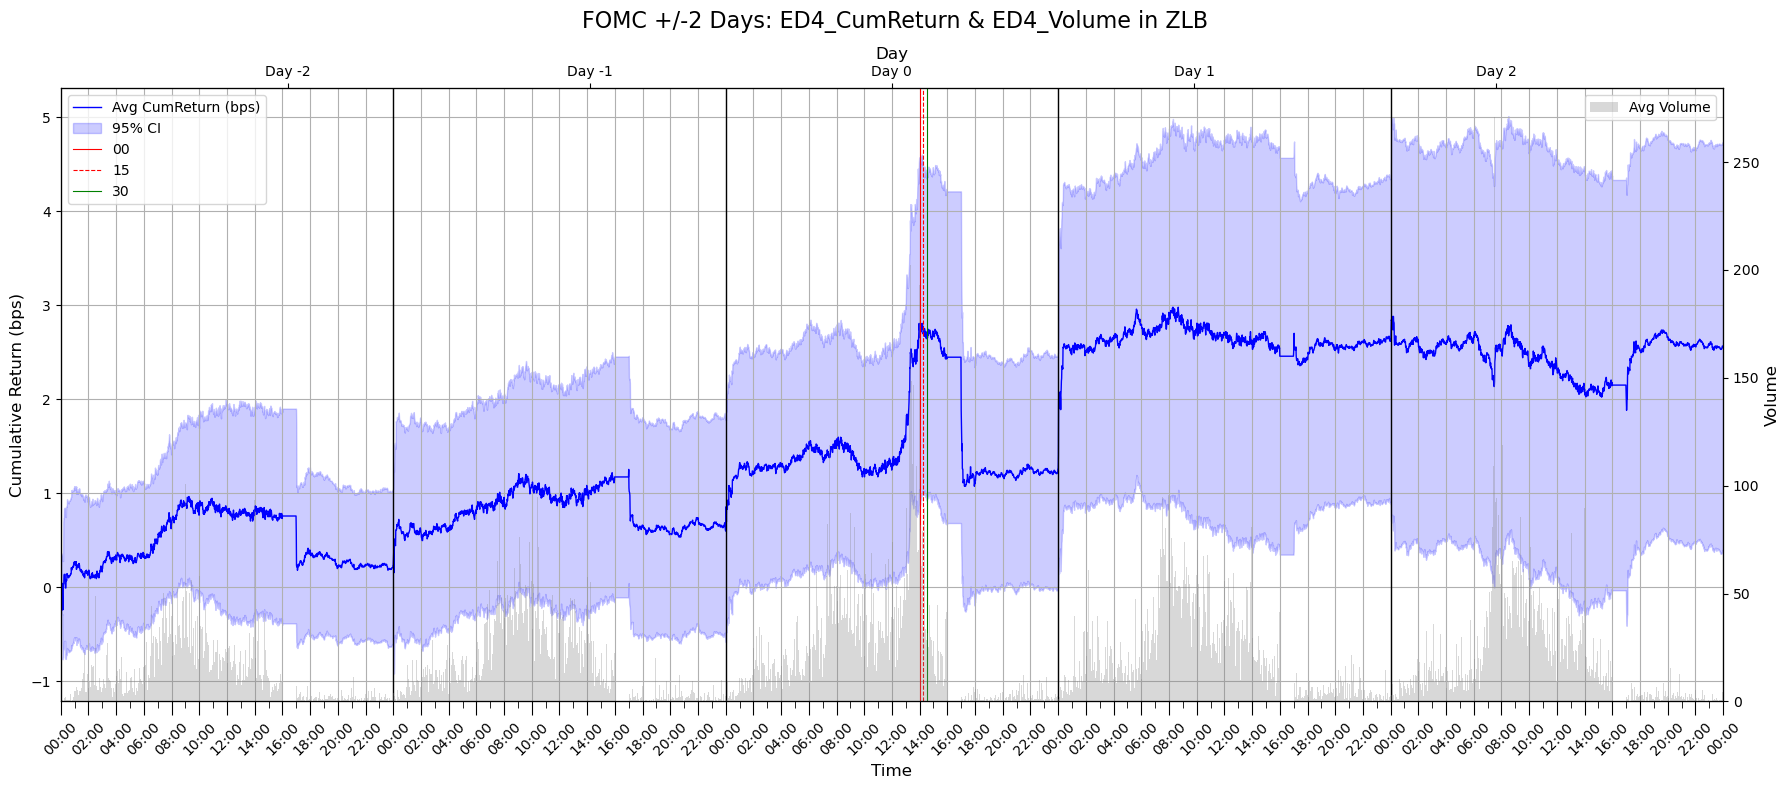

Saved CR table: ..\data\ED4\ED4_in_2_cr_ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\ED4\ED4_k2_ZLB.xlsx
Saved LaTeX bundle: ..\data\ED4\latex\ZLB.tex
Skipping fomc event at 2024-01-31 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-12-13 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-11-01 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-09-20 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-07-26 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-06-14 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-05-03 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-03-22 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2023-02-01 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-12-14 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-11-02 14:00:00: no market data in +/-2 day window.
Skipping fomc event at 2022-09-21

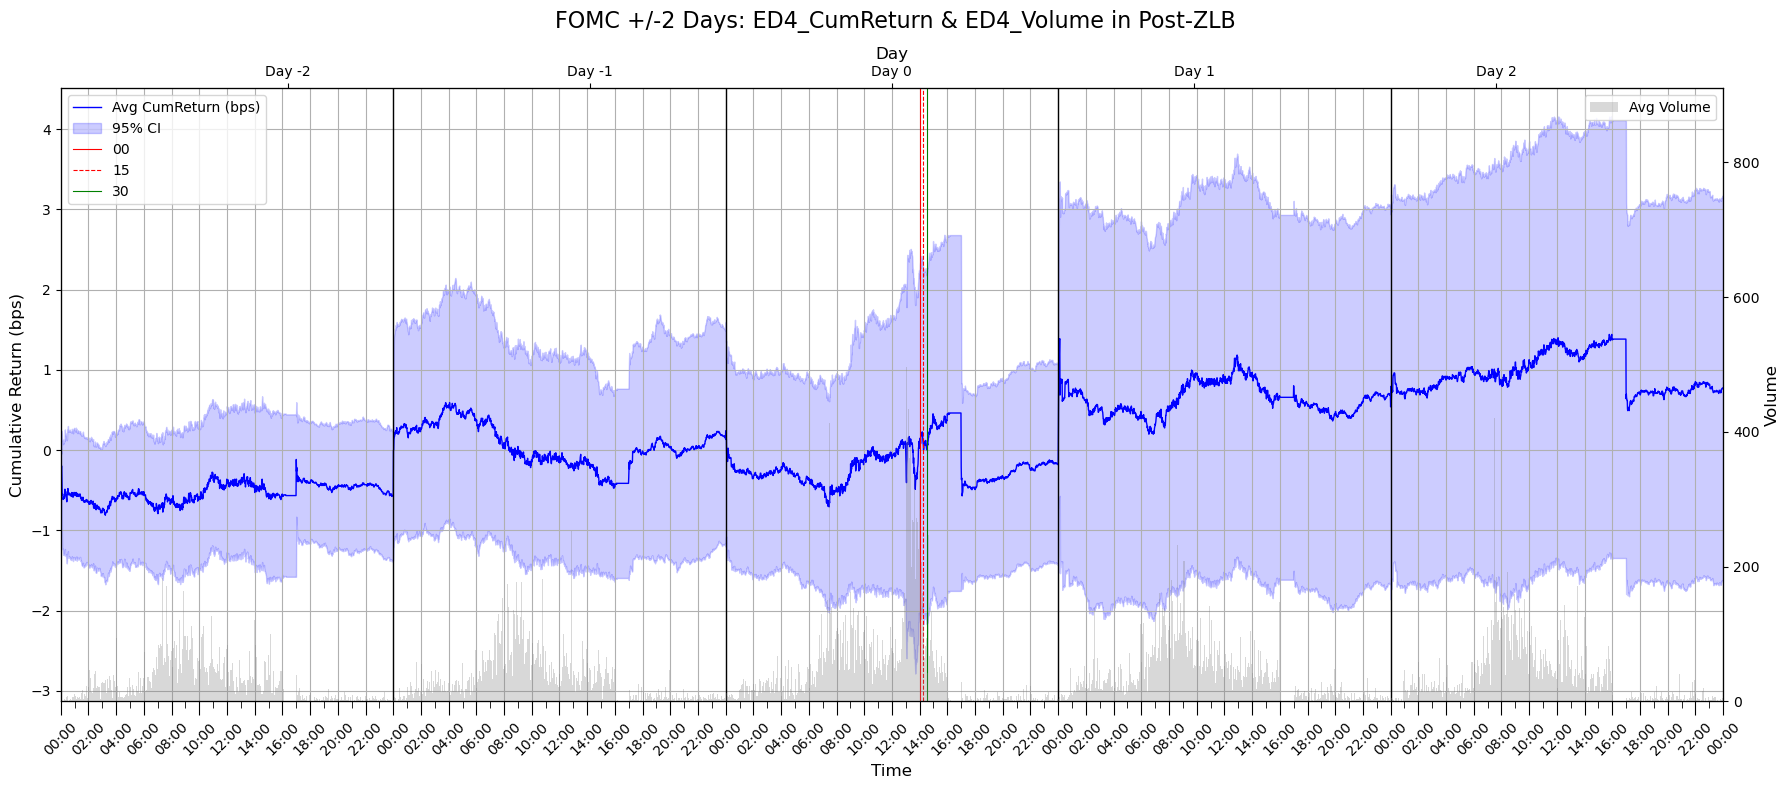

Saved CR table: ..\data\ED4\ED4_in_2_cr_Post-ZLB.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_55864\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\ED4\ED4_k2_Post-ZLB.xlsx
Saved LaTeX bundle: ..\data\ED4\latex\Post-ZLB.tex


{'Pre-ZLB': {'figure_path': WindowsPath('../data/ED4/fomc_window_k2_Pre-ZLB.png'),
  'cr_table_path': WindowsPath('../data/ED4/ED4_in_2_cr_Pre-ZLB.csv'),
  'daily_summary': {'table':                      FOMC_week_Day (-2)                                       \
                                      Mean     St. Dev  P25  P50    P75 No. Obs   
   Avg Daily Volume            12916.06875  38710.8366  0.0  0.0  228.0   160.0   
   Diff_Vol (Ann - Day)        24886.18750         NaN  NaN  NaN    NaN     NaN   
   # Obs                         160.00000         NaN  NaN  NaN    NaN     NaN   
   
                        FOMC_week_Day (-1)                                ...  \
                                      Mean       St. Dev     P25     P50  ...   
   Avg Daily Volume            27301.26250  56369.389356  106.75  1069.5  ...   
   Diff_Vol (Ann - Day)        10500.99375           NaN     NaN     NaN  ...   
   # Obs                         160.00000           NaN     NaN     NaN  ...

In [40]:
plot_fomc_stacked_by_period_enhanced(asset='ED4', k=2, hft_sets=None, fomc_sets=None, 
                                        extra_metrics=None, fomc_type='fomc')

In [41]:
# def plot_fomc_k_window_enhanced(
#     hft_input,
#     fomc_input,
#     k=1,
#     asset='',
#     period='',
#     extra_metrics=None,
#     fomc_type='fomc',
#     debug=False,            # 调试：仅返回 all_cr_list + cr_log
#     max_events=None         # 可选：限制处理的事件数量
# ):
#     """
#     增强版绘图函数，支持FOMC和非FOMC事件
#     fomc_type: 'fomc' 或 'nonfomc'
#     """
#     from pathlib import Path
#     import numpy as np
#     import pandas as pd
#     import matplotlib.pyplot as plt
#     from matplotlib.ticker import MultipleLocator, FuncFormatter

#     extra_metrics = extra_metrics or {}
#     metric_series = {name: [] for name in extra_metrics}

#     fomc_list = fomc_input['DateTime']
#     all_cr_list = []
#     all_vol_list = []
#     price_col = asset + '_Price'
#     volume_col = asset + '_Volume'

#     window_start_reference = lambda dt: dt.normalize() - pd.Timedelta(days=k)
#     window_end_reference   = lambda dt: dt.normalize() + pd.Timedelta(days=k + 1)

#     time_length_hours = 24 * (2 * k + 1)
#     total_minutes = int(time_length_hours * 60)

#     # ---- 调试：仅跟踪 all_cr_list 的“成长路径” ----
#     _cr_log = []  # 每当有事件成功 append 到 all_cr_list，就追加一条摘要

#     processed = 0

#     for fomc_dt in fomc_list:
#         window_start = window_start_reference(fomc_dt)
#         window_end   = window_end_reference(fomc_dt)

#         expected_index = pd.date_range(
#             window_start,
#             window_end - pd.Timedelta(minutes=1),
#             freq='min',
#         )

#         event_df = (
#             hft_input[
#                 (hft_input['DateAndTime'] >= window_start)
#                 & (hft_input['DateAndTime'] < window_end)
#             ]
#             .copy()
#         )
#         if event_df.empty:
#             print(f"Skipping {fomc_type} event at {fomc_dt}: no market data in +/-{k} day window.")
#             continue

#         event_df = event_df.set_index('DateAndTime').reindex(expected_index)
#         event_df.index.name = 'DateAndTime'

#         if price_col not in event_df.columns:
#             print(f"Skipping {fomc_type} event at {fomc_dt}: {price_col} column missing.")
#             continue

#         # --- 价格列数值化与“0 视为缺失” ---
#         event_df[price_col] = pd.to_numeric(event_df[price_col], errors='coerce')
#         event_df.loc[event_df[price_col].eq(0), price_col] = np.nan  # 0 当作缺失
#         price_series = event_df[price_col]

#         # --- 整天缺失/为0的判定：若窗口内存在“整天全缺失”，则跳过该事件 ---
#         day_non_missing = price_series.groupby(price_series.index.normalize()).apply(lambda s: s.notna().sum())
#         if (day_non_missing == 0).any():
#             missing_days = [d.strftime('%Y-%m-%d') for d, cnt in day_non_missing.items() if cnt == 0]
#             print(
#                 f"Skipping {fomc_type} event at {fomc_dt}: whole-day missing (or zero) on {missing_days} within +/-{k} days."
#             )
#             continue

#         # --- 仅对“单日内的少量 0/NaN”进行填补；不跨日 ---
#         DAILY_MAX_FILL_COUNT = 20   # 单日最多允许填补的分钟数（按需调参）
#         START_BFILL_LIMIT    = 1    # 起始端最多后向补的分钟数

#         by_day = price_series.groupby(price_series.index.normalize())
#         day_missing_count = by_day.apply(lambda s: s.isna().sum())

#         too_many_missing_days = [d.strftime('%Y-%m-%d') for d, m in day_missing_count.items() if m > DAILY_MAX_FILL_COUNT]
#         if too_many_missing_days:
#             print(
#                 f"Skipping {fomc_type} event at {fomc_dt}: excessive intraday gaps on {too_many_missing_days} "
#                 f"(>{DAILY_MAX_FILL_COUNT} minutes missing in a day) within +/-{k} days."
#             )
#             continue

#         def _fill_within_day(s: pd.Series) -> pd.Series:
#             s_filled = s.ffill()
#             if pd.isna(s_filled.iloc[0]):
#                 s_filled = s_filled.bfill(limit=START_BFILL_LIMIT)
#             return s_filled

#         pre_na  = int(price_series.isna().sum())
#         filled_series = by_day.apply(_fill_within_day)
#         post_na = int(filled_series.isna().sum())
#         filled_count = pre_na - post_na

#         price_series = filled_series

#         # --- 基准价使用填补后的首值 ---
#         baseline_price = price_series.iloc[0]
#         if pd.isna(baseline_price) or baseline_price <= 0:
#             print(
#                 f"Skipping {fomc_type} event at {fomc_dt} due to invalid baseline price after within-day fill: {baseline_price}."
#             )
#             continue

#         if volume_col not in event_df.columns:
#             print(f"Skipping {fomc_type} event at {fomc_dt}: {volume_col} column missing.")
#             continue

#         event_df[volume_col] = pd.to_numeric(event_df[volume_col], errors='coerce')
#         if event_df[volume_col].notna().sum() == 0:
#             print(
#                 f"Skipping {fomc_type} event at {fomc_dt}: {volume_col} missing data within +/-{k} day window."
#             )
#             continue
#         event_df[volume_col] = event_df[volume_col].fillna(0.0)

#         event_df = event_df.reset_index().rename(columns={'index': 'DateAndTime'})

#         # --- 计算累计收益、对齐分钟偏移 ---
#         event_df = calculate_cumulative_return(event_df, price_col, baseline_price)
#         event_df['MinuteFromStart'] = (event_df['DateAndTime'] - window_start).dt.total_seconds() / 60
#         event_df.set_index('MinuteFromStart', inplace=True)

#         # --- 记录 all_cr_list 的“成长路径”（仅摘要；不返回其他中间量） ---
#         if debug:
#             idx = event_df.index
#             _cr_log.append({
#                 'fomc_dt': fomc_dt,
#                 'series_len': int(len(event_df['CumReturn'])),
#                 'index_start': float(idx.min()) if len(idx) else None,
#                 'index_end': float(idx.max())   if len(idx) else None,
#                 'baseline_price': float(baseline_price) if pd.notna(baseline_price) else None,
#                 'filled_count': int(filled_count),
#                 'list_size_after_append': len(all_cr_list) + 1,  # 追加后的 all_cr_list 尺寸（直观）
#             })

#         # --- 汇总 ---
#         # 统一到完整分钟索引（0..total_minutes），确保每个事件长度一致  # NEW
#         full_minutes = np.arange(0, total_minutes + 1)                    # NEW（若前面已有同名变量，可复用）
#         cr_series = event_df['CumReturn'].reindex(full_minutes, method='nearest')  # NEW

#         # 给这个事件的 CR 序列命名（用事件日期或精确到时分，按需二选一）  # NEW
#         # 简洁版（只用日期）：
#         cr_series.name = f"{pd.Timestamp(fomc_dt).date()}"                 # NEW
#         # 如果你更想保留当天的具体时刻，比如 14:00：
#         # cr_series.name = f"{pd.Timestamp(fomc_dt):%Y-%m-%d %H:%M}"       # NEW (可替换上一行)

#         # 汇总                                                             # CHANGED
#         all_cr_list.append(cr_series)                                      # CHANGED（从 event_df['CumReturn'] 改为 cr_series）
#         all_vol_list.append(event_df[volume_col].reindex(full_minutes, method='nearest'))  # NEW（体量也对齐，保持一致）


#         for metric_name, column in extra_metrics.items():
#             if column in event_df.columns:
#                 metric_series[metric_name].append(event_df[column])

#         processed += 1
#         if (max_events is not None) and (processed >= max_events):
#             break

#     # 若没有有效事件
#     if not all_cr_list:
#         print(f'No valid {fomc_type} events found!')
#         if debug:
#             return {
#                 'all_cr_list': all_cr_list,  # 空
#                 'cr_log': _cr_log,           # 可能为空
#             }
#         return None

#     # --- 计算平均与置信区间 ---
#     merged_cr = pd.concat(all_cr_list, axis=1)
#     avg_cr = merged_cr.mean(axis=1)
#     std_cr = merged_cr.std(axis=1)
#     n = merged_cr.shape[1]

#     ci_upper = avg_cr + 1.96 * std_cr / np.sqrt(n)
#     ci_lower = avg_cr - 1.96 * std_cr / np.sqrt(n)

#     avg_cr = avg_cr.sort_index()
#     ci_upper = ci_upper.sort_index()
#     ci_lower = ci_lower.sort_index()
#     full_minutes = np.arange(0, total_minutes + 1)
#     avg_cr = avg_cr.reindex(full_minutes, method='nearest')
#     ci_upper = ci_upper.reindex(full_minutes, method='nearest')
#     ci_lower = ci_lower.reindex(full_minutes, method='nearest')

#     avg_cr_bps = avg_cr * 10000
#     ci_upper_bps = ci_upper * 10000
#     ci_lower_bps = ci_lower * 10000

#     merged_vol = pd.concat(all_vol_list, axis=1)
#     avg_vol = merged_vol.mean(axis=1)
#     avg_vol = avg_vol.sort_index().reindex(full_minutes, method='nearest')

#     # --- 绘图 ---
#     fig, ax1 = plt.subplots(figsize=(18, 8))
#     ax1.plot(full_minutes, avg_cr_bps, color='blue', linewidth=1, label='Avg CumReturn (bps)')
#     ax1.fill_between(full_minutes, ci_lower_bps, ci_upper_bps, color='blue', alpha=0.2, label='95% CI')
#     ax1.set_ylabel('Cumulative Return (bps)', fontsize=12)
#     ax1.set_xlabel('Time', fontsize=12)

#     ax2 = ax1.twinx()
#     ax2.bar(full_minutes, avg_vol, width=1.0, color='gray', alpha=0.3, label='Avg Volume')
#     ax2.set_ylabel('Volume', fontsize=12)

#     # 公告竖线（2:00 ET 对应 +840 分钟）
#     announcement_minute = int(k * 1440 + 840)
#     event_label = 'Non-FOMC Event' if fomc_type == 'nonfomc' else 'FOMC Announcement'
#     ax1.axvline(x=announcement_minute, color='red', linestyle='--', linewidth=0.5, label=event_label)

#     # 每日分隔线
#     num_days = 2 * k + 1
#     for i in range(1, num_days):
#         day_boundary = i * 1440
#         ax1.axvline(x=day_boundary, color='black', linewidth=1)

#     ax1.xaxis.set_major_locator(MultipleLocator(120))
#     ax1.xaxis.set_minor_locator(MultipleLocator(60))
#     ax1.tick_params(axis='x', which='major', length=10, rotation=45)
#     ax1.tick_params(axis='x', which='minor', length=5)

#     def time_formatter(x, pos):
#         t = x % 1440
#         hours = int(t // 60)
#         minutes = int(t % 60)
#         return f'{hours:02d}:{minutes:02d}'

#     ax1.xaxis.set_major_formatter(FuncFormatter(time_formatter))

#     ax_top = ax1.twiny()
#     ax_top.set_xlim(ax1.get_xlim())
#     day_centers = [i * 1440 + 720 for i in range(num_days)]
#     day_labels = [f'Day {i - k}' for i in range(num_days)]
#     ax_top.set_xticks(day_centers)
#     ax_top.set_xticklabels(day_labels)
#     ax_top.set_xlabel('Day', fontsize=12)

#     ax1.set_xlim(0, total_minutes)

#     event_type = 'Non-FOMC' if fomc_type == 'nonfomc' else 'FOMC'
#     fig.suptitle(f'{event_type} +/-{k} Days: {price_col} & {volume_col} in {period}_Period', fontsize=16)
#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')
#     ax1.grid(True)
#     plt.tight_layout()

#     asset_str = str(asset) if asset else 'asset'
#     period_str = str(period) if period else 'period'
#     safe_period = period_str.replace(' ', '_')
#     asset_dir = DATA_ROOT / asset_str

#     # 如果是nonfomc类型，另存到专门的文件夹
#     if fomc_type == 'nonfomc':
#         save_dir = asset_dir / 'nonfomc'
#         save_dir.mkdir(parents=True, exist_ok=True)
#         prefix = 'nonfomc_'
#     else:
#         save_dir = asset_dir
#         save_dir.mkdir(parents=True, exist_ok=True)
#         prefix = ''

#     fig_path = save_dir / f'{prefix}fomc_window_k{k}_{safe_period}.png'
#     fig.savefig(fig_path, dpi=200, bbox_inches='tight')
#     print(f'Saved figure: {fig_path}')
#     plt.show()

#     # --- 导出 CR 表 ---
#     cr_table = pd.DataFrame({
#         'MinuteFromStart': full_minutes,
#         'Average_CR_bps': avg_cr_bps.values,
#         'CI_Lower_bps': ci_lower_bps.values,
#         'CI_Upper_bps': ci_upper_bps.values,
#         'volume': avg_vol.values,
#     })
#     cr_out = save_dir / f'{prefix}{asset_str}_in_{k}_cr_{safe_period}.csv'
#     cr_table.to_csv(cr_out, index=False)
#     print(f'Saved CR table: {cr_out}')

#     # --- 体量/周期性汇总（沿用你的外部函数） ---
#     daily_summary = summarize_fomc_daily_volume(
#         merged_vol,
#         k=k,
#         window_days=2,
#         make_tables=False,
#     )
#     intraday_summary = analyze_volume_periodicity(
#         merged_vol,
#         k=k,
#         window_list=(15, 30, 60, 120, 720),
#         make_tables=False,
#     )

#     persist_info = _persist_volume_outputs_enhanced(
#         asset_str,
#         period_str,
#         k,
#         daily_summary['table'],
#         intraday_summary['volume_table'],
#         intraday_summary['variance_table'],
#         fomc_type=fomc_type,
#     )
#     print(f"Saved summary workbook: {persist_info['excel_path']}")
#     print(f"Saved LaTeX bundle: {persist_info['latex_path']}")

#     # --- 扩展指标输出（保持原逻辑） ---
#     extra_exports = {}
#     if extra_metrics:
#         for metric_name, series_list in metric_series.items():
#             if not series_list:
#                 continue
#             merged_metric = pd.concat(series_list, axis=1)
#             metric_period = f"{period_str}_{metric_name}".strip('_')
#             metric_daily = summarize_fomc_daily_volume(
#                 merged_metric,
#                 k=k,
#                 window_days=2,
#                 make_tables=False,
#             )
#             metric_intraday = analyze_volume_periodicity(
#                 merged_metric,
#                 k=k,
#                 window_list=(15, 30, 60, 120, 720),
#                 make_tables=False,
#             )
#             metric_export = _persist_volume_outputs_enhanced(
#                 asset_str,
#                 metric_period,
#                 k,
#                 metric_daily['table'],
#                 metric_intraday['volume_table'],
#                 metric_intraday['variance_table'],
#                 fomc_type=fomc_type,
#             )
#             print(f"Saved extras ({metric_name}) workbook: {metric_export['excel_path']}")
#             print(f"Saved extras ({metric_name}) LaTeX: {metric_export['latex_path']}")
#             extra_exports[metric_name] = {
#                 'daily_summary': metric_daily,
#                 'intraday_summary': metric_intraday,
#                 'export_paths': metric_export,
#             }

#     result = {
#         'figure_path': fig_path,
#         'cr_table_path': cr_out,
#         'daily_summary': daily_summary,
#         'intraday_summary': intraday_summary,
#         'export_paths': persist_info,
#         'extra_metrics': extra_exports,
#         'all_cr_list': all_cr_list,       
#     }
#     if debug:
#         result['cr_log'] = _cr_log
#     return result


In [42]:
# out = plot_fomc_k_window_enhanced(
#     hft_input=post_zlb_hft,
#     fomc_input=fomc_data,
#     k=2,
#     asset='FF1',
#     period='post-zlb',
#     fomc_type='fomc'
# )

# # 1) 直接拿 all_cr_list
# all_cr_list = out['all_cr_list']
# print("事件数：", len(all_cr_list))
# print("首个事件名：", all_cr_list[0].name)
# print("索引范围：", int(all_cr_list[0].index.min()), "->", int(all_cr_list[0].index.max()))  # 0 -> 7200

# # 2) 拼成矩阵（行=0..7200，列=事件名）
# cr_matrix = pd.concat(all_cr_list, axis=1)  # 列名就是各事件的日期/时间
# cr_matrix.head()
# cr_matrix.tail()


### Regression - stata ###